# データセット定義・統計・妥当性分析

このノートブックでは、査読コメントに対応するため、以下の分析を実行します:

## A. データセット定義・統計・妥当性まわり

1. **データセットの基本情報確認**
2. **ΔpIC50の分布とノイズ評価**
3. **変換ごとのサンプル数の集計**
4. **ポジティブ/ネガティブサンプルの件数・割合**
5. **フラグメントサイズ(15原子)の妥当性検証**
6. **データ分割方法の確認と文書化**

## 1. ライブラリのインポートとデータ読み込み

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import japanize_matplotlib

warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 表示設定
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("ライブラリのインポート完了")

ライブラリのインポート完了


In [69]:
# データセットの読み込み
data_path = '/gs/bs/tga-ohuelab/masunaga/MMP_dataset/dataset.csv'
df = pd.read_csv(data_path)

print(f"データセット読み込み完了: {data_path}")
print(f"データ件数: {len(df):,} 件")

データセット読み込み完了: /gs/bs/tga-ohuelab/masunaga/MMP_dataset/dataset.csv
データ件数: 1,492,142 件


## 2. データセットの基本情報確認

### 2.1 カラム情報とデータ型

In [70]:
# カラム名の表示
print("■ カラム一覧:")
print(df.columns.tolist())
print(f"\n■ カラム数: {len(df.columns)}")
print(f"■ データ件数: {len(df):,} 件")
print(f"\n■ データ型:")
df.info()

■ カラム一覧:
['REF-CID', 'PRB-CID', 'AID', 'TID', 'CUT_NUM', 'COMMON_FRAG', 'REF-FRAG', 'PRB-FRAG', 'SMIRKS', 'REF-FRAG_heavy', 'PRB-FRAG_heavy', 'VAR_heavy_sum', 'REF-standard_value', 'REF-SMILES', 'STANDARD_TYPE', 'PRB-standard_value', 'PRB-SMILES', 'delta_value', 'label_bin']

■ カラム数: 19
■ データ件数: 1,492,142 件

■ データ型:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492142 entries, 0 to 1492141
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   REF-CID             1492142 non-null  object 
 1   PRB-CID             1492142 non-null  object 
 2   AID                 1492142 non-null  int64  
 3   TID                 1492142 non-null  object 
 4   CUT_NUM             1492142 non-null  int64  
 5   COMMON_FRAG         1492142 non-null  object 
 6   REF-FRAG            1492142 non-null  object 
 7   PRB-FRAG            1492142 non-null  object 
 8   SMIRKS              1492142 non-null  object 
 9   REF

### 2.2 基本統計量

In [71]:
# 数値カラムの基本統計量
print("■ 数値カラムの基本統計量:")
numeric_cols = ['REF-FRAG_heavy', 'PRB-FRAG_heavy', 'VAR_heavy_sum', 
                'REF-standard_value', 'PRB-standard_value', 'delta_value']
df[numeric_cols].describe()

■ 数値カラムの基本統計量:


,REF-FRAG_heavy,PRB-FRAG_heavy,VAR_heavy_sum,REF-standard_value,PRB-standard_value,delta_value
count,1.492142e+06,1.492142e+06,1.492142e+06,1.492142e+06,1.492142e+06,1.492142e+06
mean,8.787436e+00,8.771037e+00,1.755847e+01,1.351117e+03,1.351042e+03,-6.530077e-03
std,3.539817e+00,3.543796e+00,6.344686e+00,2.835566e+03,2.833671e+03,8.597270e-01
min,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e-08,5.000000e-06,-6.698970e+00
25%,7.000000e+00,7.000000e+00,1.400000e+01,1.148000e+01,1.175500e+01,-4.043485e-01
50%,9.000000e+00,9.000000e+00,1.800000e+01,7.600000e+01,7.900000e+01,0.000000e+00
75%,1.100000e+01,1.100000e+01,2.200000e+01,8.210000e+02,8.130000e+02,3.979400e-01
max,1.500000e+01,1.500000e+01,3.000000e+01,1.000000e+04,1.000000e+04,5.397940e+00


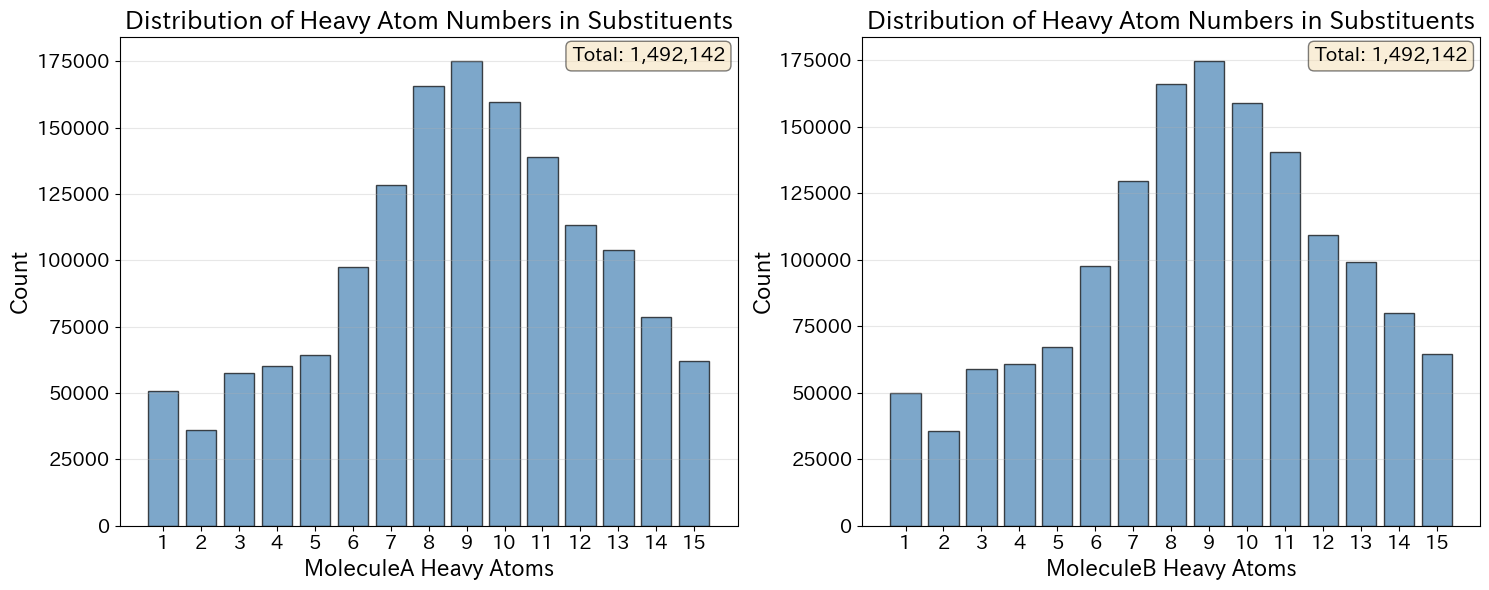

■ REF-FRAG_heavy と PRB-FRAG_heavy の分布を可視化しました


In [72]:
# REF-FRAG_heavy と PRB-FRAG_heavy の分布を可視化（離散値として）
frag_cols = ['REF-FRAG_heavy', 'PRB-FRAG_heavy']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()

for idx, col in enumerate(frag_cols):
    ax = axes[idx]
    
    # 各数値ごとの件数をカウント
    value_counts = df[col].value_counts().sort_index()
    
    # 棒グラフで表示
    ax.bar(value_counts.index, value_counts.values, alpha=0.7, edgecolor='black', color='steelblue')
    
    # x軸ラベルをMoleculeA/MoleculeBに変更
    xlabel = 'MoleculeA Heavy Atoms' if 'REF' in col else 'MoleculeB Heavy Atoms'
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_title(f'Distribution of Heavy Atom Numbers in Substituents', fontsize=18, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # x軸とy軸の目盛りのフォントサイズを大きく
    ax.tick_params(axis='both', labelsize=14)
    
    # 統計情報をテキストで追加
    mean_val = df[col].mean()
    median_val = df[col].median()
    std_val = df[col].std()
    total_count = len(df[col].dropna())
    
    stats_text = f'Total: {total_count:,}'
    ax.text(0.98, 0.98, stats_text, 
            transform=ax.transAxes, 
            fontsize=14,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # x軸の目盛りを整数に
    ax.set_xticks(value_counts.index)

plt.tight_layout()
plt.show()

print("■ REF-FRAG_heavy と PRB-FRAG_heavy の分布を可視化しました")

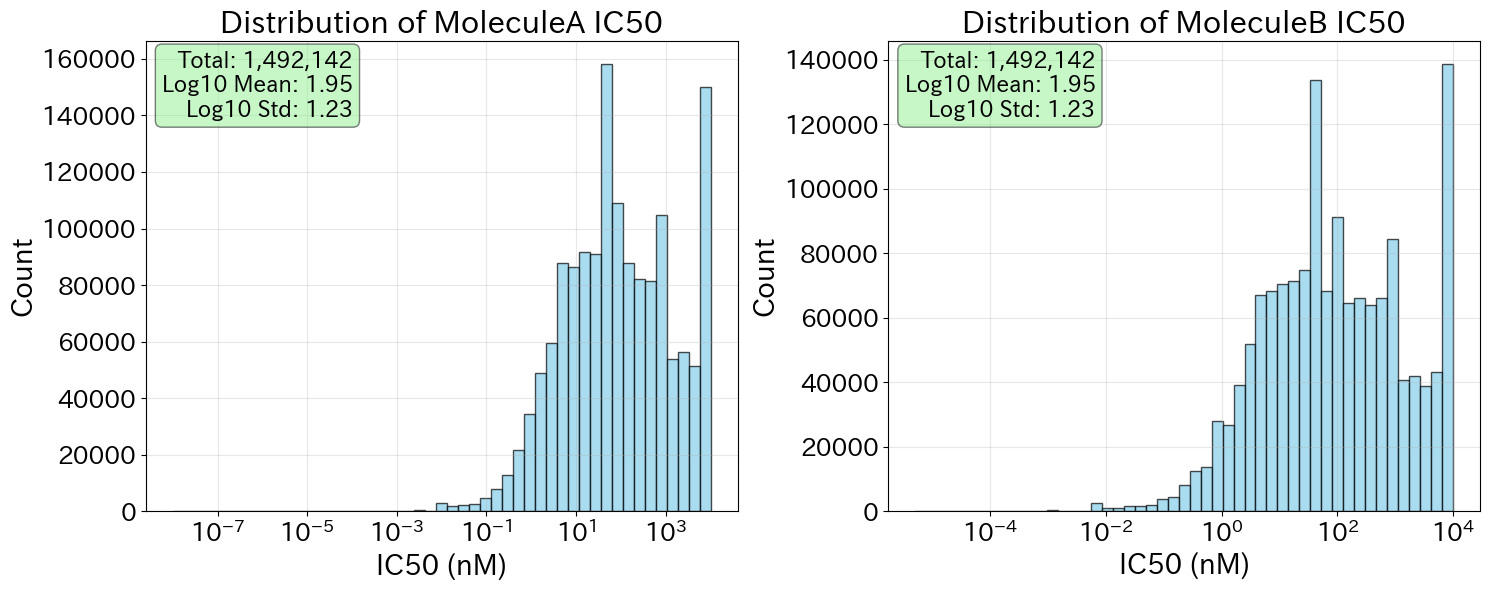

■ REF-standard_value と PRB-standard_value の分布を可視化しました（X軸: 対数スケール, Y軸: 通常スケール）


In [73]:
# REF-standard_value と PRB-standard_value の分布を可視化（横軸: 対数スケール、縦軸: 通常スケール）
numeric_cols = ['REF-standard_value', 'PRB-standard_value']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    
    # ヒストグラム（Countで表示）
    data = df[col].dropna()
    
    # 対数ビンを作成
    log_bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 50)
    ax.hist(data, bins=log_bins, alpha=0.7, edgecolor='black', color='skyblue')
    
    # 横軸を対数スケールに設定（縦軸は通常スケール）
    ax.set_xscale('log')
    
    # タイトルを変更
    title = 'MoleculeA IC50' if 'REF' in col else 'MoleculeB IC50'
    
    ax.set_xlabel('IC50 (nM)', fontsize=20)
    ax.set_ylabel('Count', fontsize=20)
    ax.set_title(f'Distribution of {title}', fontsize=22, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # x軸とy軸の目盛りのフォントサイズを大きく
    ax.tick_params(axis='both', labelsize=18)
    
    # 統計情報をテキストで追加（対数スケールでの統計も含む）
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    total_count = len(data)
    
    # 0より大きいデータのみで対数スケールの統計を計算
    data_positive = data[data > 0]
    if len(data_positive) > 0:
        log_data = np.log10(data_positive)
        log_mean = log_data.mean()
        log_std = log_data.std()
        stats_text = f'Total: {total_count:,}\nLog10 Mean: {log_mean:.2f}\nLog10 Std: {log_std:.2f}'
    else:
        stats_text = f'Total: {total_count:,}\nMean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {std_val:.2f}'
    
    ax.text(0.35, 0.98, stats_text, 
            transform=ax.transAxes, 
            fontsize=16,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

print("■ REF-standard_value と PRB-standard_value の分布を可視化しました（X軸: 対数スケール, Y軸: 通常スケール）")

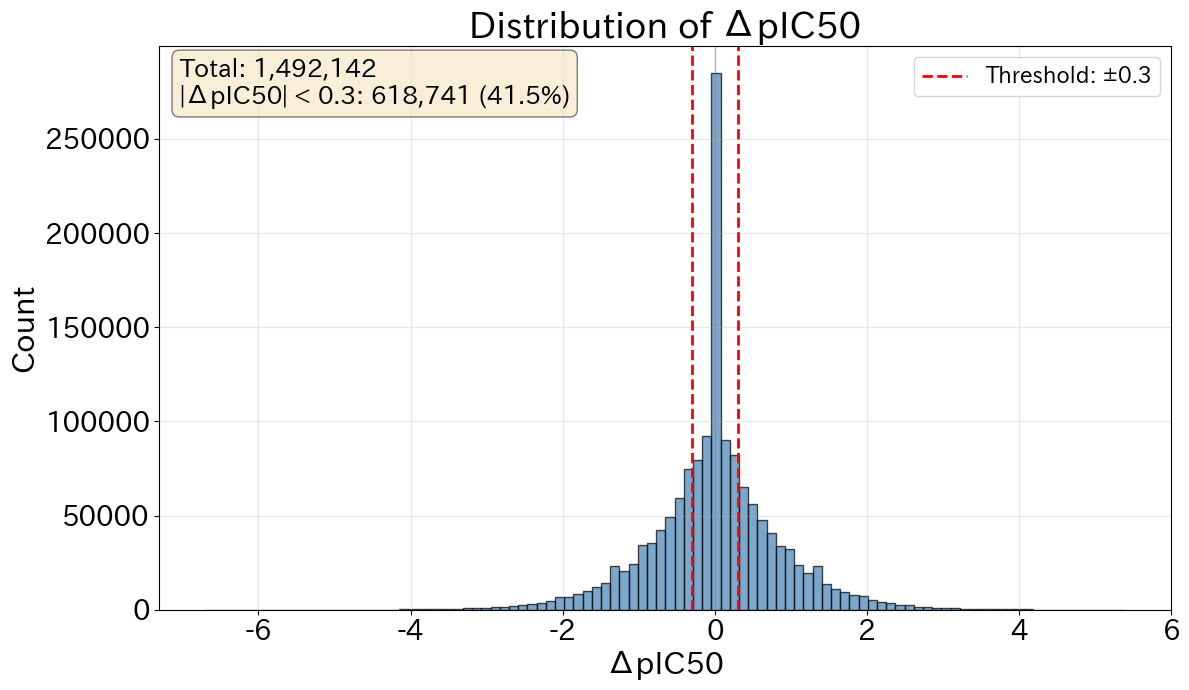

■ 全体のΔpIC50 (delta_value) の分布を可視化しました
  - 全データ数: 1,492,142 件
  - Bioisostere (|ΔpIC50| < 0.3): 618,741 件 (41.5%)
  - Non-bioisostere (|ΔpIC50| >= 0.3): 873,401 件 (58.5%)


In [74]:
# 全体のΔpIC50 (delta_value) の分布を可視化
delta_pIC50 = df['delta_value'].dropna()

fig, ax = plt.subplots(figsize=(12, 7))

# ヒストグラム
ax.hist(delta_pIC50, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
ax.axvline(x=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: ±0.3')
ax.axvline(x=-0.3, color='red', linestyle='--', linewidth=2)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

ax.set_xlabel('ΔpIC50', fontsize=22)
ax.set_ylabel('Count', fontsize=22)
ax.set_title('Distribution of ΔpIC50', fontsize=26, fontweight='bold')
ax.legend(fontsize=16)
ax.grid(True, alpha=0.3)

# 軸の目盛りのフォントサイズを大きく
ax.tick_params(axis='both', labelsize=20)

# 統計情報をテキストで追加
mean_val = delta_pIC50.mean()
median_val = delta_pIC50.median()
std_val = delta_pIC50.std()
total_count = len(delta_pIC50)
bioisostere_count = (delta_pIC50.abs() < 0.3).sum()
bioisostere_ratio = bioisostere_count / total_count * 100

stats_text = f'Total: {total_count:,}\n|ΔpIC50| < 0.3: {bioisostere_count:,} ({bioisostere_ratio:.1f}%)'
ax.text(0.02, 0.98, stats_text, 
        transform=ax.transAxes, 
        fontsize=18,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"■ 全体のΔpIC50 (delta_value) の分布を可視化しました")
print(f"  - 全データ数: {total_count:,} 件")
print(f"  - Bioisostere (|ΔpIC50| < 0.3): {bioisostere_count:,} 件 ({bioisostere_ratio:.1f}%)")
print(f"  - Non-bioisostere (|ΔpIC50| >= 0.3): {total_count - bioisostere_count:,} 件 ({100-bioisostere_ratio:.1f}%)")

In [75]:
# ユニークな値の確認
print("■ ユニークな値の数:")

# REF-SMILESとPRB-SMILESを合わせたユニーク分子数を計算
unique_molecules = pd.concat([df['REF-SMILES'], df['PRB-SMILES']]).nunique()
unique_fragments = pd.concat([df['REF-FRAG'], df['PRB-FRAG']]).nunique()

categorical_info = {
    'AID (Assay ID)': df['AID'].nunique(),
    'TID (Target ID)': df['TID'].nunique(),
    'CUT_NUM (切断番号)': df['CUT_NUM'].nunique(),
    'REF-SMILES': df['REF-SMILES'].nunique(),
    'PRB-SMILES': df['PRB-SMILES'].nunique(),
    'ユニーク分子数 (REF + PRB)': unique_molecules,
    'REF-FRAG': df['REF-FRAG'].nunique(),
    'PRB-FRAG': df['PRB-FRAG'].nunique(),
    'ユニークフラグメント数 (REF + PRB)': unique_fragments,
    'SMIRKS (変換パターン)': df['SMIRKS'].nunique(),
    'label_bin': df['label_bin'].nunique() if 'label_bin' in df.columns else 'N/A'
}

for key, value in categorical_info.items():
    print(f"  {key}: {value:,}")

■ ユニークな値の数:
  AID (Assay ID): 15,102
  TID (Target ID): 2,126
  CUT_NUM (切断番号): 3
  REF-SMILES: 116,696
  PRB-SMILES: 116,575
  ユニーク分子数 (REF + PRB): 137,567
  REF-FRAG: 65,330
  PRB-FRAG: 65,373
  ユニークフラグメント数 (REF + PRB): 79,500
  SMIRKS (変換パターン): 1,207,149
  label_bin: 2
  AID (Assay ID): 15,102
  TID (Target ID): 2,126
  CUT_NUM (切断番号): 3
  REF-SMILES: 116,696
  PRB-SMILES: 116,575
  ユニーク分子数 (REF + PRB): 137,567
  REF-FRAG: 65,330
  PRB-FRAG: 65,373
  ユニークフラグメント数 (REF + PRB): 79,500
  SMIRKS (変換パターン): 1,207,149
  label_bin: 2


In [76]:
# PRB-standard_valueが10000のデータの件数を確認
prb_10000_count = (df['PRB-standard_value'] == 10000).sum()
total_count = len(df)

print("■ PRB-standard_value = 10000 のデータ件数:")
print(f"  件数: {prb_10000_count:,} 件")
print(f"  割合: {prb_10000_count / total_count * 100:.2f}%")

# 同様にREF-standard_valueが10000のデータも確認
ref_10000_count = (df['REF-standard_value'] == 10000).sum()
print(f"\n■ REF-standard_value = 10000 のデータ件数:")
print(f"  件数: {ref_10000_count:,} 件")
print(f"  割合: {ref_10000_count / total_count * 100:.2f}%")

# 両方が10000のデータ
both_10000_count = ((df['REF-standard_value'] == 10000) & (df['PRB-standard_value'] == 10000)).sum()
print(f"\n■ REFとPRB両方が10000のデータ件数:")
print(f"  件数: {both_10000_count:,} 件")
print(f"  割合: {both_10000_count / total_count * 100:.2f}%")

■ PRB-standard_value = 10000 のデータ件数:
  件数: 103,970 件
  割合: 6.97%

■ REF-standard_value = 10000 のデータ件数:
  件数: 103,970 件
  割合: 6.97%

■ REFとPRB両方が10000のデータ件数:
  件数: 71,705 件
  割合: 4.81%


In [77]:
# PRB-standard_valueが1000以上のデータの件数を確認
prb_1000_count = (df['PRB-standard_value'] >= 1000).sum()
total_count = len(df)
print("■ PRB-standard_value >= 1000 のデータ件数:")
print(f"  件数: {prb_1000_count:,} 件")
print(f"  割合: {prb_1000_count / total_count * 100:.2f}%")

# PRB-standard_valueが1000以上のデータの件数を確認
prb_1000_count = (df['PRB-standard_value'] >= 1000).sum()
total_count = len(df)
print("■ PRB-standard_value >= 1000 のデータ件数:")
print(f"  件数: {prb_1000_count:,} 件")
print(f"  割合: {prb_1000_count / total_count * 100:.2f}%") 

# 両方が1000以上のデータ
both_1000_count = ((df['REF-standard_value'] >= 1000) & (df['PRB-standard_value'] >= 1000)).sum()
print(f"\n■ REFとPRB両方が1000以上のデータ件数:")
print(f"  件数: {both_1000_count:,} 件")
print(f"  割合: {both_1000_count / total_count * 100:.2f}%")

■ PRB-standard_value >= 1000 のデータ件数:
  件数: 351,315 件
  割合: 23.54%
■ PRB-standard_value >= 1000 のデータ件数:
  件数: 351,315 件
  割合: 23.54%

■ REFとPRB両方が1000以上のデータ件数:
  件数: 242,249 件
  割合: 16.23%


## 3. ΔpIC50の分布とノイズ評価

### 3.1 ΔpIC50 (delta_value) の分布

In [78]:
# delta_valueの分布を詳細に確認
print("■ Statistics of ΔpIC50 (delta_value):")
print(df['delta_value'].describe())
print(f"\nMissing values: {df['delta_value'].isna().sum()} samples")
print(f"\nMedian: {df['delta_value'].median():.3f}")
print(f"Standard deviation: {df['delta_value'].std():.3f}")
print(f"Interquartile range (IQR): {df['delta_value'].quantile(0.75) - df['delta_value'].quantile(0.25):.3f}")

# 閾値0.3との関係
print(f"\n■ Relationship with threshold 0.3:")
print(f"|ΔpIC50| < 0.3: {(df['delta_value'].abs() < 0.3).sum():,} samples ({(df['delta_value'].abs() < 0.3).sum() / len(df) * 100:.1f}%)")
print(f"|ΔpIC50| ≥ 0.3: {(df['delta_value'].abs() >= 0.3).sum():,} samples ({(df['delta_value'].abs() >= 0.3).sum() / len(df) * 100:.1f}%)")

■ Statistics of ΔpIC50 (delta_value):
count    1.492142e+06
mean    -6.530077e-03
std      8.597270e-01
min     -6.698970e+00
25%     -4.043485e-01
50%      0.000000e+00
75%      3.979400e-01
max      5.397940e+00
Name: delta_value, dtype: float64

Missing values: 0 samples

Median: 0.000
Standard deviation: 0.860
Interquartile range (IQR): 0.802

■ Relationship with threshold 0.3:
|ΔpIC50| < 0.3: 618,741 samples (41.5%)
|ΔpIC50| ≥ 0.3: 873,401 samples (58.5%)


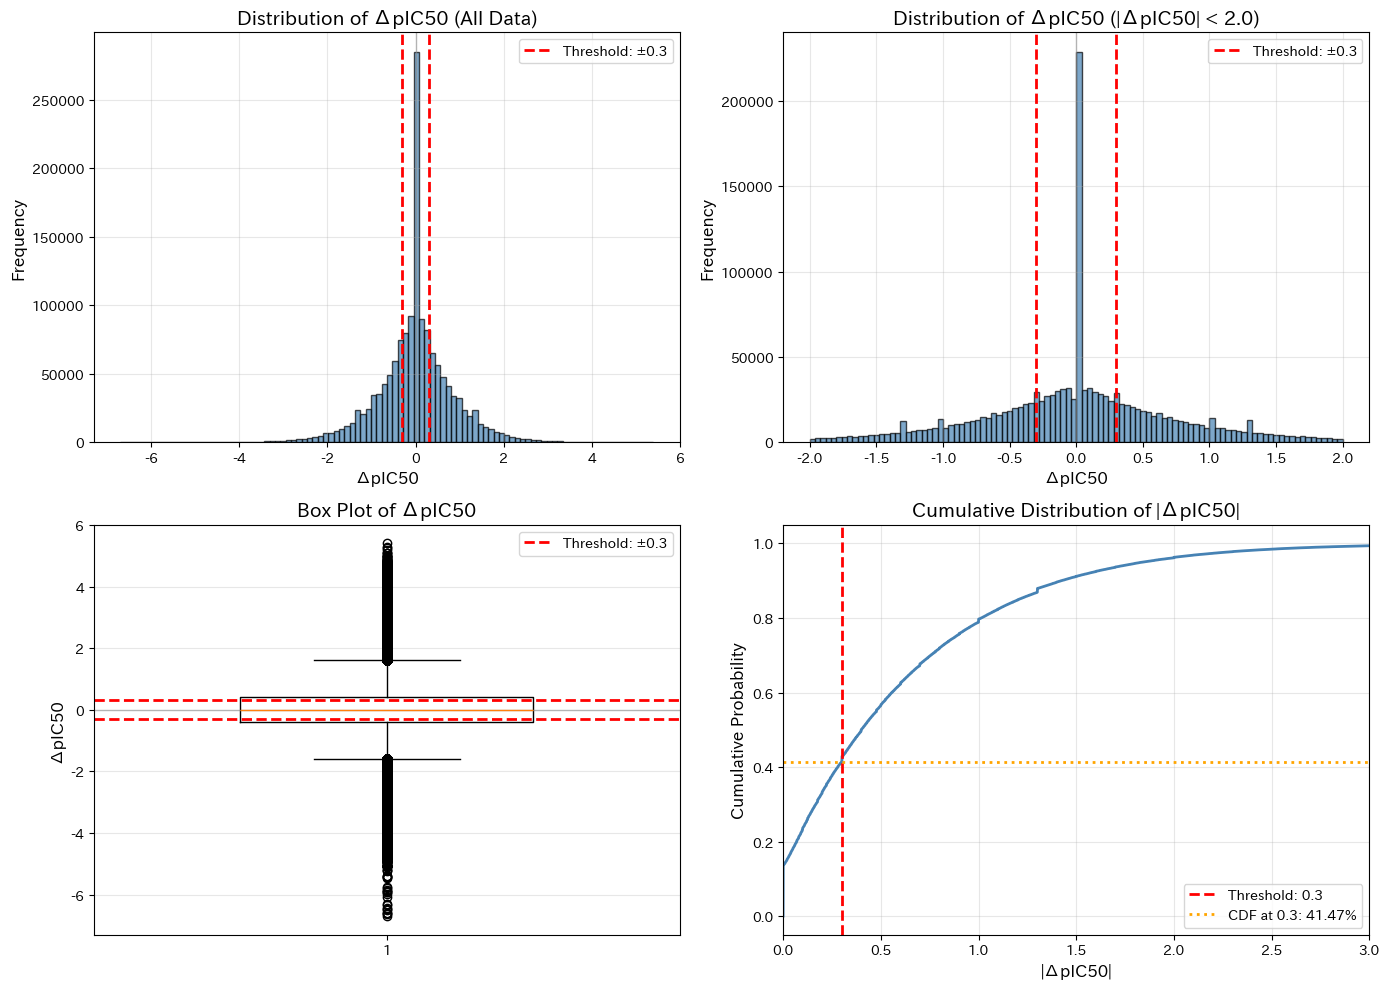

■ Figure 1: Distribution of ΔpIC50 (analyzed from 4 perspectives)


In [79]:
#pIC50の分布を可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ヒストグラム (全体)
axes[0, 0].hist(df['delta_value'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(x=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: ±0.3')
axes[0, 0].axvline(x=-0.3, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
axes[0, 0].set_xlabel('ΔpIC50', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of ΔpIC50 (All Data)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. ヒストグラム (|ΔpIC50| < 2.0にズーム)
df_zoom = df[df['delta_value'].abs() < 2.0]
axes[0, 1].hist(df_zoom['delta_value'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 1].axvline(x=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: ±0.3')
axes[0, 1].axvline(x=-0.3, color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
axes[0, 1].set_xlabel('ΔpIC50', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of ΔpIC50 (|ΔpIC50| < 2.0)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 箱ひげ図
axes[1, 0].boxplot([df['delta_value']], vert=True, widths=0.5)
axes[1, 0].axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: ±0.3')
axes[1, 0].axhline(y=-0.3, color='red', linestyle='--', linewidth=2)
axes[1, 0].axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
axes[1, 0].set_ylabel('ΔpIC50', fontsize=12)
axes[1, 0].set_title('Box Plot of ΔpIC50', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. 累積分布関数 (CDF)
sorted_delta = np.sort(df['delta_value'].abs())
cdf = np.arange(1, len(sorted_delta) + 1) / len(sorted_delta)
axes[1, 1].plot(sorted_delta, cdf, linewidth=2, color='steelblue')
axes[1, 1].axvline(x=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: 0.3')
axes[1, 1].axhline(y=(df['delta_value'].abs() < 0.3).sum() / len(df), 
                   color='orange', linestyle=':', linewidth=2, 
                   label=f'CDF at 0.3: {(df["delta_value"].abs() < 0.3).sum() / len(df):.2%}')
axes[1, 1].set_xlabel('|ΔpIC50|', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].set_title('Cumulative Distribution of |ΔpIC50|', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 3)

plt.tight_layout()
plt.show()

print("■ Figure 1: Distribution of ΔpIC50 (analyzed from 4 perspectives)")

In [80]:
#all dataのpIC50だけ別で可視化


### 3.2 実験ノイズのスケール評価

In [81]:
# 実験ノイズのスケール評価
# |ΔpIC50| < 0.3のデータを「ノイズレベル」と仮定して統計を算出
noise_data = df[df['delta_value'].abs() < 0.3]['delta_value']

print("■ Experimental Noise Scale Evaluation (data with |ΔpIC50| < 0.3):")
print(f"Sample size: {len(noise_data):,} samples")
print(f"Mean: {noise_data.mean():.4f}")
print(f"Median: {noise_data.median():.4f}")
print(f"Standard deviation: {noise_data.std():.4f}")
print(f"95% confidence interval: [{noise_data.quantile(0.025):.4f}, {noise_data.quantile(0.975):.4f}]")

# 閾値0.3と標準偏差の関係
print(f"\n■ Relationship between threshold 0.3 and standard deviation:")
print(f"Overall standard deviation: {df['delta_value'].std():.4f}")
print(f"Noise-level standard deviation: {noise_data.std():.4f}")
print(f"Threshold 0.3 is {0.3 / df['delta_value'].std():.2f}× the overall std")
print(f"Threshold 0.3 is {0.3 / noise_data.std():.2f}× the noise-level std")

■ Experimental Noise Scale Evaluation (data with |ΔpIC50| < 0.3):
Sample size: 618,741 samples
Mean: -0.0001
Median: 0.0000
Standard deviation: 0.1365
95% confidence interval: [-0.2711, 0.2708]

■ Relationship between threshold 0.3 and standard deviation:
Overall standard deviation: 0.8597
Noise-level standard deviation: 0.1365
Threshold 0.3 is 0.35× the overall std
Threshold 0.3 is 2.20× the noise-level std


### 3.3 ΔpIC50 = 0.0 の詳細分析

In [82]:
# ΔpIC50 = 0.0 のサンプルを抽出して分析
df_zero = df[df['delta_value'] == 0.0]

print("■ ΔpIC50 = 0.0 Analysis:")
print(f"Total samples with ΔpIC50 = 0.0: {len(df_zero):,} samples")
print(f"Percentage: {len(df_zero)/len(df)*100:.2f}% of all data")

# REF-SMILESとPRB-SMILESが同一かチェック
identical_smiles = (df_zero['REF-SMILES'] == df_zero['PRB-SMILES']).sum()
print(f"\n■ SMILES comparison:")
print(f"Identical SMILES (REF == PRB): {identical_smiles:,} samples ({identical_smiles/len(df_zero)*100:.2f}%)")
print(f"Different SMILES (REF != PRB): {len(df_zero) - identical_smiles:,} samples ({(len(df_zero) - identical_smiles)/len(df_zero)*100:.2f}%)")

# REF-CIDとPRB-CIDが同一かチェック
identical_cid = (df_zero['REF-CID'] == df_zero['PRB-CID']).sum()
print(f"\n■ Compound ID comparison:")
print(f"Identical CID (REF == PRB): {identical_cid:,} samples ({identical_cid/len(df_zero)*100:.2f}%)")
print(f"Different CID (REF != PRB): {len(df_zero) - identical_cid:,} samples ({(len(df_zero) - identical_cid)/len(df_zero)*100:.2f}%)")

# pIC50値を確認
print(f"\n■ pIC50 values for ΔpIC50 = 0.0:")
print(f"REF-standard_value statistics:")
print(df_zero['REF-standard_value'].describe())
print(f"\nPRB-standard_value statistics:")
print(df_zero['PRB-standard_value'].describe())

# REFとPRBのpIC50値の差を再計算して確認
recalc_delta = df_zero['PRB-standard_value'] - df_zero['REF-standard_value']
print(f"\n■ Recalculated delta (PRB - REF):")
print(f"Min: {recalc_delta.min():.6f}")
print(f"Max: {recalc_delta.max():.6f}")
print(f"Mean: {recalc_delta.mean():.6f}")
print(f"Std: {recalc_delta.std():.6f}")

# 完全に同一の値の割合
truly_identical = (df_zero['REF-standard_value'] == df_zero['PRB-standard_value']).sum()
print(f"\nTruly identical pIC50 values: {truly_identical:,} samples ({truly_identical/len(df_zero)*100:.2f}%)")

■ ΔpIC50 = 0.0 Analysis:
Total samples with ΔpIC50 = 0.0: 203,968 samples
Percentage: 13.67% of all data

■ SMILES comparison:
Identical SMILES (REF == PRB): 1 samples (0.00%)
Different SMILES (REF != PRB): 203,967 samples (100.00%)

■ Compound ID comparison:
Identical CID (REF == PRB): 0 samples (0.00%)
Different CID (REF != PRB): 203,968 samples (100.00%)

■ pIC50 values for ΔpIC50 = 0.0:
REF-standard_value statistics:
count    203968.000000
mean       3796.380649
std        4663.399920
min           0.000005
25%          50.000000
50%         100.000000
75%       10000.000000
max       10000.000000
Name: REF-standard_value, dtype: float64

PRB-standard_value statistics:
count    203968.000000
mean       3796.380649
std        4663.399920
min           0.000005
25%          50.000000
50%         100.000000
75%       10000.000000
max       10000.000000
Name: PRB-standard_value, dtype: float64

■ Recalculated delta (PRB - REF):
Min: 0.000000
Max: 0.000000
Mean: 0.000000
Std: 0.000000



In [83]:
# ΔpIC50 = 0.0 のフラグメント分析
print("■ Fragment analysis for ΔpIC50 = 0.0:")

# REF-FRAGとPRB-FRAGが同一かチェック
identical_frag = (df_zero['REF-FRAG'] == df_zero['PRB-FRAG']).sum()
print(f"Identical fragments (REF-FRAG == PRB-FRAG): {identical_frag:,} samples ({identical_frag/len(df_zero)*100:.2f}%)")
print(f"Different fragments: {len(df_zero) - identical_frag:,} samples ({(len(df_zero) - identical_frag)/len(df_zero)*100:.2f}%)")

# SMIRKS分析
print(f"\n■ SMIRKS patterns for ΔpIC50 = 0.0:")
smirks_zero_counts = df_zero['SMIRKS'].value_counts()
print(f"Unique SMIRKS patterns: {len(smirks_zero_counts):,} types")
print(f"\nTop 10 SMIRKS patterns:")
for i, (smirks, count) in enumerate(smirks_zero_counts.head(10).items(), 1):
    print(f"  {i}. Count: {count:4,} - {smirks[:80]}{'...' if len(smirks) > 80 else ''}")

# ターゲット分析
print(f"\n■ Target distribution for ΔpIC50 = 0.0:")
target_zero_counts = df_zero['TID'].value_counts()
print(f"Unique targets (TID): {len(target_zero_counts):,}")
print(f"Top 5 targets:")
for i, (tid, count) in enumerate(target_zero_counts.head(5).items(), 1):
    print(f"  {i}. TID {tid}: {count:,} samples ({count/len(df_zero)*100:.1f}%)")

■ Fragment analysis for ΔpIC50 = 0.0:
Identical fragments (REF-FRAG == PRB-FRAG): 0 samples (0.00%)
Different fragments: 203,968 samples (100.00%)

■ SMIRKS patterns for ΔpIC50 = 0.0:
Unique SMIRKS patterns: 160,009 types

Top 10 SMIRKS patterns:
  1. Count:   13 - [*C.*Cc1cc2c(Nc3cccc(Cl)c3F)ncnc2cc1OC.*N(*)C]>>[*C(*)C(N)=O]|[*C(=O)[C@H]1CCCN1...
  2. Count:   13 - [*C(N)=O.*N(C)Cc1cc2c(Nc3cccc(Cl)c3F)ncnc2cc1OC]>>[*C(*)C]|[*C*]
  3. Count:   13 - [*C.*C(N)=O.*N(C)Cc1cc2c(Nc3cccc(Cl)c3F)ncnc2cc1OC]>>[*C(*)*]|[*OCCN1CC(*)(*)C1]
  4. Count:   12 - [*COc1cccc(-c2cn([C@H]3C[C@@H](CN4CCC4)C3)c3ncnc(N)c23)c1]>>[*[C@@H]1CCCO1]|[*C1...
  5. Count:   12 - [*C.*C(N)=O.*N(C)Cc1cc2c(Nc3cccc(Cl)c3F)ncnc2cc1OC]>>[*C(*)*]|[*N1CC(*)(*)C1]
  6. Count:   12 - [*C.*C(N)=O.*N(C)Cc1cc2c(Nc3cccc(Cl)c3F)ncnc2cc1OC]>>[*C(*)*]|[*N1CCC(*)(*)CC1]
  7. Count:   11 - [*Oc1cccc(-c2cn([C@H]3C[C@@H](CN4CCC4)C3)c3ncnc(N)c23)c1]>>[*C[C@@H]1CCCO1]|[*Cc...
  8. Count:   11 - [*C.*C(N)=O.*N(C)Cc1cc2c(Nc3cccc(Cl)c3F)ncnc2

■ Structure visualization for ΔpIC50 = 0.0 samples (first 10 pairs)

★ Different SMILES but ΔpIC50 = 0.0 (first 5 pairs):

--- Pair 1 ---
REF-CID: CHEMBL311378, PRB-CID: CHEMBL81623
REF pIC50: 1000.0000, PRB pIC50: 1000.0000, Δ: 0.000000
REF-SMILES: CCCN1CCC(c2cccnc2)C1
PRB-SMILES: CCCN1CCC(C2CCCCC2)C1
Identical: False


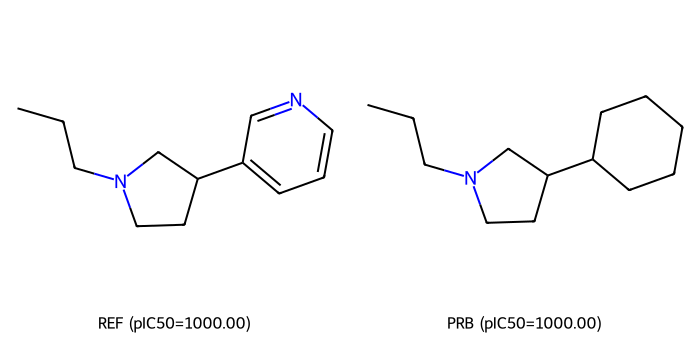

--------------------------------------------------------------------------------

--- Pair 2 ---
REF-CID: CHEMBL333089, PRB-CID: CHEMBL117633
REF pIC50: 170.0000, PRB pIC50: 170.0000, Δ: 0.000000
REF-SMILES: CC(=O)Nc1cccc(CCN2CCN(CCCc3c[nH]c4ccc(-n5cnnc5)cc34)CC2)c1
PRB-SMILES: c1ccc(CCN2CCN(CCCc3c[nH]c4ccc(-n5cnnc5)cc34)CC2)cc1
Identical: False


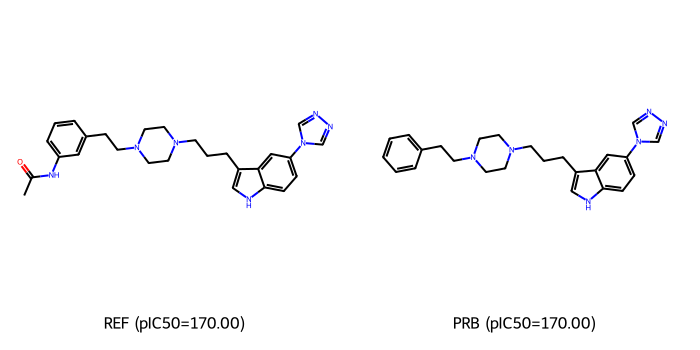

--------------------------------------------------------------------------------

--- Pair 3 ---
REF-CID: CHEMBL91534, PRB-CID: CHEMBL304857
REF pIC50: 2.2000, PRB pIC50: 2.2000, Δ: 0.000000
REF-SMILES: CN(Cc1ccccc1)[C@H]1CCN(CCCc2c[nH]c3ccc(-n4cnnc4)cc23)C[C@H]1F
PRB-SMILES: CN(Cc1ccccc1)C1CCN(CCCc2c[nH]c3ccc(-n4cnnc4)cc23)CC1
Identical: False


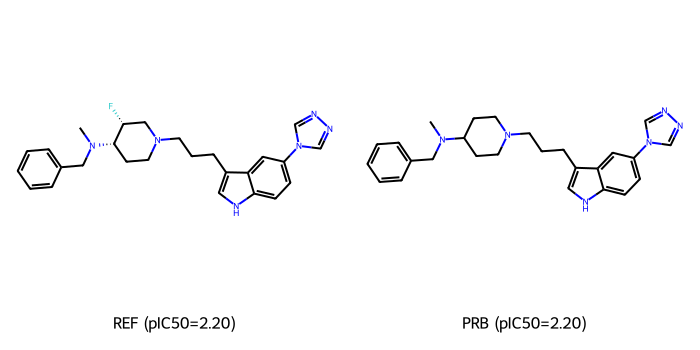

--------------------------------------------------------------------------------

--- Pair 4 ---
REF-CID: CHEMBL22553, PRB-CID: CHEMBL278610
REF pIC50: 1000.0000, PRB pIC50: 1000.0000, Δ: 0.000000
REF-SMILES: NC(=O)c1ccc2[nH]cc(C3=CCC(NCCNC4CC=C(c5c[nH]c6ccc(C(N)=O)cc56)CC4)CC3)c2c1
PRB-SMILES: NC(=O)c1ccc2[nH]cc(C3=CCC(NCCCNC4CC=C(c5c[nH]c6ccc(C(N)=O)cc56)CC4)CC3)c2c1
Identical: False


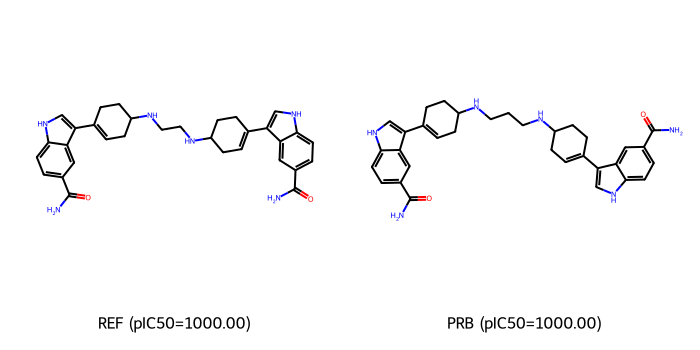

--------------------------------------------------------------------------------

--- Pair 5 ---
REF-CID: CHEMBL22553, PRB-CID: CHEMBL17828
REF pIC50: 1000.0000, PRB pIC50: 1000.0000, Δ: 0.000000
REF-SMILES: NC(=O)c1ccc2[nH]cc(C3=CCC(NCCNC4CC=C(c5c[nH]c6ccc(C(N)=O)cc56)CC4)CC3)c2c1
PRB-SMILES: NC(=O)c1ccc2[nH]cc(C3=CCC(NCCCCCNC4CC=C(c5c[nH]c6ccc(C(N)=O)cc56)CC4)CC3)c2c1
Identical: False


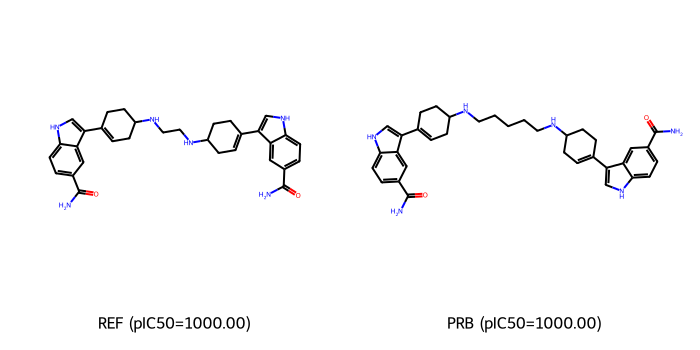

--------------------------------------------------------------------------------


In [84]:
# ΔpIC50 = 0.0 の構造を可視化（サンプル）
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

print("■ Structure visualization for ΔpIC50 = 0.0 samples (first 10 pairs)")
print("="*80)

# 異なるSMILESを持つΔ=0.0のサンプルを優先的に表示
df_zero_diff = df_zero[df_zero['REF-SMILES'] != df_zero['PRB-SMILES']]

if len(df_zero_diff) > 0:
    print(f"\n★ Different SMILES but ΔpIC50 = 0.0 (first 5 pairs):")
    sample_df = df_zero_diff.head(5)
else:
    print(f"\n★ Random samples with ΔpIC50 = 0.0 (first 5 pairs):")
    sample_df = df_zero.head(5)

for idx, (index, row) in enumerate(sample_df.iterrows(), 1):
    ref_smiles = row['REF-SMILES']
    prb_smiles = row['PRB-SMILES']
    ref_value = row['REF-standard_value']
    prb_value = row['PRB-standard_value']
    ref_cid = row['REF-CID']
    prb_cid = row['PRB-CID']
    
    print(f"\n--- Pair {idx} ---")
    print(f"REF-CID: {ref_cid}, PRB-CID: {prb_cid}")
    print(f"REF pIC50: {ref_value:.4f}, PRB pIC50: {prb_value:.4f}, Δ: {prb_value - ref_value:.6f}")
    print(f"REF-SMILES: {ref_smiles[:80]}{'...' if len(ref_smiles) > 80 else ''}")
    print(f"PRB-SMILES: {prb_smiles[:80]}{'...' if len(prb_smiles) > 80 else ''}")
    print(f"Identical: {ref_smiles == prb_smiles}")
    
    # 構造を可視化
    mols = []
    legends = []
    
    try:
        mol_ref = Chem.MolFromSmiles(ref_smiles)
        if mol_ref:
            mols.append(mol_ref)
            legends.append(f"REF (pIC50={ref_value:.2f})")
    except:
        pass
    
    try:
        mol_prb = Chem.MolFromSmiles(prb_smiles)
        if mol_prb:
            mols.append(mol_prb)
            legends.append(f"PRB (pIC50={prb_value:.2f})")
    except:
        pass
    
    if len(mols) >= 1:
        if len(mols) == 2 and ref_smiles != prb_smiles:
            img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(350, 350), legends=legends)
        else:
            img = Draw.MolsToGridImage([mols[0]], molsPerRow=1, subImgSize=(350, 350), legends=[legends[0]])
        display(img)
    
    print("-"*80)

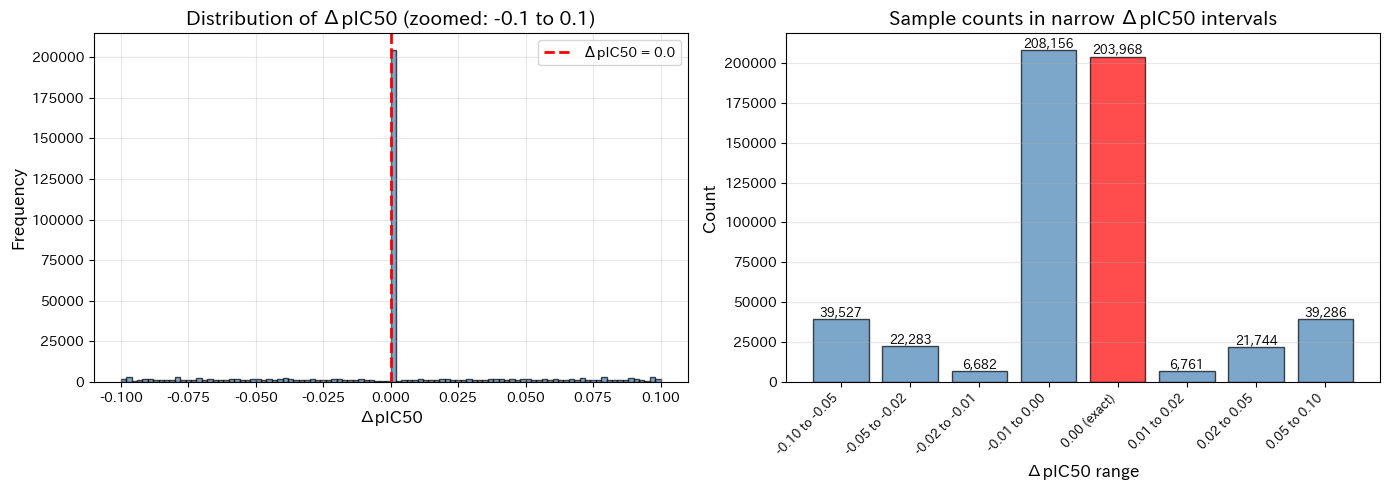


■ Analysis of near-zero ΔpIC50:
Exact 0.0: 203,968 samples (13.67%)
-0.01 < Δ < 0.01 (excluding 0.0): 8,361 samples
-0.02 < Δ < 0.02 (excluding 0.0): 21,804 samples


In [85]:
# ΔpIC50の分布をより詳細に確認（0.0付近を拡大）
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. ΔpIC50のヒストグラム（-0.1 ~ 0.1の範囲）
df_near_zero = df[(df['delta_value'] >= -0.1) & (df['delta_value'] <= 0.1)]
axes[0].hist(df_near_zero['delta_value'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='ΔpIC50 = 0.0')
axes[0].set_xlabel('ΔpIC50', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of ΔpIC50 (zoomed: -0.1 to 0.1)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. ΔpIC50 = 0.0 の割合を他の小区間と比較
bins = [-0.1, -0.05, -0.02, -0.01, 0.0, 0.01, 0.02, 0.05, 0.1]
bin_labels = [f'{bins[i]:.2f} to {bins[i+1]:.2f}' for i in range(len(bins)-1)]
bin_labels[4] = '0.00 (exact)'  # ΔpIC50 = 0.0 を強調

# 各区間のカウント
counts = []
for i in range(len(bins)-1):
    if i == 4:  # ΔpIC50 = 0.0
        count = (df['delta_value'] == 0.0).sum()
    else:
        count = ((df['delta_value'] > bins[i]) & (df['delta_value'] <= bins[i+1])).sum()
    counts.append(count)

axes[1].bar(range(len(counts)), counts, alpha=0.7, edgecolor='black', 
            color=['steelblue' if i != 4 else 'red' for i in range(len(counts))])
axes[1].set_xlabel('ΔpIC50 range', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Sample counts in narrow ΔpIC50 intervals', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(counts)))
axes[1].set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')

# 各バーの上に数値を表示
for i, count in enumerate(counts):
    axes[1].text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n■ Analysis of near-zero ΔpIC50:")
print(f"Exact 0.0: {(df['delta_value'] == 0.0).sum():,} samples ({(df['delta_value'] == 0.0).sum()/len(df)*100:.2f}%)")
print(f"-0.01 < Δ < 0.01 (excluding 0.0): {((df['delta_value'].abs() < 0.01) & (df['delta_value'] != 0.0)).sum():,} samples")
print(f"-0.02 < Δ < 0.02 (excluding 0.0): {((df['delta_value'].abs() < 0.02) & (df['delta_value'] != 0.0)).sum():,} samples")

## 4. 変換ごとのサンプル数の集計



### 4.1 フラグメントペア (順不同) ごとのサンプル数

In [86]:
# フラグメント番号を正規化する関数 (exp.ipynbと同様)
import re

def remove_attachment_numbers(frag):
    """
    フラグメント文字列から結合位置の数字を削除する
    例: [10*]C -> [*]C, [11*]C -> [*]C
    """
    if pd.isna(frag):
        return frag
    # [数字*] を [*] に置き換え
    normalized = re.sub(r'\[(\d+)\*\]', '[*]', frag)
    return normalized

# フラグメントを正規化
print("■ Normalizing fragments...")
df['REF-FRAG-NORM'] = df['REF-FRAG'].apply(remove_attachment_numbers)
df['PRB-FRAG-NORM'] = df['PRB-FRAG'].apply(remove_attachment_numbers)
print("Completed.")

# 順不同(順序を無視)でREF-FRAGとPRB-FRAGの組をカウント
# 各行でREF-FRAGとPRB-FRAGをソートして、常に小さい方を先にする
df['FRAG_PAIR'] = df.apply(
    lambda row: tuple(sorted([row['REF-FRAG-NORM'], row['PRB-FRAG-NORM']])), 
    axis=1
)

# ソート済みのペアでグループ化
grouped_counts_unordered = df.groupby('FRAG_PAIR').size().reset_index(name='count')
grouped_counts_unordered = grouped_counts_unordered.sort_values('count', ascending=False)

print("\n■ Sample count statistics for fragment pairs (unordered):")
print(f"Total unique fragment pairs: {len(grouped_counts_unordered):,} types")
print(f"\nSample count statistics:")
print(grouped_counts_unordered['count'].describe())

# サンプル数の分布
print(f"\n■ Distribution of sample counts:")
thresholds = [1, 2, 3, 5, 10, 20, 50, 100]
for threshold in thresholds:
    count = (grouped_counts_unordered['count'] >= threshold).sum()
    print(f"n ≥ {threshold:3d}: {count:5,} types ({count/len(grouped_counts_unordered)*100:5.1f}%)")

■ Normalizing fragments...


Completed.

■ Sample count statistics for fragment pairs (unordered):
Total unique fragment pairs: 711,605 types

Sample count statistics:
count    711605.000000
mean          2.096868
std          11.839076
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        5131.000000
Name: count, dtype: float64

■ Distribution of sample counts:
n ≥   1: 711,605 types (100.0%)
n ≥   2: 263,550 types ( 37.0%)
n ≥   3: 150,698 types ( 21.2%)
n ≥   5: 30,693 types (  4.3%)
n ≥  10: 8,787 types (  1.2%)
n ≥  20: 3,114 types (  0.4%)
n ≥  50:   924 types (  0.1%)
n ≥ 100:   365 types (  0.1%)

■ Sample count statistics for fragment pairs (unordered):
Total unique fragment pairs: 711,605 types

Sample count statistics:
count    711605.000000
mean          2.096868
std          11.839076
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        5131.000000
Name: count, dtype: float64

■ Distribution of sample co

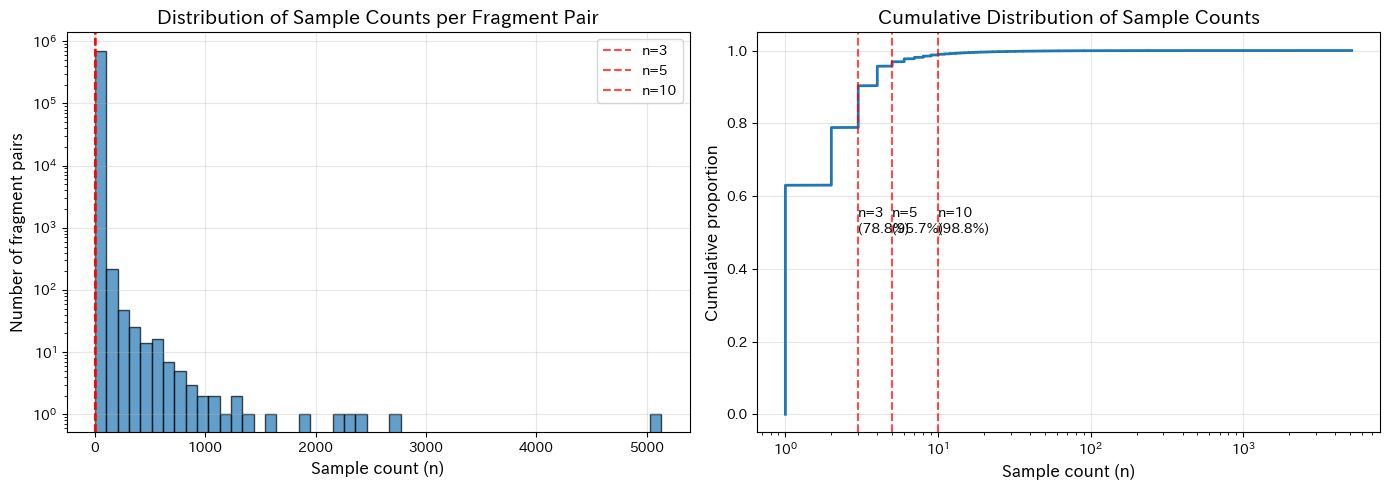


■ Number of fragment pairs at each threshold:
n ≥  3: 150,698 types ( 21.2%)
n <   3: 560,907 types ( 78.8%)

n ≥  5: 30,693 types (  4.3%)
n <   5: 680,912 types ( 95.7%)

n ≥ 10: 8,787 types (  1.2%)
n <  10: 702,818 types ( 98.8%)

n ≥ 20: 3,114 types (  0.4%)
n <  20: 708,491 types ( 99.6%)



In [87]:
# サンプル数の分布を可視化
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: ヒストグラム (対数スケール)
axes[0].hist(grouped_counts_unordered['count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sample count (n)', fontsize=12)
axes[0].set_ylabel('Number of fragment pairs', fontsize=12)
axes[0].set_title('Distribution of Sample Counts per Fragment Pair', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# 垂直線: 閾値
for threshold in [3, 5, 10]:
    axes[0].axvline(x=threshold, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'n={threshold}')
axes[0].legend()

# 右: 累積分布 (CDF)
sorted_counts = np.sort(grouped_counts_unordered['count'].values)
cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)

axes[1].plot(sorted_counts, cdf, linewidth=2)
axes[1].set_xlabel('Sample count (n)', fontsize=12)
axes[1].set_ylabel('Cumulative proportion', fontsize=12)
axes[1].set_title('Cumulative Distribution of Sample Counts', fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

# 閾値の位置を示す
for threshold in [3, 5, 10]:
    cdf_val = (sorted_counts < threshold).sum() / len(sorted_counts)
    axes[1].axvline(x=threshold, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axes[1].text(threshold, 0.5, f'n={threshold}\n({cdf_val*100:.1f}%)', 
                 rotation=0, ha='left', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n■ Number of fragment pairs at each threshold:")
for threshold in [3, 5, 10, 20]:
    count_above = (grouped_counts_unordered['count'] >= threshold).sum()
    count_below = (grouped_counts_unordered['count'] < threshold).sum()
    print(f"n ≥ {threshold:2d}: {count_above:5,} types ({count_above/len(grouped_counts_unordered)*100:5.1f}%)")
    print(f"n <  {threshold:2d}: {count_below:5,} types ({count_below/len(grouped_counts_unordered)*100:5.1f}%)")
    print()

### 4.2 高頻度フラグメントペアの可視化 (Top 10)

■ Structure visualization of Top 10 most frequent fragment pairs

Pair 1: Occurrence = 5,131 samples
  Positive (label=True):  2,822 samples ( 55.0%)
  Negative (label=False): 2,309 samples ( 45.0%)
REF-FRAG: *C
PRB-FRAG: *CC


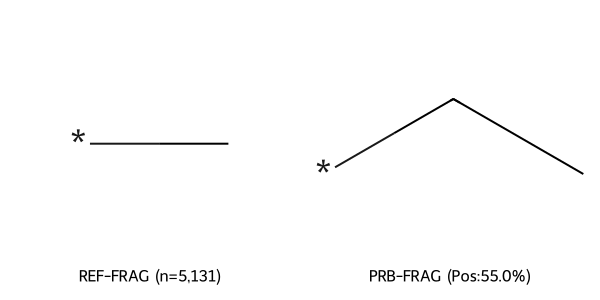

--------------------------------------------------------------------------------

Pair 2: Occurrence = 2,669 samples
  Positive (label=True):  1,237 samples ( 46.3%)
  Negative (label=False): 1,432 samples ( 53.7%)
REF-FRAG: *C
PRB-FRAG: *C(C)C


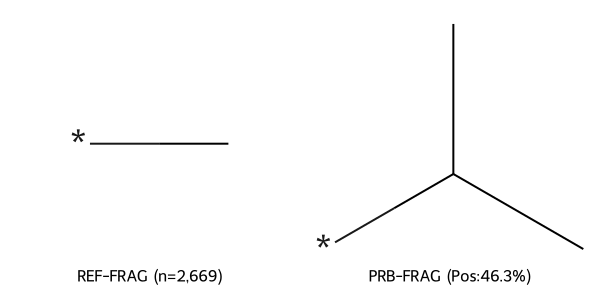

--------------------------------------------------------------------------------

Pair 3: Occurrence = 2,411 samples
  Positive (label=True):  1,343 samples ( 55.7%)
  Negative (label=False): 1,068 samples ( 44.3%)
REF-FRAG: *CC*
PRB-FRAG: *CCC*

Pair 3: Occurrence = 2,411 samples
  Positive (label=True):  1,343 samples ( 55.7%)
  Negative (label=False): 1,068 samples ( 44.3%)
REF-FRAG: *CC*
PRB-FRAG: *CCC*


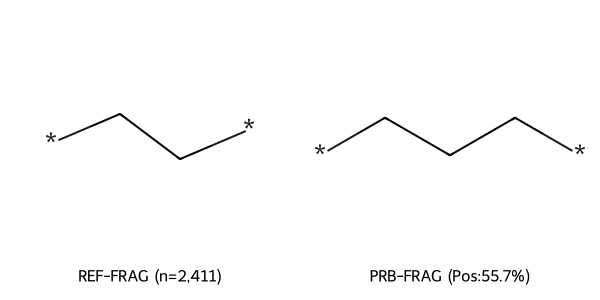

--------------------------------------------------------------------------------

Pair 4: Occurrence = 2,336 samples
  Positive (label=True):  1,261 samples ( 54.0%)
  Negative (label=False): 1,075 samples ( 46.0%)
REF-FRAG: *C*
PRB-FRAG: *CC*

Pair 4: Occurrence = 2,336 samples
  Positive (label=True):  1,261 samples ( 54.0%)
  Negative (label=False): 1,075 samples ( 46.0%)
REF-FRAG: *C*
PRB-FRAG: *CC*


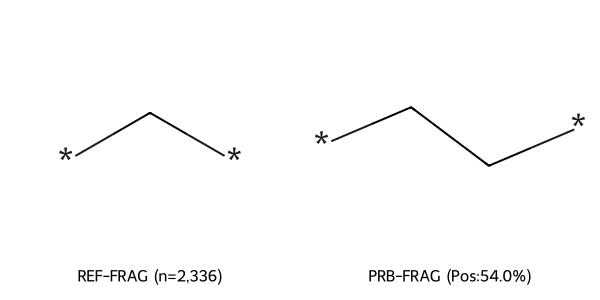

--------------------------------------------------------------------------------

Pair 5: Occurrence = 2,195 samples
  Positive (label=True):  1,152 samples ( 52.5%)
  Negative (label=False): 1,043 samples ( 47.5%)
REF-FRAG: *C(*)C
PRB-FRAG: *C*

Pair 5: Occurrence = 2,195 samples
  Positive (label=True):  1,152 samples ( 52.5%)
  Negative (label=False): 1,043 samples ( 47.5%)
REF-FRAG: *C(*)C
PRB-FRAG: *C*


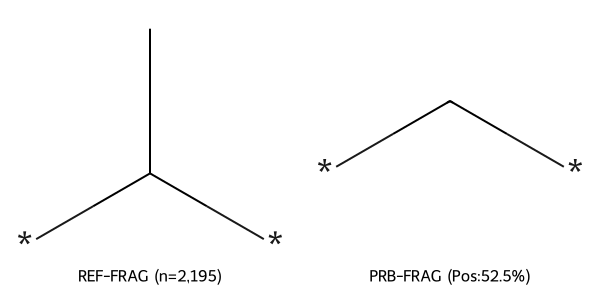

--------------------------------------------------------------------------------

Pair 6: Occurrence = 1,889 samples
  Positive (label=True):    862 samples ( 45.6%)
  Negative (label=False): 1,027 samples ( 54.4%)
REF-FRAG: *O
PRB-FRAG: *OC

Pair 6: Occurrence = 1,889 samples
  Positive (label=True):    862 samples ( 45.6%)
  Negative (label=False): 1,027 samples ( 54.4%)
REF-FRAG: *O
PRB-FRAG: *OC


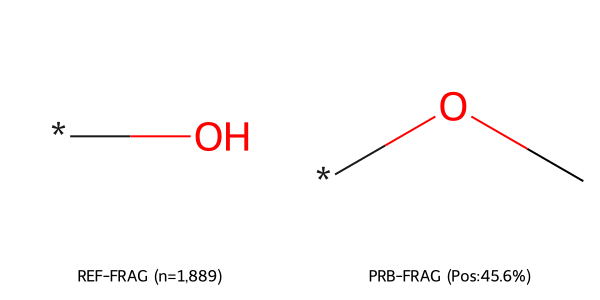

--------------------------------------------------------------------------------

Pair 7: Occurrence = 1,577 samples
  Positive (label=True):    676 samples ( 42.9%)
  Negative (label=False):   901 samples ( 57.1%)
REF-FRAG: *N(*)C
PRB-FRAG: *N*

Pair 7: Occurrence = 1,577 samples
  Positive (label=True):    676 samples ( 42.9%)
  Negative (label=False):   901 samples ( 57.1%)
REF-FRAG: *N(*)C
PRB-FRAG: *N*


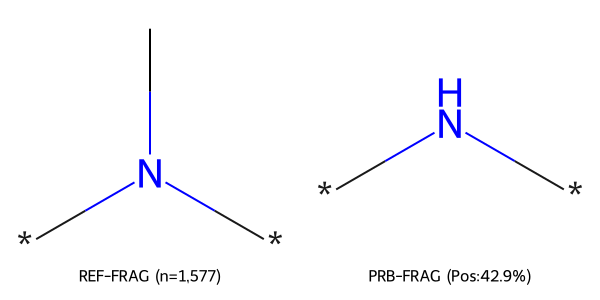

--------------------------------------------------------------------------------

Pair 8: Occurrence = 1,434 samples
  Positive (label=True):    592 samples ( 41.3%)
  Negative (label=False):   842 samples ( 58.7%)
REF-FRAG: *C
PRB-FRAG: *C(F)(F)F

Pair 8: Occurrence = 1,434 samples
  Positive (label=True):    592 samples ( 41.3%)
  Negative (label=False):   842 samples ( 58.7%)
REF-FRAG: *C
PRB-FRAG: *C(F)(F)F


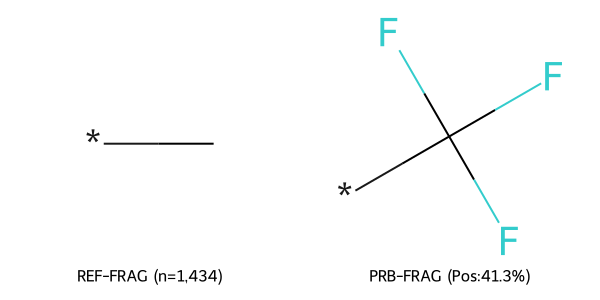

--------------------------------------------------------------------------------

Pair 9: Occurrence = 1,280 samples
  Positive (label=True):    575 samples ( 44.9%)
  Negative (label=False):   705 samples ( 55.1%)
REF-FRAG: *C
PRB-FRAG: *C1CC1

Pair 9: Occurrence = 1,280 samples
  Positive (label=True):    575 samples ( 44.9%)
  Negative (label=False):   705 samples ( 55.1%)
REF-FRAG: *C
PRB-FRAG: *C1CC1


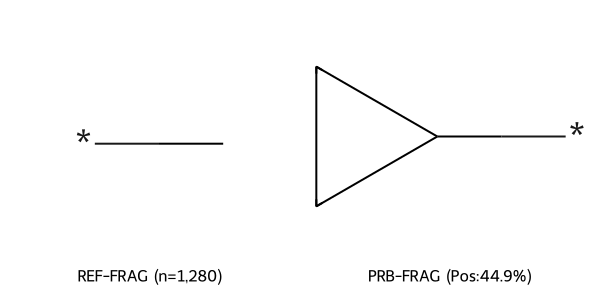

--------------------------------------------------------------------------------

Pair 10: Occurrence = 1,254 samples
  Positive (label=True):    430 samples ( 34.3%)
  Negative (label=False):   824 samples ( 65.7%)
REF-FRAG: *C
PRB-FRAG: *Cc1ccccc1

Pair 10: Occurrence = 1,254 samples
  Positive (label=True):    430 samples ( 34.3%)
  Negative (label=False):   824 samples ( 65.7%)
REF-FRAG: *C
PRB-FRAG: *Cc1ccccc1


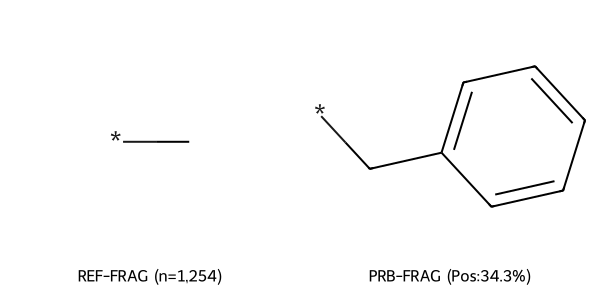

--------------------------------------------------------------------------------


In [88]:
# 最も出現頻度の高いフラグメントペアTop 10を可視化
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Top 10のフラグメントペアを抽出
top_pairs = grouped_counts_unordered.head(10).copy()

# FRAG_PAIRのタプルをREF-FRAG-NORMとPRB-FRAG-NORMに分解
top_pairs[['REF-FRAG-NORM', 'PRB-FRAG-NORM']] = pd.DataFrame(
    top_pairs['FRAG_PAIR'].tolist(), 
    index=top_pairs.index
)

print("■ Structure visualization of Top 10 most frequent fragment pairs")
print("=" * 80)

for idx, (index, row) in enumerate(top_pairs.iterrows(), 1):
    ref_frag = row['REF-FRAG-NORM']
    prb_frag = row['PRB-FRAG-NORM']
    count = row['count']
    frag_pair = row['FRAG_PAIR']
    
    # このフラグメントペアに対応するデータを抽出
    pair_data = df[df['FRAG_PAIR'] == frag_pair]
    
    # label_binの統計を計算
    n_positive = (pair_data['label_bin'] == True).sum()
    n_negative = (pair_data['label_bin'] == False).sum()
    pos_ratio = n_positive / count * 100 if count > 0 else 0
    neg_ratio = n_negative / count * 100 if count > 0 else 0
    
    print(f"\nPair {idx}: Occurrence = {count:,} samples")
    print(f"  Positive (label=True):  {n_positive:5,} samples ({pos_ratio:5.1f}%)")
    print(f"  Negative (label=False): {n_negative:5,} samples ({neg_ratio:5.1f}%)")
    print(f"REF-FRAG: {ref_frag}")
    print(f"PRB-FRAG: {prb_frag}")
    
    # 両方のフラグメントを横に並べて表示
    mols = []
    legends = []
    
    # REF-FRAGを分子として解釈
    try:
        mol_ref = Chem.MolFromSmiles(ref_frag)
        if mol_ref:
            mols.append(mol_ref)
            legends.append(f"REF-FRAG (n={count:,})")
        else:
            print("⚠ Failed to parse REF-FRAG structure")
    except Exception as e:
        print(f"⚠ REF-FRAG error: {e}")
    
    # PRB-FRAGを分子として解釈
    try:
        mol_prb = Chem.MolFromSmiles(prb_frag)
        if mol_prb:
            mols.append(mol_prb)
            legends.append(f"PRB-FRAG (Pos:{pos_ratio:.1f}%)")
        else:
            print("⚠ Failed to parse PRB-FRAG structure")
    except Exception as e:
        print(f"⚠ PRB-FRAG error: {e}")
    
    # 2つの構造を横に並べて表示
    if len(mols) == 2:
        img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300, 300), 
                                     legends=legends)
        display(img)
    elif len(mols) == 1:
        display(Draw.MolToImage(mols[0], size=(300, 300)))
    
    print("-" * 80)

### 4.3 分子ペア (順不同) ごとのサンプル数

In [89]:
# 分子ペア（REF-SMILESとPRB-SMILES）を順不同でカウント
# 各行でREF-SMILESとPRB-SMILESをソートして、常に小さい方を先にする
df['MOLECULE_PAIR'] = df.apply(
    lambda row: tuple(sorted([row['REF-SMILES'], row['PRB-SMILES']])), 
    axis=1
)

# ソート済みのペアでグループ化
grouped_molecule_counts = df.groupby('MOLECULE_PAIR').size().reset_index(name='count')
grouped_molecule_counts = grouped_molecule_counts.sort_values('count', ascending=False)

print("■ Sample count statistics for molecule pairs (unordered):")
print(f"Total unique molecule pairs: {len(grouped_molecule_counts):,} types")
print(f"\nSample count statistics:")
print(grouped_molecule_counts['count'].describe())

# サンプル数の分布
print(f"\n■ Distribution of sample counts:")
thresholds = [1, 2, 3, 5, 10, 20, 50, 100]
for threshold in thresholds:
    count = (grouped_molecule_counts['count'] >= threshold).sum()
    print(f"n ≥ {threshold:3d}: {count:5,} types ({count/len(grouped_molecule_counts)*100:5.1f}%)")

■ Sample count statistics for molecule pairs (unordered):
Total unique molecule pairs: 1,043,334 types

Sample count statistics:
count    1.043334e+06
mean     1.430167e+00
std      8.518391e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.300000e+01
Name: count, dtype: float64

■ Distribution of sample counts:
n ≥   1: 1,043,334 types (100.0%)
n ≥   2: 274,936 types ( 26.4%)
n ≥   3: 125,411 types ( 12.0%)
n ≥   5: 5,703 types (  0.5%)
n ≥  10:   371 types (  0.0%)
n ≥  20:     5 types (  0.0%)
n ≥  50:     0 types (  0.0%)
n ≥ 100:     0 types (  0.0%)


In [90]:
# 順序を考慮した分子ペア（data_process.ipynbと同じ方法）
grouped_ordered = df.groupby(['REF-SMILES', 'PRB-SMILES'])['label_bin'].nunique().reset_index()
n_ordered_pairs = len(grouped_ordered)
inconsistent_ordered = grouped_ordered[grouped_ordered['label_bin'] > 1]
n_inconsistent_ordered = len(inconsistent_ordered)

print("■ 分子ペアの順序性による違い:")
print(f"\n【順序を考慮した場合 (REF-SMILES, PRB-SMILES)】")
print(f"  - 総ペア数: {n_ordered_pairs:,} 組")
print(f"  - 非一貫なペア数: {n_inconsistent_ordered:,} 組")
print(f"  - 一貫性のあるペア数: {n_ordered_pairs - n_inconsistent_ordered:,} 組")
print(f"\n【順不同の場合 (sorted pair)】")
print(f"  - 総ペア数: {len(grouped_molecule_counts):,} 組")
print(f"  ※ (A, B)と(B, A)を同一とみなす")
print(f"\n【差分】")
print(f"  - 順序考慮 - 順不同 = {n_ordered_pairs - len(grouped_molecule_counts):,} 組")
print(f"  ※ この差分は、同じ分子ペアで順序が逆のデータが存在することを示します")

# data_process.ipynbで削除されるペアの影響
df_after_filter = df.merge(inconsistent_ordered[['REF-SMILES', 'PRB-SMILES']], 
                            on=['REF-SMILES', 'PRB-SMILES'], 
                            how='left', 
                            indicator=True)
df_after_filter = df_after_filter[df_after_filter['_merge'] == 'left_only']

print(f"\n【data_process.ipynbのフィルタ後】")
print(f"  - 削除される行数: {len(df) - len(df_after_filter):,} 行")
print(f"  - 残る行数: {len(df_after_filter):,} 行")
print(f"  - 削除率: {((len(df) - len(df_after_filter)) / len(df) * 100):.2f}%")

■ 分子ペアの順序性による違い:

【順序を考慮した場合 (REF-SMILES, PRB-SMILES)】
  - 総ペア数: 1,217,736 組
  - 非一貫なペア数: 94,252 組
  - 一貫性のあるペア数: 1,123,484 組

【順不同の場合 (sorted pair)】
  - 総ペア数: 1,043,334 組
  ※ (A, B)と(B, A)を同一とみなす

【差分】
  - 順序考慮 - 順不同 = 174,402 組
  ※ この差分は、同じ分子ペアで順序が逆のデータが存在することを示します

【data_process.ipynbのフィルタ後】
  - 削除される行数: 221,904 行
  - 残る行数: 1,270,238 行
  - 削除率: 14.87%

【data_process.ipynbのフィルタ後】
  - 削除される行数: 221,904 行
  - 残る行数: 1,270,238 行
  - 削除率: 14.87%


In [91]:
# 順不同の分子ペアでのラベルの一貫性を詳細にチェック
print("■ 順不同の分子ペアでのlabel_binの一貫性チェック")
print("="*80)

# 各順不同ペアについて、label_binの種類数をカウント
grouped_unordered_labels = df.groupby('MOLECULE_PAIR')['label_bin'].agg(['nunique', 'count']).reset_index()
grouped_unordered_labels.columns = ['MOLECULE_PAIR', 'n_unique_labels', 'n_samples']

# 複数のラベルを持つペアを抽出
inconsistent_unordered = grouped_unordered_labels[grouped_unordered_labels['n_unique_labels'] > 1]

print(f"\n【順不同の分子ペアでのラベル一貫性】")
print(f"  - 総ペア数: {len(grouped_unordered_labels):,} 組")
print(f"  - 単一ラベルのペア: {len(grouped_unordered_labels[grouped_unordered_labels['n_unique_labels'] == 1]):,} 組")
print(f"  - 複数ラベルのペア: {len(inconsistent_unordered):,} 組")

# 複数ラベルを持つペアの統計
if len(inconsistent_unordered) > 0:
    total_samples_in_inconsistent = inconsistent_unordered['n_samples'].sum()
    print(f"\n【複数ラベルを持つペアの詳細】")
    print(f"  - このペアに含まれる総サンプル数: {total_samples_in_inconsistent:,} 行")
    print(f"  - 元データに対する割合: {total_samples_in_inconsistent / len(df) * 100:.2f}%")
    print(f"\n  サンプル数の分布:")
    print(inconsistent_unordered['n_samples'].describe())
    
    # 最初の5つの例を表示
    print(f"\n【複数ラベルを持つペアの例（最初の5つ）】")
    for i, (idx, row) in enumerate(inconsistent_unordered.head(5).iterrows()):
        pair = row['MOLECULE_PAIR']
        n_labels = row['n_unique_labels']
        n_samp = row['n_samples']
        
        # このペアの詳細データを取得
        pair_detail = df[df['MOLECULE_PAIR'] == pair][['REF-SMILES', 'PRB-SMILES', 'delta_value', 'label_bin', 'TID', 'AID']]
        
        print(f"\n  例{i+1}: {n_labels}種類のラベル, {n_samp}サンプル")
        print(f"  REF-SMILES: {pair[0][:50]}...")
        print(f"  PRB-SMILES: {pair[1][:50]}...")
        print(f"  ラベル分布:")
        print(pair_detail['label_bin'].value_counts().to_dict())
        print(f"  delta_value範囲: [{pair_detail['delta_value'].min():.3f}, {pair_detail['delta_value'].max():.3f}]")
        print(f"  標的数(TID): {pair_detail['TID'].nunique()}, アッセイ数(AID): {pair_detail['AID'].nunique()}")

print("\n" + "="*80)

■ 順不同の分子ペアでのlabel_binの一貫性チェック



【順不同の分子ペアでのラベル一貫性】
  - 総ペア数: 1,043,334 組
  - 単一ラベルのペア: 908,797 組
  - 複数ラベルのペア: 134,537 組

【複数ラベルを持つペアの詳細】
  - このペアに含まれる総サンプル数: 377,765 行
  - 元データに対する割合: 25.32%

  サンプル数の分布:
count    134537.000000
mean          2.807889
std           0.936461
min           2.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          33.000000
Name: n_samples, dtype: float64

【複数ラベルを持つペアの例（最初の5つ）】

  例1: 2種類のラベル, 2サンプル
  REF-SMILES: BrCCCCCCCCCCNc1c2c(nc3ccccc13)CCCC2...
  PRB-SMILES: BrCCCCCCCNc1c2c(nc3ccccc13)CCCC2...
  ラベル分布:
{False: 1, True: 1}
  delta_value範囲: [-1.480, -0.150]
  標的数(TID): 2, アッセイ数(AID): 2

  例2: 2種類のラベル, 4サンプル
  REF-SMILES: Brc1cc(Br)cc(CNc2nccc(-c3ccc4c(c3)OCO4)n2)c1...
  PRB-SMILES: Brc1ccc(CNc2nccc(-c3ccc4c(c3)OCO4)n2)cc1Br...
  ラベル分布:
{False: 2, True: 2}
  delta_value範囲: [-0.794, -0.136]
  標的数(TID): 4, アッセイ数(AID): 4

  例1: 2種類のラベル, 2サンプル
  REF-SMILES: BrCCCCCCCCCCNc1c2c(nc3ccccc13)CCCC2...
  PRB-SMILES: BrCCCCCCCNc1c2c(nc3ccccc13)CCCC2...
  ラベル分布:


In [92]:
# data_process.ipynbのセル13と完全に同じロジックで検証
print("■ data_process.ipynb セル13（順不同版）と同じロジックで検証")
print("="*80)

def create_unordered_pair_key(row):
    """REF-SMILESとPRB-SMILESを辞書順でソートしてペアキーを作成"""
    smiles_pair = tuple(sorted([row['REF-SMILES'], row['PRB-SMILES']]))
    return f"{smiles_pair[0]}||{smiles_pair[1]}"

# data_process.ipynbと同じ方法で処理
df_test = df.copy()
df_test['molecule_pair_unordered'] = df_test.apply(create_unordered_pair_key, axis=1)

# 各分子ペア（順不同）について、label_binの種類数を計算
grouped_unordered_test = df_test.groupby('molecule_pair_unordered')['label_bin'].nunique().reset_index()
grouped_unordered_test.columns = ['molecule_pair_unordered', 'label_bin_nunique']

# label_binが複数種類存在するペアを特定
inconsistent_pairs_keys_test = grouped_unordered_test[grouped_unordered_test['label_bin_nunique'] > 1]['molecule_pair_unordered'].tolist()

# 非一貫なペアに該当する行数をカウント
df_inconsistent_rows = df_test[df_test['molecule_pair_unordered'].isin(inconsistent_pairs_keys_test)]

print(f"\n【data_process.ipynb セル13と同じ方法での結果】")
print(f"  - 総ペア数: {len(grouped_unordered_test):,} 組")
print(f"  - 非一貫なペア数: {len(inconsistent_pairs_keys_test):,} 組")
print(f"  - 非一貫なペアに含まれる行数: {len(df_inconsistent_rows):,} 行")
print(f"  - フィルタ後の行数: {len(df_test) - len(df_inconsistent_rows):,} 行")
print(f"  - 削除率: {len(df_inconsistent_rows) / len(df_test) * 100:.2f}%")

print(f"\n【比較: data_process.ipynb で報告されている値】")
print(f"  - 元のデータ行数: 779,081 行")
print(f"  - 非一貫なSMILESペア（順不同）数: ? 組")
print(f"  - フィルタ後の行数: ? 行")

print(f"\n【この分析での値】")
print(f"  - 元のデータ行数: {len(df):,} 行")
print(f"  - 非一貫なSMILESペア（順不同）数: {len(inconsistent_pairs_keys_test):,} 組")
print(f"  - フィルタ後の行数: {len(df_test) - len(df_inconsistent_rows):,} 行")

print("\n" + "="*80)

■ data_process.ipynb セル13（順不同版）と同じロジックで検証



【data_process.ipynb セル13と同じ方法での結果】
  - 総ペア数: 1,043,334 組
  - 非一貫なペア数: 134,537 組
  - 非一貫なペアに含まれる行数: 377,765 行
  - フィルタ後の行数: 1,114,377 行
  - 削除率: 25.32%

【比較: data_process.ipynb で報告されている値】
  - 元のデータ行数: 779,081 行
  - 非一貫なSMILESペア（順不同）数: ? 組
  - フィルタ後の行数: ? 行

【この分析での値】
  - 元のデータ行数: 1,492,142 行
  - 非一貫なSMILESペア（順不同）数: 134,537 組
  - フィルタ後の行数: 1,114,377 行



### 4.4 高頻度分子ペアの可視化 (Top 10)

■ Structure visualization of Top 10 most frequent molecule pairs

Pair 1: Occurrence = 33 samples
  Positive (label=True):     23 samples ( 69.7%)
  Negative (label=False):    10 samples ( 30.3%)
REF-SMILES: O=C(Cc1cccc(OCCCC2CCNCC2)c1)Nc1nc(-c2ccncc2)cs1
PRB-SMILES: O=C(Cc1cccc(OCCCN2CCNCC2)c1)Nc1nc(-c2ccncc2)cs1


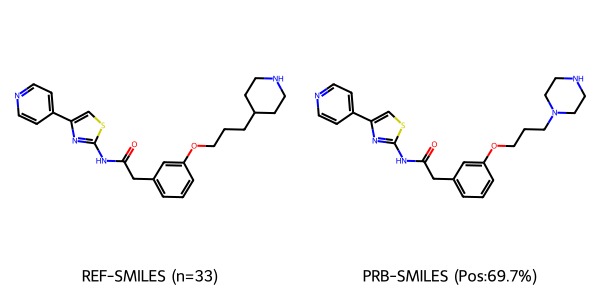

--------------------------------------------------------------------------------

Pair 2: Occurrence = 30 samples
  Positive (label=True):     25 samples ( 83.3%)
  Negative (label=False):     5 samples ( 16.7%)
REF-SMILES: Nc1ncnc2c1c(-c1cccc(OC[C@@H]3CCCO3)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1
PRB-SMILES: Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1


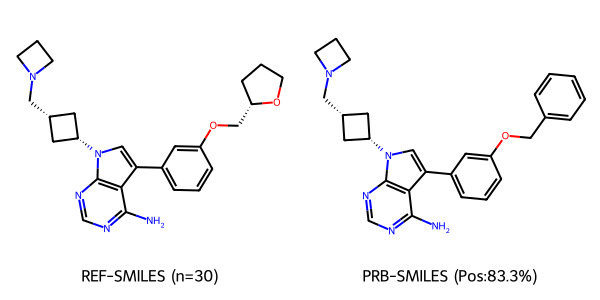

--------------------------------------------------------------------------------

Pair 3: Occurrence = 24 samples
  Positive (label=True):     22 samples ( 91.7%)
  Negative (label=False):     2 samples (  8.3%)
REF-SMILES: Nc1ncnc2c1c(-c1cccc(OCC34CCC(CC3)O4)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1
PRB-SMILES: Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1

Pair 3: Occurrence = 24 samples
  Positive (label=True):     22 samples ( 91.7%)
  Negative (label=False):     2 samples (  8.3%)
REF-SMILES: Nc1ncnc2c1c(-c1cccc(OCC34CCC(CC3)O4)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1
PRB-SMILES: Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1


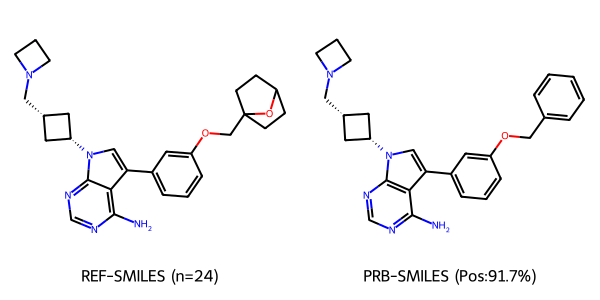

--------------------------------------------------------------------------------

Pair 4: Occurrence = 23 samples
  Positive (label=True):      5 samples ( 21.7%)
  Negative (label=False):    18 samples ( 78.3%)
REF-SMILES: O=C(Nc1cccc(Nc2ccc3c(c2)NC(=O)/C3=C\c2ccc[nH]2)c1)Nc1cccc(C(F)(F)F)c1
PRB-SMILES: O=C1Nc2cc(Nc3cccc(NC(=O)c4cccc(C(F)(F)F)c4)c3)ccc2/C1=C/c1ccc[nH]1

Pair 4: Occurrence = 23 samples
  Positive (label=True):      5 samples ( 21.7%)
  Negative (label=False):    18 samples ( 78.3%)
REF-SMILES: O=C(Nc1cccc(Nc2ccc3c(c2)NC(=O)/C3=C\c2ccc[nH]2)c1)Nc1cccc(C(F)(F)F)c1
PRB-SMILES: O=C1Nc2cc(Nc3cccc(NC(=O)c4cccc(C(F)(F)F)c4)c3)ccc2/C1=C/c1ccc[nH]1


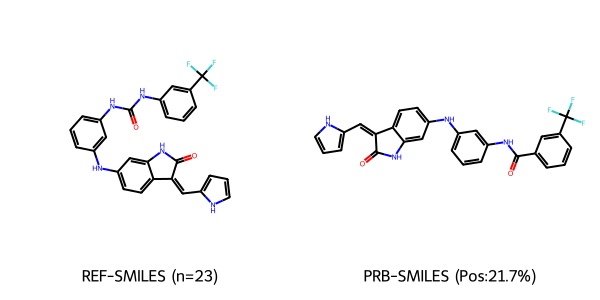

--------------------------------------------------------------------------------

Pair 5: Occurrence = 21 samples
  Positive (label=True):     19 samples ( 90.5%)
  Negative (label=False):     2 samples (  9.5%)
REF-SMILES: Nc1ncnc2c1c(-c1cccc(OCC34CCC(CC3)O4)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1
PRB-SMILES: Nc1ncnc2c1c(-c1cccc(OC[C@@H]3CCCO3)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1

Pair 5: Occurrence = 21 samples
  Positive (label=True):     19 samples ( 90.5%)
  Negative (label=False):     2 samples (  9.5%)
REF-SMILES: Nc1ncnc2c1c(-c1cccc(OCC34CCC(CC3)O4)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1
PRB-SMILES: Nc1ncnc2c1c(-c1cccc(OC[C@@H]3CCCO3)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1


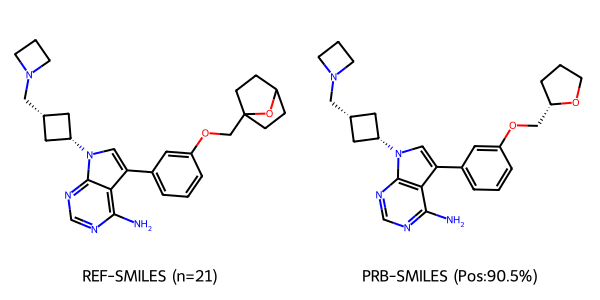

--------------------------------------------------------------------------------

Pair 6: Occurrence = 17 samples
  Positive (label=True):     10 samples ( 58.8%)
  Negative (label=False):     7 samples ( 41.2%)
REF-SMILES: COCC(=O)N1CCC[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: Nc1nccn2c([C@@H]3CCCN(C4CCOCC4)C3)nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c12

Pair 6: Occurrence = 17 samples
  Positive (label=True):     10 samples ( 58.8%)
  Negative (label=False):     7 samples ( 41.2%)
REF-SMILES: COCC(=O)N1CCC[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: Nc1nccn2c([C@@H]3CCCN(C4CCOCC4)C3)nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c12


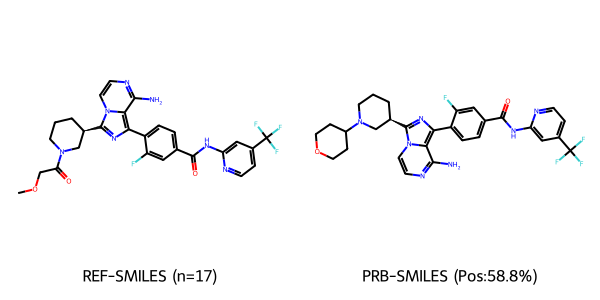

--------------------------------------------------------------------------------

Pair 7: Occurrence = 17 samples
  Positive (label=True):      4 samples ( 23.5%)
  Negative (label=False):    13 samples ( 76.5%)
REF-SMILES: CC(C)C(=O)N1CCC[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: Nc1nccn2c([C@@H]3CCCN(C4CCOCC4)C3)nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c12

Pair 7: Occurrence = 17 samples
  Positive (label=True):      4 samples ( 23.5%)
  Negative (label=False):    13 samples ( 76.5%)
REF-SMILES: CC(C)C(=O)N1CCC[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: Nc1nccn2c([C@@H]3CCCN(C4CCOCC4)C3)nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c12


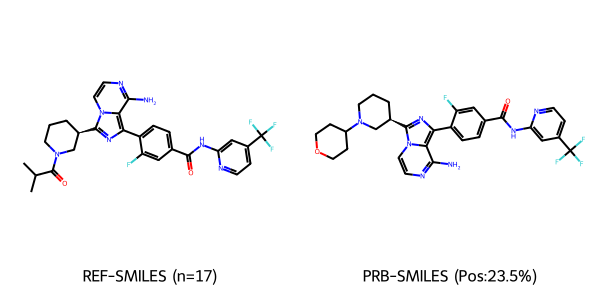

--------------------------------------------------------------------------------

Pair 8: Occurrence = 17 samples
  Positive (label=True):      1 samples (  5.9%)
  Negative (label=False):    16 samples ( 94.1%)
REF-SMILES: CC(C)C(=O)N1CCC[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: COCC(=O)N1CCC[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1

Pair 8: Occurrence = 17 samples
  Positive (label=True):      1 samples (  5.9%)
  Negative (label=False):    16 samples ( 94.1%)
REF-SMILES: CC(C)C(=O)N1CCC[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: COCC(=O)N1CCC[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1


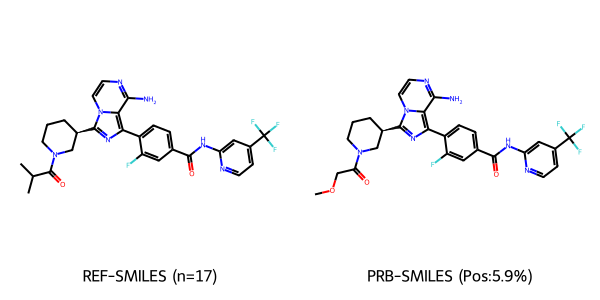

--------------------------------------------------------------------------------

Pair 9: Occurrence = 16 samples
  Positive (label=True):     14 samples ( 87.5%)
  Negative (label=False):     2 samples ( 12.5%)
REF-SMILES: COCC(=O)N1CCO[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: Nc1nccn2c([C@H]3CN(C4CCOCC4)CCO3)nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c12

Pair 9: Occurrence = 16 samples
  Positive (label=True):     14 samples ( 87.5%)
  Negative (label=False):     2 samples ( 12.5%)
REF-SMILES: COCC(=O)N1CCO[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: Nc1nccn2c([C@H]3CN(C4CCOCC4)CCO3)nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c12


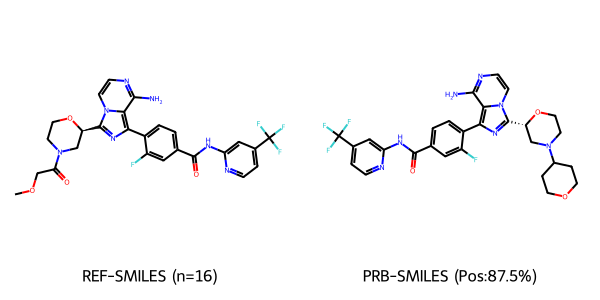

--------------------------------------------------------------------------------

Pair 10: Occurrence = 16 samples
  Positive (label=True):      3 samples ( 18.8%)
  Negative (label=False):    13 samples ( 81.2%)
REF-SMILES: CC(C)C(=O)N1CCO[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: Nc1nccn2c([C@H]3CN(C4CCOCC4)CCO3)nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c12

Pair 10: Occurrence = 16 samples
  Positive (label=True):      3 samples ( 18.8%)
  Negative (label=False):    13 samples ( 81.2%)
REF-SMILES: CC(C)C(=O)N1CCO[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: Nc1nccn2c([C@H]3CN(C4CCOCC4)CCO3)nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c12


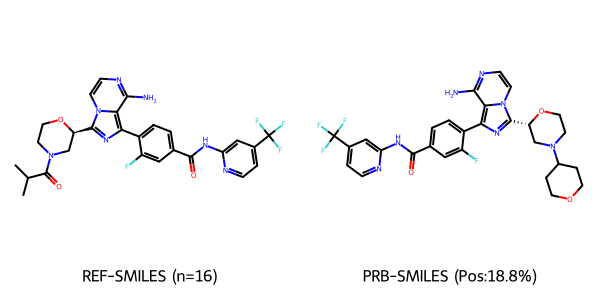

--------------------------------------------------------------------------------


In [93]:
# 最も出現頻度の高い分子ペアTop 10を可視化
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Top 10の分子ペアを抽出
top_molecule_pairs = grouped_molecule_counts.head(10).copy()

# MOLECULE_PAIRのタプルをREF-SMILESとPRB-SMILESに分解
top_molecule_pairs[['REF-SMILES', 'PRB-SMILES']] = pd.DataFrame(
    top_molecule_pairs['MOLECULE_PAIR'].tolist(), 
    index=top_molecule_pairs.index
)

print("■ Structure visualization of Top 10 most frequent molecule pairs")
print("=" * 80)

for idx, (index, row) in enumerate(top_molecule_pairs.iterrows(), 1):
    ref_smiles = row['REF-SMILES']
    prb_smiles = row['PRB-SMILES']
    count = row['count']
    mol_pair = row['MOLECULE_PAIR']
    
    # この分子ペアに対応するデータを抽出
    pair_data = df[df['MOLECULE_PAIR'] == mol_pair]
    
    # label_binの統計を計算
    n_positive = (pair_data['label_bin'] == True).sum()
    n_negative = (pair_data['label_bin'] == False).sum()
    pos_ratio = n_positive / count * 100 if count > 0 else 0
    neg_ratio = n_negative / count * 100 if count > 0 else 0
    
    print(f"\nPair {idx}: Occurrence = {count:,} samples")
    print(f"  Positive (label=True):  {n_positive:5,} samples ({pos_ratio:5.1f}%)")
    print(f"  Negative (label=False): {n_negative:5,} samples ({neg_ratio:5.1f}%)")
    print(f"REF-SMILES: {ref_smiles}")
    print(f"PRB-SMILES: {prb_smiles}")
    
    # 両方の分子を横に並べて表示
    mols = []
    legends = []
    
    # REF-SMILESを分子として解釈
    try:
        mol_ref = Chem.MolFromSmiles(ref_smiles)
        if mol_ref:
            mols.append(mol_ref)
            legends.append(f"REF-SMILES (n={count:,})")
        else:
            print("⚠ Failed to parse REF-SMILES structure")
    except Exception as e:
        print(f"⚠ REF-SMILES error: {e}")
    
    # PRB-SMILESを分子として解釈
    try:
        mol_prb = Chem.MolFromSmiles(prb_smiles)
        if mol_prb:
            mols.append(mol_prb)
            legends.append(f"PRB-SMILES (Pos:{pos_ratio:.1f}%)")
        else:
            print("⚠ Failed to parse PRB-SMILES structure")
    except Exception as e:
        print(f"⚠ PRB-SMILES error: {e}")
    
    # 2つの構造を横に並べて表示
    if len(mols) == 2:
        img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300, 300), 
                                     legends=legends)
        display(img)
    elif len(mols) == 1:
        display(Draw.MolToImage(mols[0], size=(300, 300)))
    
    print("-" * 80)

## 5. ポジティブ/ネガティブサンプルの件数・割合



### 5.1 label_binの分布

■ Distribution of labels (label_bin):
label_bin
False    873401
True     618741
Name: count, dtype: int64

Total samples: 1,492,142

■ Proportion by label:
  label_bin = False: 873,401 samples (58.53%)
  label_bin = True: 618,741 samples (41.47%)


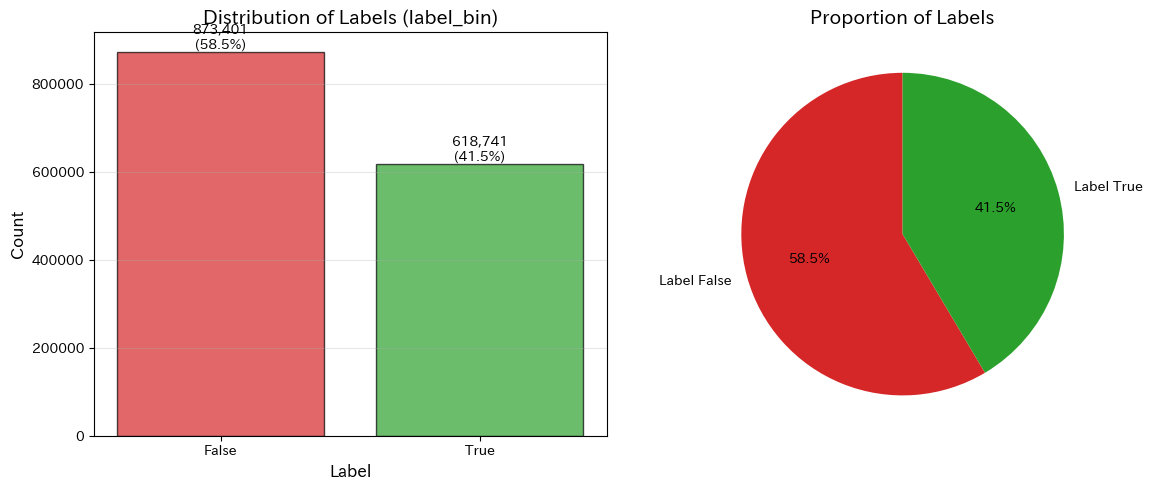

In [94]:
# label_binの分布を確認
if 'label_bin' in df.columns:
    label_counts = df['label_bin'].value_counts().sort_index()
    
    print("■ Distribution of labels (label_bin):")
    print(label_counts)
    print(f"\nTotal samples: {len(df):,}")
    
    # 割合を計算
    print("\n■ Proportion by label:")
    for label, count in label_counts.items():
        print(f"  label_bin = {label}: {count:7,} samples ({count/len(df)*100:5.2f}%)")
    
    # 可視化
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 棒グラフ
    axes[0].bar(label_counts.index.astype(str), label_counts.values, 
                color=['#d62728', '#2ca02c'], alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Label', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title('Distribution of Labels (label_bin)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, (label, count) in enumerate(label_counts.items()):
        axes[0].text(i, count, f'{count:,}\n({count/len(df)*100:.1f}%)', 
                     ha='center', va='bottom', fontsize=10)
    
    # 円グラフ
    axes[1].pie(label_counts.values, labels=[f'Label {i}' for i in label_counts.index],
                autopct='%1.1f%%', startangle=90, colors=['#d62728', '#2ca02c'])
    axes[1].set_title('Proportion of Labels', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Warning: 'label_bin' column not found")

### 5.2 ΔpIC50の範囲別のサンプル分類

In [95]:
# ΔpIC50の範囲別にサンプルを分類
delta_abs = df['delta_value'].abs()

# カテゴリ分け
categories = {
    'Bioisostere (|Δ| < 0.3)': (delta_abs < 0.3).sum(),
    'Small difference (0.3 ≤ |Δ| < 0.5)': ((delta_abs >= 0.3) & (delta_abs < 0.5)).sum(),
    'Medium difference (0.5 ≤ |Δ| < 1.0)': ((delta_abs >= 0.5) & (delta_abs < 1.0)).sum(),
    'Large difference (1.0 ≤ |Δ| < 2.0)': ((delta_abs >= 1.0) & (delta_abs < 2.0)).sum(),
    'Very large difference (|Δ| ≥ 2.0)': (delta_abs >= 2.0).sum()
}

# 結果を表示
print("■ Sample classification by ΔpIC50 range:")
print("="*70)
category_df = pd.DataFrame([
    {'Category': k, 'Count': v, 'Percentage': f'{v/len(df)*100:.2f}%'} 
    for k, v in categories.items()
])
print(category_df.to_string(index=False))
print("="*70)
print(f"Total: {len(df):,} samples")

# Positive (Bioisostere) vs Negative の定義を明示
print("\n■ Definition of Positive / Negative samples:")
print(f"  Positive (Bioisostere):     |ΔpIC50| < 0.3   → {categories['Bioisostere (|Δ| < 0.3)']:7,} samples ({categories['Bioisostere (|Δ| < 0.3)']/len(df)*100:5.2f}%)")
print(f"  Negative (Non-bioisostere): |ΔpIC50| ≥ 0.3   → {len(df) - categories['Bioisostere (|Δ| < 0.3)']:7,} samples ({(len(df) - categories['Bioisostere (|Δ| < 0.3)'])/len(df)*100:5.2f}%)")

■ Sample classification by ΔpIC50 range:
                           Category  Count Percentage
            Bioisostere (|Δ| < 0.3) 618741     41.47%
 Small difference (0.3 ≤ |Δ| < 0.5) 225986     15.15%
Medium difference (0.5 ≤ |Δ| < 1.0) 331891     22.24%
 Large difference (1.0 ≤ |Δ| < 2.0) 257952     17.29%
  Very large difference (|Δ| ≥ 2.0)  57572      3.86%
Total: 1,492,142 samples

■ Definition of Positive / Negative samples:
  Positive (Bioisostere):     |ΔpIC50| < 0.3   → 618,741 samples (41.47%)
  Negative (Non-bioisostere): |ΔpIC50| ≥ 0.3   → 873,401 samples (58.53%)


### 5.3 フラグメントペアごとのラベル一貫性分析

各フラグメントペアが常にバイオアイソスター(positive)、常に非バイオアイソスター(negative)、あるいは両方が混在しているかを分析します。

In [96]:
# フラグメントペアごとのラベル（positive/negative）の一貫性を分析
# label_positiveがすでに存在する場合はそのまま使用、なければ作成
if 'label_positive' not in df.columns:
    df['label_positive'] = (df['delta_value'].abs() < 0.3).astype(int)

# フラグメントペアのキーを作成（REF-FRAG と PRB-FRAG の組み合わせ）
df['FRAG_PAIR'] = df['REF-FRAG'] + '||' + df['PRB-FRAG']

# 各フラグメントペアについて、ラベルの統計を計算
frag_pair_label_stats = df.groupby('FRAG_PAIR').agg({
    'label_positive': ['count', 'sum', 'mean']
}).reset_index()

# カラム名を整理
frag_pair_label_stats.columns = ['FRAG_PAIR', 'total_samples', 'positive_count', 'positive_ratio']
frag_pair_label_stats['negative_count'] = frag_pair_label_stats['total_samples'] - frag_pair_label_stats['positive_count']

# ラベルの一貫性を分類
# - All Positive: 全てpositive (positive_ratio == 1.0)
# - All Negative: 全てnegative (positive_ratio == 0.0)
# - Mixed: 両方が混在 (0.0 < positive_ratio < 1.0)

def classify_consistency(row):
    if row['positive_ratio'] == 1.0:
        return 'All Positive'
    elif row['positive_ratio'] == 0.0:
        return 'All Negative'
    else:
        return 'Mixed'

frag_pair_label_stats['consistency'] = frag_pair_label_stats.apply(classify_consistency, axis=1)

# 統計を表示
print("■ Label consistency analysis per fragment pair:")
print("="*80)

consistency_counts = frag_pair_label_stats['consistency'].value_counts()
print("\n【Distribution of label consistency】")
for consistency, count in consistency_counts.items():
    pct = count / len(frag_pair_label_stats) * 100
    print(f"  {consistency:15s}: {count:6,} pairs ({pct:5.1f}%)")

print(f"\nTotal fragment pairs: {len(frag_pair_label_stats):,}")

# サンプル数でも集計
print("\n【Sample distribution by label consistency】")
for consistency in ['All Positive', 'Mixed', 'All Negative']:
    if consistency in consistency_counts.index:
        pairs_subset = frag_pair_label_stats[frag_pair_label_stats['consistency'] == consistency]
        total_samples_in_category = pairs_subset['total_samples'].sum()
        pct = total_samples_in_category / df.shape[0] * 100
        print(f"  {consistency:15s}: {total_samples_in_category:7,} samples ({pct:5.1f}%)")

print(f"\nTotal samples: {df.shape[0]:,}")
print("="*80)

■ Label consistency analysis per fragment pair:

【Distribution of label consistency】
  All Negative   : 486,308 pairs ( 54.6%)
  All Positive   : 277,625 pairs ( 31.2%)
  Mixed          : 126,497 pairs ( 14.2%)

Total fragment pairs: 890,430

【Sample distribution by label consistency】
  All Positive   : 350,171 samples ( 23.5%)
  Mixed          : 566,293 samples ( 38.0%)
  All Negative   : 575,678 samples ( 38.6%)

Total samples: 1,492,142


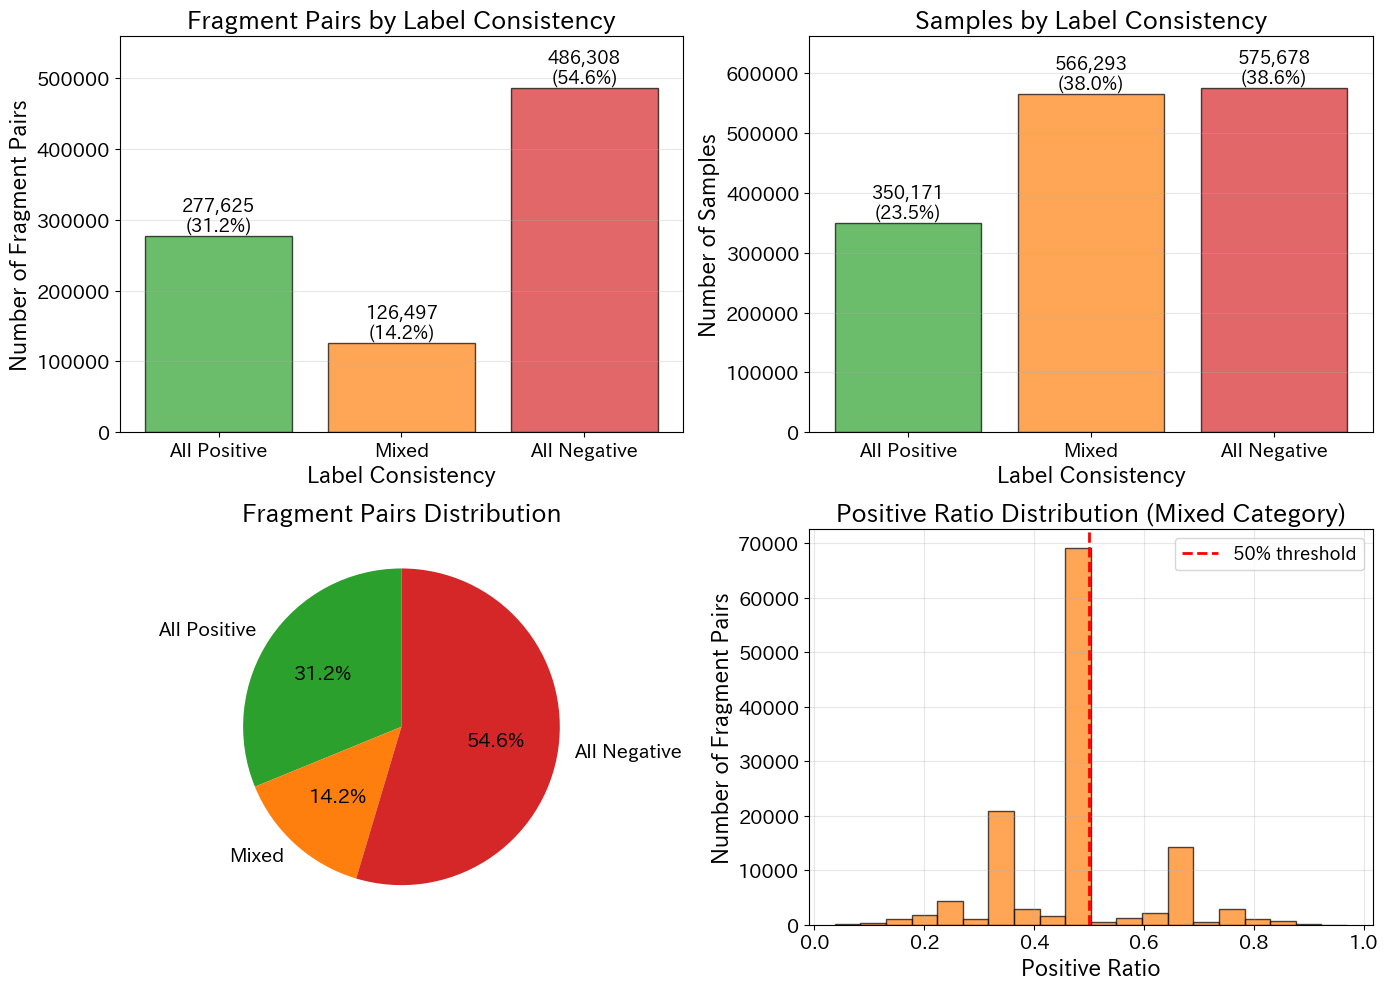

■ Figure: Label consistency analysis for fragment pairs


In [97]:
# ラベル一貫性の可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. フラグメントペア数の分布（棒グラフ）
consistency_order = ['All Positive', 'Mixed', 'All Negative']
consistency_counts_ordered = [consistency_counts.get(c, 0) for c in consistency_order]
colors = ['#2ca02c', '#ff7f0e', '#d62728']

axes[0, 0].bar(consistency_order, consistency_counts_ordered, 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Label Consistency', fontsize=16)
axes[0, 0].set_ylabel('Number of Fragment Pairs', fontsize=16)
axes[0, 0].set_title('Fragment Pairs by Label Consistency', fontsize=18, fontweight='bold')
axes[0, 0].tick_params(axis='both', labelsize=14)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim(0, max(consistency_counts_ordered) * 1.15)
for i, (cat, count) in enumerate(zip(consistency_order, consistency_counts_ordered)):
    axes[0, 0].text(i, count, f'{count:,}\n({count/len(frag_pair_label_stats)*100:.1f}%)', 
                     ha='center', va='bottom', fontsize=13)

# 2. サンプル数の分布（棒グラフ）
sample_counts = []
for consistency in consistency_order:
    pairs_subset = frag_pair_label_stats[frag_pair_label_stats['consistency'] == consistency]
    sample_counts.append(pairs_subset['total_samples'].sum())

axes[0, 1].bar(consistency_order, sample_counts, 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Label Consistency', fontsize=16)
axes[0, 1].set_ylabel('Number of Samples', fontsize=16)
axes[0, 1].set_title('Samples by Label Consistency', fontsize=18, fontweight='bold')
axes[0, 1].tick_params(axis='both', labelsize=14)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim(0, max(sample_counts) * 1.15)
for i, (cat, count) in enumerate(zip(consistency_order, sample_counts)):
    axes[0, 1].text(i, count, f'{count:,}\n({count/df.shape[0]*100:.1f}%)', 
                     ha='center', va='bottom', fontsize=13)

# 3. 円グラフ（フラグメントペア数）
axes[1, 0].pie(consistency_counts_ordered, labels=consistency_order, autopct='%1.1f%%',
                startangle=90, colors=colors, textprops={'fontsize': 14})
axes[1, 0].set_title('Fragment Pairs Distribution', fontsize=18, fontweight='bold')

# 4. Mixedカテゴリの詳細（positive_ratioのヒストグラム）
mixed_pairs = frag_pair_label_stats[frag_pair_label_stats['consistency'] == 'Mixed']
if len(mixed_pairs) > 0:
    axes[1, 1].hist(mixed_pairs['positive_ratio'], bins=20, 
                    alpha=0.7, color='#ff7f0e', edgecolor='black')
    axes[1, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    axes[1, 1].set_xlabel('Positive Ratio', fontsize=16)
    axes[1, 1].set_ylabel('Number of Fragment Pairs', fontsize=16)
    axes[1, 1].set_title('Positive Ratio Distribution (Mixed Category)', fontsize=18, fontweight='bold')
    axes[1, 1].tick_params(axis='both', labelsize=14)
    axes[1, 1].legend(fontsize=13)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No Mixed pairs found', 
                    ha='center', va='center', fontsize=16)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("■ Figure: Label consistency analysis for fragment pairs")

In [98]:
# サンプル数による分析（n≥3のフラグメントペアのみ）
frag_pair_label_stats_filtered = frag_pair_label_stats[frag_pair_label_stats['total_samples'] >= 3]

print("\n■ Label consistency analysis (n≥3 samples per fragment pair):")
print("="*80)

consistency_counts_filtered = frag_pair_label_stats_filtered['consistency'].value_counts()
print("\n【Distribution of label consistency (n≥3)】")
for consistency in consistency_order:
    count = consistency_counts_filtered.get(consistency, 0)
    pct = count / len(frag_pair_label_stats_filtered) * 100 if len(frag_pair_label_stats_filtered) > 0 else 0
    print(f"  {consistency:15s}: {count:6,} pairs ({pct:5.1f}%)")

print(f"\nTotal fragment pairs (n≥3): {len(frag_pair_label_stats_filtered):,}")

# サンプル数でも集計
print("\n【Sample distribution by label consistency (n≥3)】")
for consistency in consistency_order:
    pairs_subset = frag_pair_label_stats_filtered[frag_pair_label_stats_filtered['consistency'] == consistency]
    total_samples_in_category = pairs_subset['total_samples'].sum()
    pct = total_samples_in_category / frag_pair_label_stats_filtered['total_samples'].sum() * 100
    print(f"  {consistency:15s}: {total_samples_in_category:7,} samples ({pct:5.1f}%)")

print(f"\nTotal samples (n≥3): {frag_pair_label_stats_filtered['total_samples'].sum():,}")
print("="*80)


■ Label consistency analysis (n≥3 samples per fragment pair):

【Distribution of label consistency (n≥3)】
  All Positive   : 14,193 pairs ( 15.6%)
  Mixed          : 63,253 pairs ( 69.5%)
  All Negative   : 13,561 pairs ( 14.9%)

Total fragment pairs (n≥3): 91,007

【Sample distribution by label consistency (n≥3)】
  All Positive   :  48,288 samples (  9.0%)
  Mixed          : 439,805 samples ( 82.3%)
  All Negative   :  46,305 samples (  8.7%)

Total samples (n≥3): 534,398


### 5.4 分子ペア（順不同）ごとのラベル一貫性分析

分子ペアを順不同（A-BとB-Aを同じペアとして扱う）で集約し、各ペアのラベル一貫性を分析します。

In [99]:
# 分子ペア（順不同）ごとのラベル一貫性を分析
# REF-SMILESとPRB-SMILESを順不同にするため、辞書順でソートした組み合わせをキーとする

def create_unordered_pair_key(row):
    """REF-SMILESとPRB-SMILESを辞書順でソートしてペアキーを作成"""
    smiles_pair = tuple(sorted([row['REF-SMILES'], row['PRB-SMILES']]))
    return f"{smiles_pair[0]}||{smiles_pair[1]}"

# 順不同の分子ペアキーを作成
df['molecule_pair_unordered'] = df.apply(create_unordered_pair_key, axis=1)

# 各分子ペア（順不同）について、ラベルの統計を計算
mol_pair_label_stats = df.groupby('molecule_pair_unordered').agg({
    'label_positive': ['count', 'sum', 'mean'],
    'REF-SMILES': 'first',  # ペアの代表として保持
    'PRB-SMILES': 'first'
}).reset_index()

# カラム名を整理
mol_pair_label_stats.columns = ['molecule_pair_unordered', 'total_samples', 'positive_count', 'positive_ratio', 'REF_SMILES_rep', 'PRB_SMILES_rep']
mol_pair_label_stats['negative_count'] = mol_pair_label_stats['total_samples'] - mol_pair_label_stats['positive_count']

# ラベルの一貫性を分類
mol_pair_label_stats['consistency'] = mol_pair_label_stats.apply(classify_consistency, axis=1)

# 統計を表示
print("■ Label consistency analysis per molecule pair (unordered):")
print("="*80)

mol_consistency_counts = mol_pair_label_stats['consistency'].value_counts()
print("\n【Distribution of label consistency】")
for consistency, count in mol_consistency_counts.items():
    pct = count / len(mol_pair_label_stats) * 100
    print(f"  {consistency:15s}: {count:6,} pairs ({pct:5.1f}%)")

print(f"\nTotal molecule pairs (unordered): {len(mol_pair_label_stats):,}")

# サンプル数でも集計
print("\n【Sample distribution by label consistency】")
for consistency in ['All Positive', 'Mixed', 'All Negative']:
    if consistency in mol_consistency_counts.index:
        pairs_subset = mol_pair_label_stats[mol_pair_label_stats['consistency'] == consistency]
        total_samples_in_category = pairs_subset['total_samples'].sum()
        pct = total_samples_in_category / df.shape[0] * 100
        print(f"  {consistency:15s}: {total_samples_in_category:7,} samples ({pct:5.1f}%)")

print(f"\nTotal samples: {df.shape[0]:,}")
print("="*80)

■ Label consistency analysis per molecule pair (unordered):

【Distribution of label consistency】
  All Negative   : 574,468 pairs ( 55.1%)
  All Positive   : 334,329 pairs ( 32.0%)
  Mixed          : 134,537 pairs ( 12.9%)

Total molecule pairs (unordered): 1,043,334

【Sample distribution by label consistency】
  All Positive   : 435,973 samples ( 29.2%)
  Mixed          : 377,765 samples ( 25.3%)
  All Negative   : 678,404 samples ( 45.5%)

Total samples: 1,492,142
  All Negative   : 678,404 samples ( 45.5%)

Total samples: 1,492,142


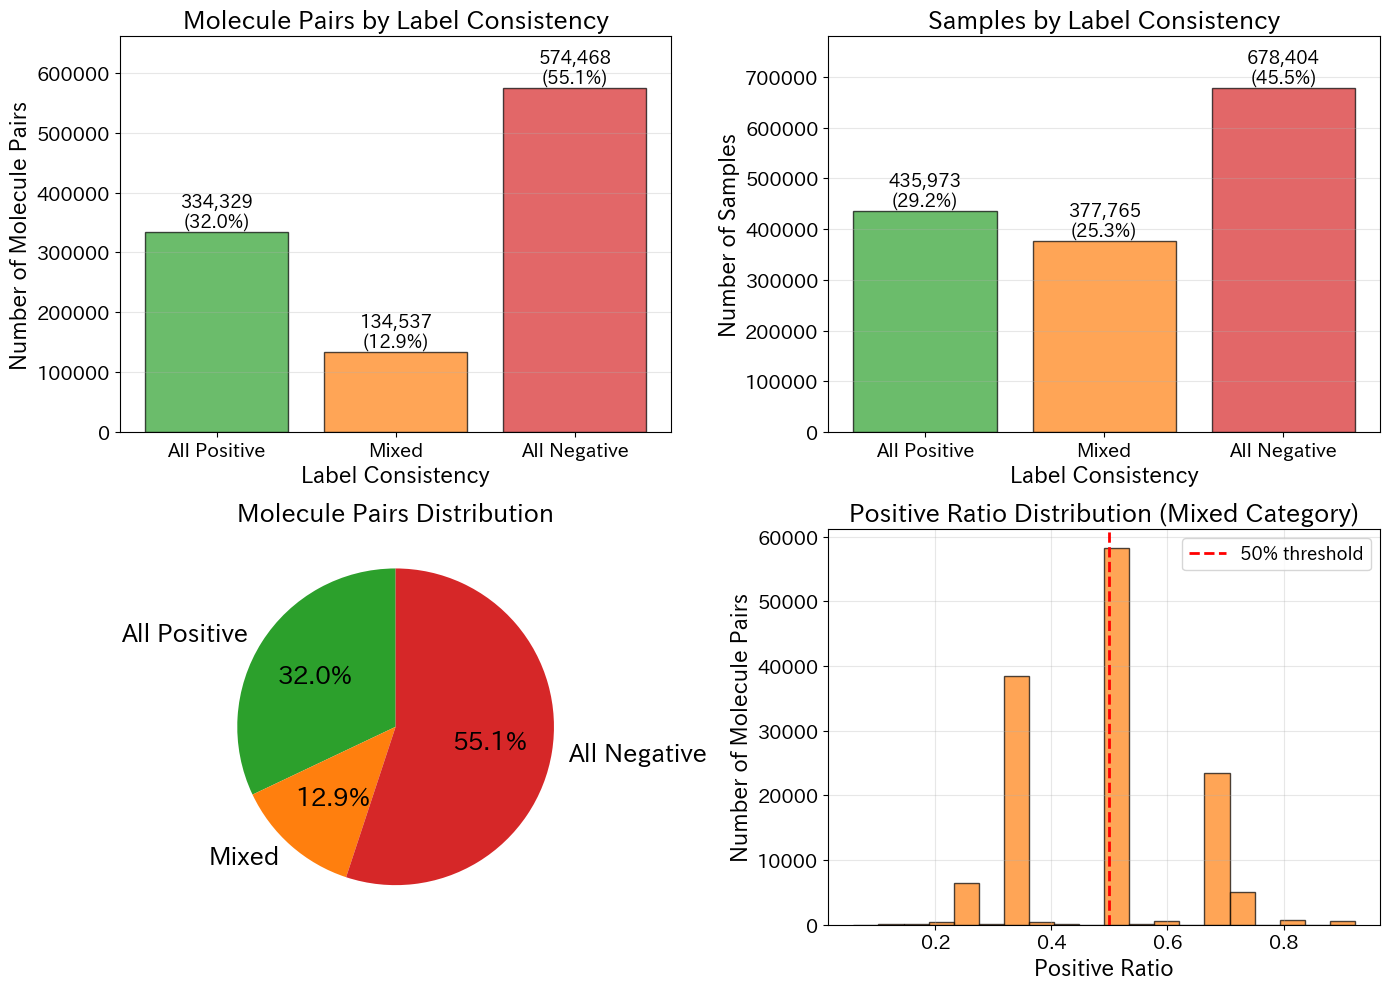

■ Figure: Label consistency analysis for molecule pairs (unordered)


In [100]:
# 分子ペア（順不同）のラベル一貫性の可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 分子ペア数の分布（棒グラフ）
mol_consistency_counts_ordered = [mol_consistency_counts.get(c, 0) for c in consistency_order]
colors = ['#2ca02c', '#ff7f0e', '#d62728']

axes[0, 0].bar(consistency_order, mol_consistency_counts_ordered, 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Label Consistency', fontsize=16)
axes[0, 0].set_ylabel('Number of Molecule Pairs', fontsize=16)
axes[0, 0].set_title('Molecule Pairs by Label Consistency', fontsize=18, fontweight='bold')
axes[0, 0].tick_params(axis='both', labelsize=14)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim(0, max(mol_consistency_counts_ordered) * 1.15)
for i, (cat, count) in enumerate(zip(consistency_order, mol_consistency_counts_ordered)):
    axes[0, 0].text(i, count, f'{count:,}\n({count/len(mol_pair_label_stats)*100:.1f}%)', 
                     ha='center', va='bottom', fontsize=13)

# 2. サンプル数の分布（棒グラフ）
mol_sample_counts = []
for consistency in consistency_order:
    pairs_subset = mol_pair_label_stats[mol_pair_label_stats['consistency'] == consistency]
    mol_sample_counts.append(pairs_subset['total_samples'].sum())

axes[0, 1].bar(consistency_order, mol_sample_counts, 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Label Consistency', fontsize=16)
axes[0, 1].set_ylabel('Number of Samples', fontsize=16)
axes[0, 1].set_title('Samples by Label Consistency', fontsize=18, fontweight='bold')
axes[0, 1].tick_params(axis='both', labelsize=14)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim(0, max(mol_sample_counts) * 1.15)
for i, (cat, count) in enumerate(zip(consistency_order, mol_sample_counts)):
    axes[0, 1].text(i, count, f'{count:,}\n({count/df.shape[0]*100:.1f}%)', 
                     ha='center', va='bottom', fontsize=13)

# 3. 円グラフ（分子ペア数）
axes[1, 0].pie(mol_consistency_counts_ordered, labels=consistency_order, autopct='%1.1f%%',
                startangle=90, colors=colors, textprops={'fontsize': 18})
axes[1, 0].set_title('Molecule Pairs Distribution', fontsize=18, fontweight='bold')

# 4. Mixedカテゴリの詳細（positive_ratioのヒストグラム）
mol_mixed_pairs = mol_pair_label_stats[mol_pair_label_stats['consistency'] == 'Mixed']
if len(mol_mixed_pairs) > 0:
    axes[1, 1].hist(mol_mixed_pairs['positive_ratio'], bins=20, 
                    alpha=0.7, color='#ff7f0e', edgecolor='black')
    axes[1, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    axes[1, 1].set_xlabel('Positive Ratio', fontsize=16)
    axes[1, 1].set_ylabel('Number of Molecule Pairs', fontsize=16)
    axes[1, 1].set_title('Positive Ratio Distribution (Mixed Category)', fontsize=18, fontweight='bold')
    axes[1, 1].tick_params(axis='both', labelsize=14)
    axes[1, 1].legend(fontsize=13)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No Mixed pairs found', 
                    ha='center', va='center', fontsize=16)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("■ Figure: Label consistency analysis for molecule pairs (unordered)")


■ Label consistency analysis for molecule pairs (unordered, n≥3):

【Distribution of label consistency (n≥3)】
  All Positive   : 27,367 pairs ( 21.8%)
  Mixed          : 81,076 pairs ( 64.6%)
  All Negative   : 16,968 pairs ( 13.5%)

Total molecule pairs (unordered, n≥3): 125,411

【Sample distribution by label consistency (n≥3)】
  All Positive   :  98,397 samples ( 23.2%)
  Mixed          : 270,843 samples ( 63.8%)
  All Negative   :  55,454 samples ( 13.1%)

Total samples (n≥3): 424,694

【Excluding Mixed pairs】
Total samples (n≥3, excluding Mixed): 153,851
Excluded Mixed samples: 270,843


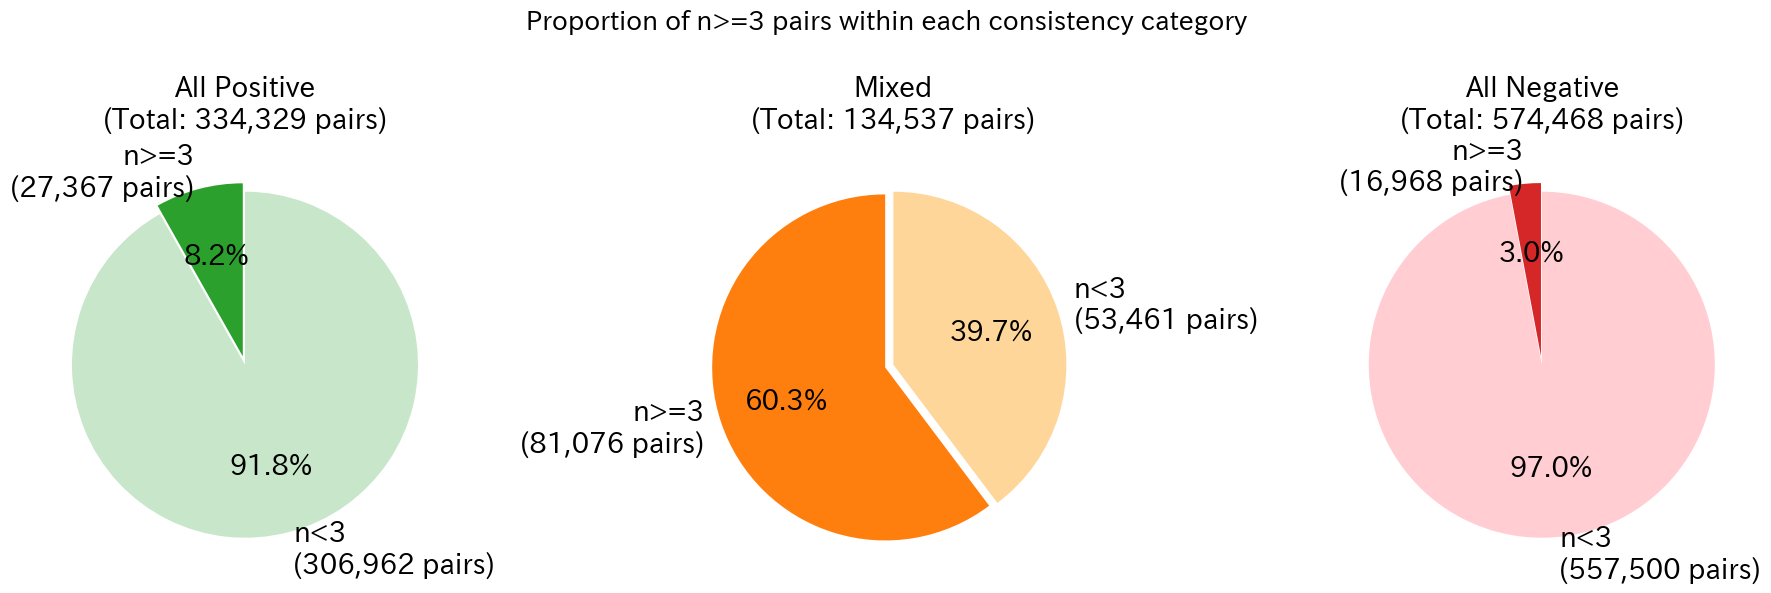


■ Figure: Proportion of n≥3 pairs in each label consistency category


In [101]:
# サンプル数による分析（n≥3の分子ペアのみ）
mol_pair_label_stats_filtered = mol_pair_label_stats[mol_pair_label_stats['total_samples'] >= 3]

print("\n■ Label consistency analysis for molecule pairs (unordered, n≥3):")
print("="*80)

mol_consistency_counts_filtered = mol_pair_label_stats_filtered['consistency'].value_counts()
print("\n【Distribution of label consistency (n≥3)】")
for consistency in consistency_order:
    count = mol_consistency_counts_filtered.get(consistency, 0)
    pct = count / len(mol_pair_label_stats_filtered) * 100 if len(mol_pair_label_stats_filtered) > 0 else 0
    print(f"  {consistency:15s}: {count:6,} pairs ({pct:5.1f}%)")

print(f"\nTotal molecule pairs (unordered, n≥3): {len(mol_pair_label_stats_filtered):,}")

# サンプル数でも集計
print("\n【Sample distribution by label consistency (n≥3)】")
for consistency in consistency_order:
    pairs_subset = mol_pair_label_stats_filtered[mol_pair_label_stats_filtered['consistency'] == consistency]
    total_samples_in_category = pairs_subset['total_samples'].sum()
    total = mol_pair_label_stats_filtered['total_samples'].sum()
    pct = total_samples_in_category / total * 100 if total > 0 else 0
    print(f"  {consistency:15s}: {total_samples_in_category:7,} samples ({pct:5.1f}%)")

print(f"\nTotal samples (n≥3): {mol_pair_label_stats_filtered['total_samples'].sum():,}")

# Mixを除外した場合のサンプル数
mol_pair_label_stats_filtered_no_mix = mol_pair_label_stats_filtered[mol_pair_label_stats_filtered['consistency'] != 'Mixed']
print(f"\n【Excluding Mixed pairs】")
print(f"Total samples (n≥3, excluding Mixed): {mol_pair_label_stats_filtered_no_mix['total_samples'].sum():,}")
print(f"Excluded Mixed samples: {mol_pair_label_stats_filtered[mol_pair_label_stats_filtered['consistency'] == 'Mixed']['total_samples'].sum():,}")

print("="*80)

# 各カテゴリ内でn≥3のペアの割合を円グラフで可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# カテゴリごとの色設定
colors_by_category = {
    'All Positive': ['#2ca02c', '#c8e6c9'],  # 濃い緑、薄い緑
    'Mixed': ['#ff7f0e', '#ffd699'],  # オレンジ、薄いオレンジ
    'All Negative': ['#d62728', '#ffcdd2']  # 濃い赤、薄い赤
}

for idx, consistency in enumerate(consistency_order):
    # 各カテゴリ内のペアを抽出
    category_all_pairs = mol_pair_label_stats[mol_pair_label_stats['consistency'] == consistency]
    category_filtered_pairs = mol_pair_label_stats_filtered[mol_pair_label_stats_filtered['consistency'] == consistency]
    
    # n<3とn>=3のペア数を計算
    n_ge_3 = len(category_filtered_pairs)
    n_lt_3 = len(category_all_pairs) - n_ge_3
    
    # 円グラフのデータ
    sizes = [n_ge_3, n_lt_3]
    labels = [f'n>=3\n({n_ge_3:,} pairs)', f'n<3\n({n_lt_3:,} pairs)']
    colors_pie = colors_by_category[consistency]
    explode = (0.05, 0)
    
    # 全体に対する割合を計算
    total_in_category = len(category_all_pairs)
    pct_ge_3 = (n_ge_3 / total_in_category * 100) if total_in_category > 0 else 0
    
    # 円グラフを描画
    if total_in_category > 0:
        axes[idx].pie(sizes, labels=labels, autopct='%1.1f%%',
                      startangle=90, colors=colors_pie, explode=explode,
                      textprops={'fontsize': 20})
        axes[idx].set_title(f'{consistency}\n(Total: {total_in_category:,} pairs)', 
                           fontsize=20, fontweight='bold', pad=15)
    else:
        axes[idx].text(0.5, 0.5, f'No {consistency} pairs', 
                      ha='center', va='center', fontsize=18)
        axes[idx].set_title(f'{consistency}\n(Total: 0 pairs)', 
                           fontsize=20, fontweight='bold', pad=15)
        axes[idx].axis('off')

plt.suptitle('Proportion of n>=3 pairs within each consistency category', 
             fontsize=19, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n■ Figure: Proportion of n≥3 pairs in each label consistency category")

In [102]:
# フラグメントペアと分子ペア（順不同）の比較
print("\n■ Comparison: Fragment Pairs vs Molecule Pairs (Unordered):")
print("="*80)

# 基本統計の比較
comparison_data = {
    'Metric': [
        'Total pairs',
        'All Positive pairs',
        'All Negative pairs',
        'Mixed pairs',
        'All Positive %',
        'All Negative %',
        'Mixed %'
    ],
    'Fragment Pairs': [
        len(frag_pair_label_stats),
        consistency_counts.get('All Positive', 0),
        consistency_counts.get('All Negative', 0),
        consistency_counts.get('Mixed', 0),
        f"{consistency_counts.get('All Positive', 0) / len(frag_pair_label_stats) * 100:.1f}%",
        f"{consistency_counts.get('All Negative', 0) / len(frag_pair_label_stats) * 100:.1f}%",
        f"{consistency_counts.get('Mixed', 0) / len(frag_pair_label_stats) * 100:.1f}%"
    ],
    'Molecule Pairs (Unordered)': [
        len(mol_pair_label_stats),
        mol_consistency_counts.get('All Positive', 0),
        mol_consistency_counts.get('All Negative', 0),
        mol_consistency_counts.get('Mixed', 0),
        f"{mol_consistency_counts.get('All Positive', 0) / len(mol_pair_label_stats) * 100:.1f}%",
        f"{mol_consistency_counts.get('All Negative', 0) / len(mol_pair_label_stats) * 100:.1f}%",
        f"{mol_consistency_counts.get('Mixed', 0) / len(mol_pair_label_stats) * 100:.1f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n【Comparison Table】")
print(comparison_df.to_string(index=False))
print("="*80)

# Mixedペアの詳細比較
print("\n【Mixed Pairs Details】")
if len(mixed_pairs) > 0:
    frag_mixed_stats = {
        'Mean positive ratio': mixed_pairs['positive_ratio'].mean(),
        'Median positive ratio': mixed_pairs['positive_ratio'].median(),
        'Std positive ratio': mixed_pairs['positive_ratio'].std()
    }
    print("\nFragment Pairs (Mixed):")
    for key, val in frag_mixed_stats.items():
        print(f"  {key:25s}: {val:.4f}")
    
if len(mol_mixed_pairs) > 0:
    mol_mixed_stats = {
        'Mean positive ratio': mol_mixed_pairs['positive_ratio'].mean(),
        'Median positive ratio': mol_mixed_pairs['positive_ratio'].median(),
        'Std positive ratio': mol_mixed_pairs['positive_ratio'].std()
    }
    print("\nMolecule Pairs (Mixed, Unordered):")
    for key, val in mol_mixed_stats.items():
        print(f"  {key:25s}: {val:.4f}")

print("="*80)


■ Comparison: Fragment Pairs vs Molecule Pairs (Unordered):

【Comparison Table】
            Metric Fragment Pairs Molecule Pairs (Unordered)
       Total pairs         890430                    1043334
All Positive pairs         277625                     334329
All Negative pairs         486308                     574468
       Mixed pairs         126497                     134537
    All Positive %          31.2%                      32.0%
    All Negative %          54.6%                      55.1%
           Mixed %          14.2%                      12.9%

【Mixed Pairs Details】

Fragment Pairs (Mixed):
  Mean positive ratio      : 0.4833
  Median positive ratio    : 0.5000
  Std positive ratio       : 0.1276

Molecule Pairs (Mixed, Unordered):
  Mean positive ratio      : 0.4814
  Median positive ratio    : 0.5000
  Std positive ratio       : 0.1393


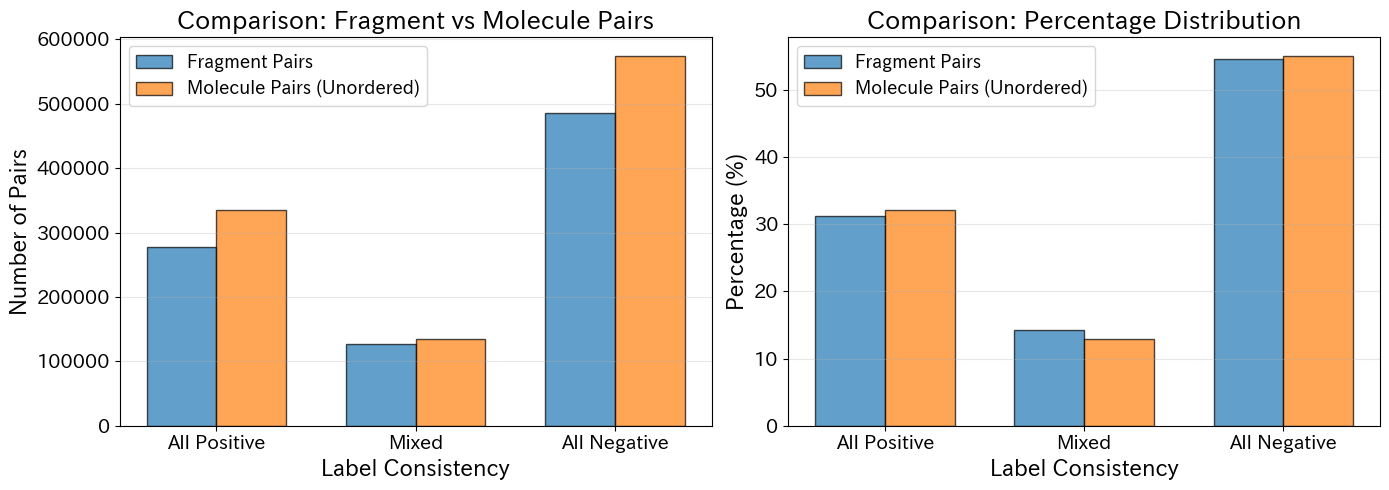

■ Figure: Comparison between fragment pairs and molecule pairs (unordered)


In [103]:
# フラグメントペアと分子ペアの比較可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. ペア数の比較（棒グラフ）
x = np.arange(len(consistency_order))
width = 0.35

frag_counts = [consistency_counts.get(c, 0) for c in consistency_order]
mol_counts = [mol_consistency_counts.get(c, 0) for c in consistency_order]

axes[0].bar(x - width/2, frag_counts, width, label='Fragment Pairs', 
            alpha=0.7, edgecolor='black', color='#1f77b4')
axes[0].bar(x + width/2, mol_counts, width, label='Molecule Pairs (Unordered)', 
            alpha=0.7, edgecolor='black', color='#ff7f0e')

axes[0].set_xlabel('Label Consistency', fontsize=16)
axes[0].set_ylabel('Number of Pairs', fontsize=16)
axes[0].set_title('Comparison: Fragment vs Molecule Pairs', fontsize=18, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(consistency_order, rotation=0, fontsize=14)
axes[0].tick_params(axis='y', labelsize=14)
axes[0].legend(fontsize=13)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. 割合の比較（棒グラフ）
frag_pcts = [consistency_counts.get(c, 0) / len(frag_pair_label_stats) * 100 for c in consistency_order]
mol_pcts = [mol_consistency_counts.get(c, 0) / len(mol_pair_label_stats) * 100 for c in consistency_order]

axes[1].bar(x - width/2, frag_pcts, width, label='Fragment Pairs', 
            alpha=0.7, edgecolor='black', color='#1f77b4')
axes[1].bar(x + width/2, mol_pcts, width, label='Molecule Pairs (Unordered)', 
            alpha=0.7, edgecolor='black', color='#ff7f0e')

axes[1].set_xlabel('Label Consistency', fontsize=16)
axes[1].set_ylabel('Percentage (%)', fontsize=16)
axes[1].set_title('Comparison: Percentage Distribution', fontsize=18, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(consistency_order, rotation=0, fontsize=14)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].legend(fontsize=13)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("■ Figure: Comparison between fragment pairs and molecule pairs (unordered)")


■ Representative examples of each consistency category:

【All Positive】 (Top 3 by sample count)

  Example 1:
    Fragment pair: REF: *
                   PRB: /
    Total samples: 29
    Positive: 29 (100.0%), Negative: 0 (0.0%)
    ⚠ Failed to parse PRB-FRAG structure


[23:36:57] SMILES Parse Error: syntax error while parsing: /
[23:36:57] SMILES Parse Error: Failed parsing SMILES '/' for input: '/'


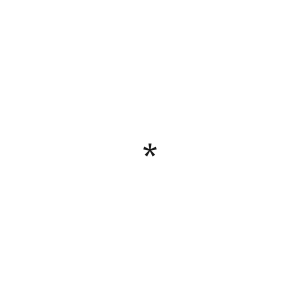

    ----------------------------------------------------------------------------

  Example 2:
    Fragment pair: REF: *
                   PRB: C
    Total samples: 29
    Positive: 29 (100.0%), Negative: 0 (0.0%)


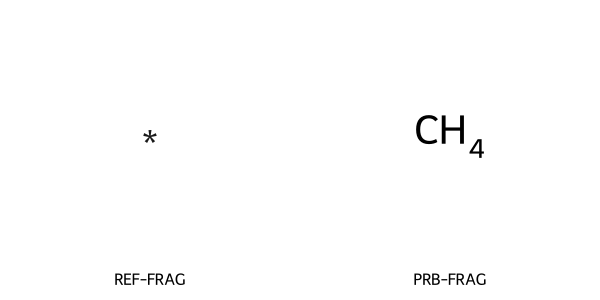

    ----------------------------------------------------------------------------

  Example 3:
    Fragment pair: REF: *
                   PRB: /
    Total samples: 27
    Positive: 27 (100.0%), Negative: 0 (0.0%)
    ⚠ Failed to parse PRB-FRAG structure


[23:36:57] SMILES Parse Error: syntax error while parsing: /
[23:36:57] SMILES Parse Error: Failed parsing SMILES '/' for input: '/'


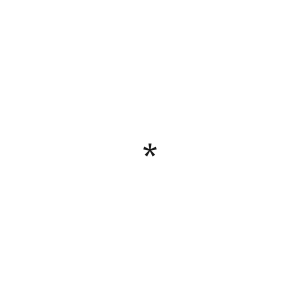

    ----------------------------------------------------------------------------
--------------------------------------------------------------------------------

【Mixed】 (Top 3 by sample count)

  Example 1:
    Fragment pair: REF: *
                   PRB: C
    Total samples: 2607
    Positive: 1442 (55.3%), Negative: 1165 (44.7%)


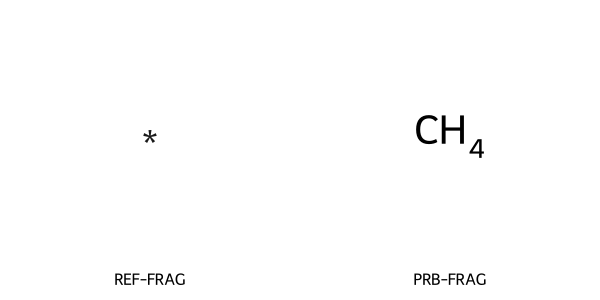

    ----------------------------------------------------------------------------

  Example 2:
    Fragment pair: REF: *
                   PRB: C
    Total samples: 2524
    Positive: 1380 (54.7%), Negative: 1144 (45.3%)


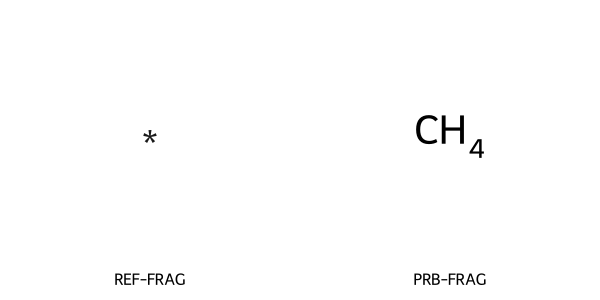

    ----------------------------------------------------------------------------

  Example 3:
    Fragment pair: REF: *
                   PRB: C
    Total samples: 1354
    Positive: 647 (47.8%), Negative: 707 (52.2%)


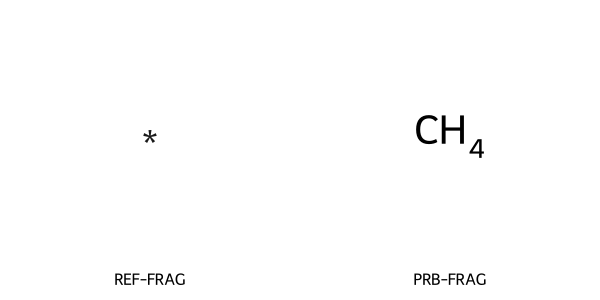

    ----------------------------------------------------------------------------
--------------------------------------------------------------------------------

【All Negative】 (Top 3 by sample count)

  Example 1:
    Fragment pair: REF: *
                   PRB: C
    Total samples: 27
    Positive: 0 (0.0%), Negative: 27 (100.0%)


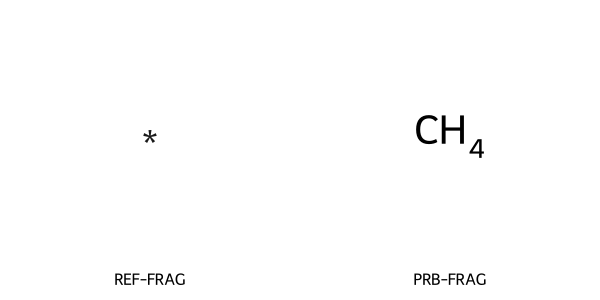

    ----------------------------------------------------------------------------

  Example 2:
    Fragment pair: REF: *
                   PRB: N
    Total samples: 24
    Positive: 0 (0.0%), Negative: 24 (100.0%)


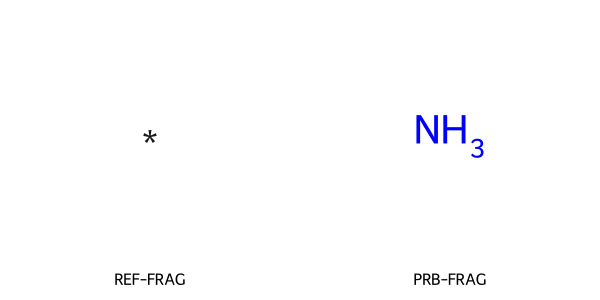

    ----------------------------------------------------------------------------

  Example 3:
    Fragment pair: REF: *
                   PRB: N
    Total samples: 22
    Positive: 0 (0.0%), Negative: 22 (100.0%)


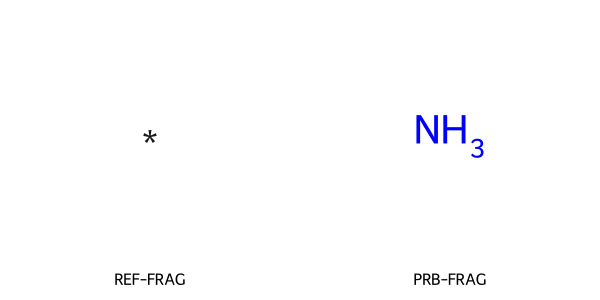

    ----------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [104]:
# 各カテゴリの代表例を表示（構造式付き）
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

print("\n■ Representative examples of each consistency category:")
print("="*80)

for consistency in consistency_order:
    subset = frag_pair_label_stats_filtered[frag_pair_label_stats_filtered['consistency'] == consistency]
    if len(subset) > 0:
        # サンプル数が多い順にTop 3を表示
        top_examples = subset.nlargest(3, 'total_samples')
        
        print(f"\n【{consistency}】 (Top 3 by sample count)")
        
        for idx, (_, row) in enumerate(top_examples.iterrows(), 1):
            frag_pair = row['FRAG_PAIR']
            total = row['total_samples']
            pos_count = row['positive_count']
            neg_count = row['negative_count']
            pos_ratio = row['positive_ratio']
            
            # フラグメントを取得
            ref_frag = frag_pair[0]
            prb_frag = frag_pair[1]
            
            print(f"\n  Example {idx}:")
            print(f"    Fragment pair: REF: {ref_frag[:60]}{'...' if len(ref_frag) > 60 else ''}")
            print(f"                   PRB: {prb_frag[:60]}{'...' if len(prb_frag) > 60 else ''}")
            print(f"    Total samples: {total}")
            print(f"    Positive: {pos_count} ({pos_ratio*100:.1f}%), Negative: {neg_count} ({(1-pos_ratio)*100:.1f}%)")
            
            # 構造式を可視化
            mols = []
            legends = []
            
            # REF-FRAGを分子として解釈
            try:
                mol_ref = Chem.MolFromSmiles(ref_frag)
                if mol_ref:
                    mols.append(mol_ref)
                    legends.append(f"REF-FRAG")
                else:
                    print("    ⚠ Failed to parse REF-FRAG structure")
            except Exception as e:
                print(f"    ⚠ REF-FRAG error: {e}")
            
            # PRB-FRAGを分子として解釈
            try:
                mol_prb = Chem.MolFromSmiles(prb_frag)
                if mol_prb:
                    mols.append(mol_prb)
                    legends.append(f"PRB-FRAG")
                else:
                    print("    ⚠ Failed to parse PRB-FRAG structure")
            except Exception as e:
                print(f"    ⚠ PRB-FRAG error: {e}")
            
            # 2つの構造を横に並べて表示
            if len(mols) == 2:
                img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300, 300), 
                                             legends=legends)
                display(img)
            elif len(mols) == 1:
                img = Draw.MolToImage(mols[0], size=(300, 300))
                display(img)
            
            print("    " + "-"*76)
    else:
        print(f"\n【{consistency}】")
        print(f"  No examples found")
    print("-"*80)


■ Relationship between consistency and sample count:


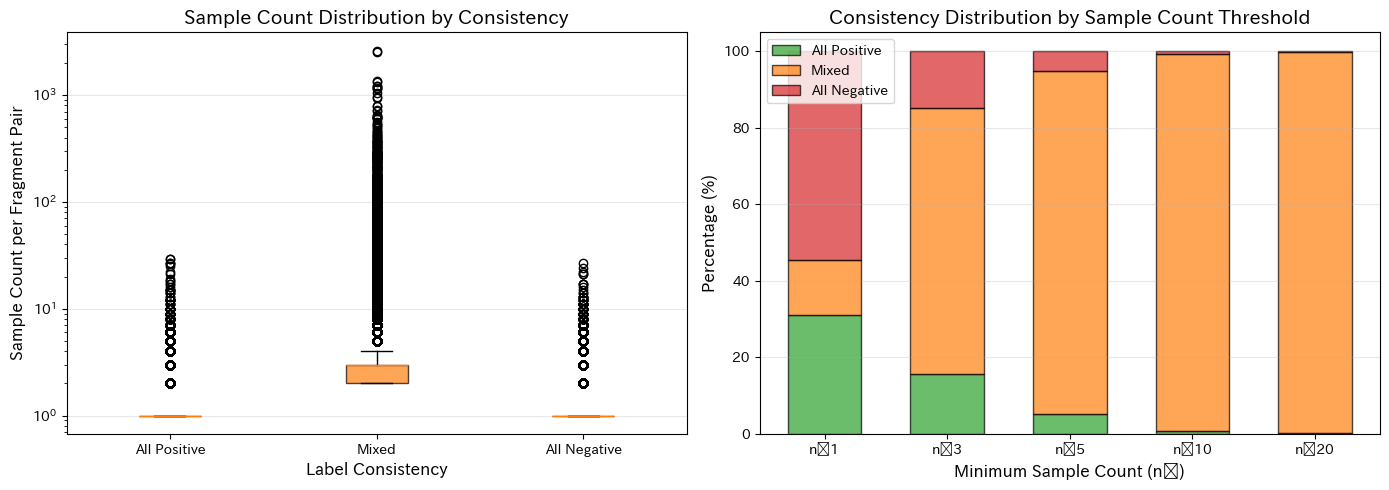


【Consistency percentage by sample count threshold】
Threshold      All Positive          Mixed   All Negative
------------------------------------------------------------
n≥1                   31.2%          14.2%          54.6%
n≥3                   15.6%          69.5%          14.9%
n≥5                    5.2%          89.7%           5.1%
n≥10                   0.7%          98.6%           0.8%
n≥20                   0.3%          99.5%           0.2%


In [105]:
# 一貫性とサンプル数の関係を分析
print("\n■ Relationship between consistency and sample count:")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 各カテゴリのサンプル数分布（ボックスプロット）
consistency_data = []
consistency_labels = []
for consistency in consistency_order:
    subset = frag_pair_label_stats[frag_pair_label_stats['consistency'] == consistency]
    if len(subset) > 0:
        consistency_data.append(subset['total_samples'].values)
        consistency_labels.append(consistency)

if consistency_data:
    bp = axes[0].boxplot(consistency_data, labels=consistency_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors[:len(consistency_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[0].set_xlabel('Label Consistency', fontsize=12)
    axes[0].set_ylabel('Sample Count per Fragment Pair', fontsize=12)
    axes[0].set_title('Sample Count Distribution by Consistency', fontsize=14, fontweight='bold')
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3, axis='y')

# 2. サンプル数閾値ごとの一貫性分布
thresholds_analysis = [1, 3, 5, 10, 20]
consistency_by_threshold = {c: [] for c in consistency_order}

for threshold in thresholds_analysis:
    subset = frag_pair_label_stats[frag_pair_label_stats['total_samples'] >= threshold]
    total = len(subset)
    for consistency in consistency_order:
        count = len(subset[subset['consistency'] == consistency])
        pct = count / total * 100 if total > 0 else 0
        consistency_by_threshold[consistency].append(pct)

# 積み上げ棒グラフ
x = np.arange(len(thresholds_analysis))
width = 0.6
bottom = np.zeros(len(thresholds_analysis))

for consistency, color in zip(consistency_order, colors):
    axes[1].bar(x, consistency_by_threshold[consistency], width, 
                label=consistency, bottom=bottom, color=color, alpha=0.7, edgecolor='black')
    bottom += consistency_by_threshold[consistency]

axes[1].set_xlabel('Minimum Sample Count (n≥)', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_title('Consistency Distribution by Sample Count Threshold', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'n≥{t}' for t in thresholds_analysis])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 数値データも表示
print("\n【Consistency percentage by sample count threshold】")
print(f"{'Threshold':<12}", end='')
for c in consistency_order:
    print(f"{c:>15s}", end='')
print()
print("-"*60)

for i, threshold in enumerate(thresholds_analysis):
    print(f"{'n≥'+str(threshold):<12}", end='')
    for consistency in consistency_order:
        print(f"{consistency_by_threshold[consistency][i]:14.1f}%", end='')
    print()
print("="*80)

■ Detailed analysis of Mixed category:

【Basic statistics for Mixed pairs】
Total Mixed pairs: 126,497
Total samples in Mixed pairs: 566,293

Positive ratio statistics:
count    126497.000000
mean          0.483335
std           0.127607
min           0.037037
25%           0.400000
50%           0.500000
75%           0.500000
max           0.968750
Name: positive_ratio, dtype: float64

【Distribution by positive ratio range】

By fragment pair count:
  Positive 0-20%     :  2,881 pairs (  2.3%)
  Positive 20-40%    : 29,420 pairs ( 23.3%)
  Positive 40-60%    : 74,070 pairs ( 58.6%)
  Positive 60-80%    : 19,325 pairs ( 15.3%)
  Positive 80-100%   :    801 pairs (  0.6%)

By sample count:
  Positive 0-20%     :  20,360 samples (  3.6%)
  Positive 20-40%    : 152,893 samples ( 27.0%)
  Positive 40-60%    : 300,438 samples ( 53.1%)
  Positive 60-80%    :  86,236 samples ( 15.2%)
  Positive 80-100%   :   6,366 samples (  1.1%)


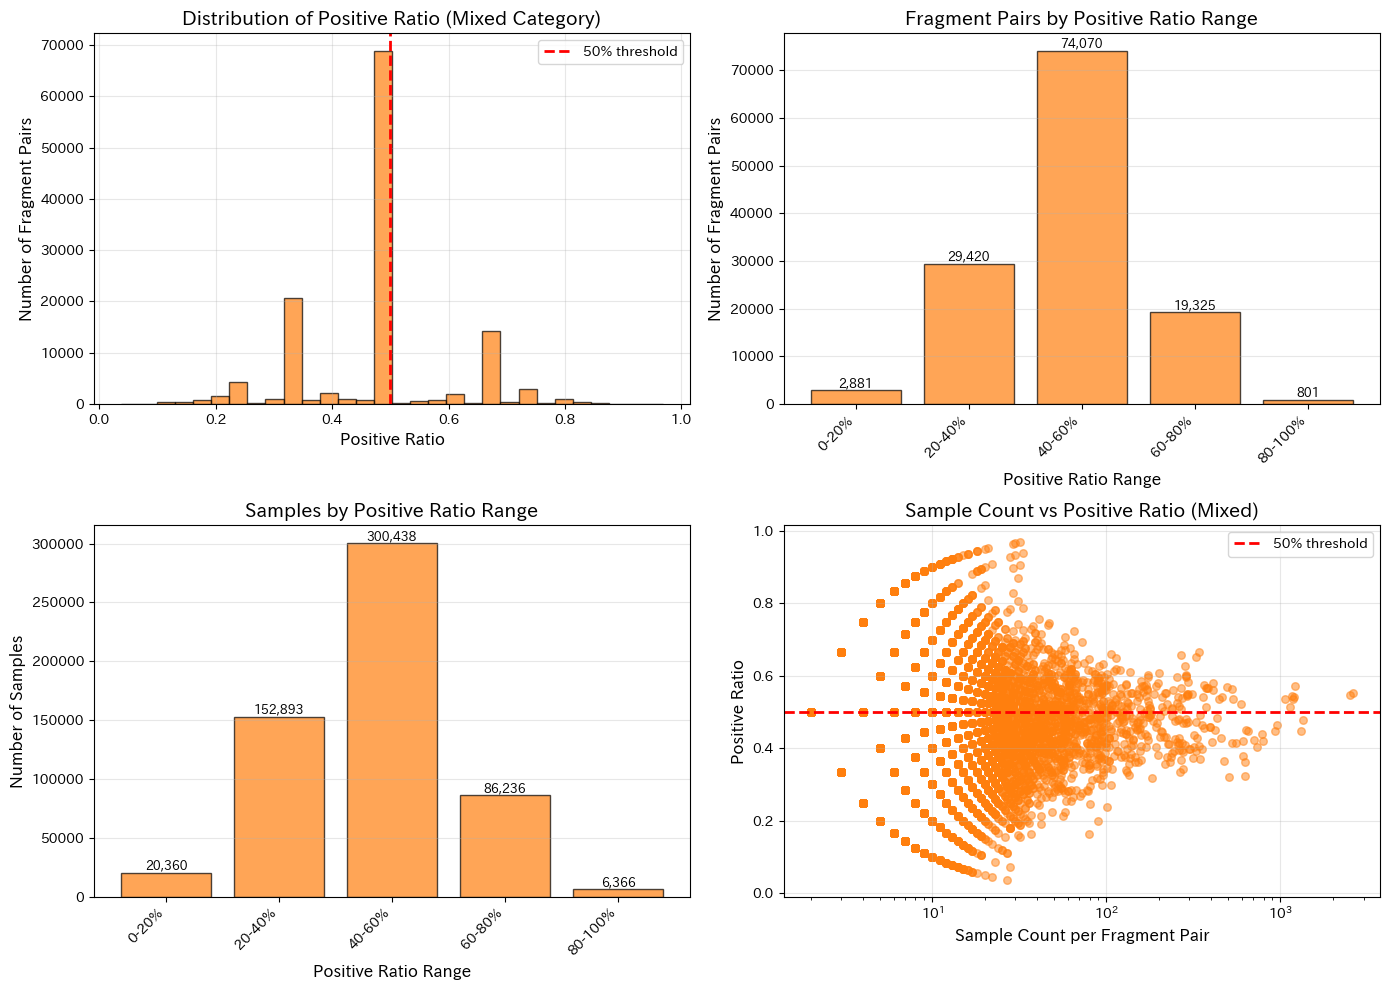


■ Figure: Detailed analysis of Mixed category


In [106]:
# Mixedカテゴリの詳細分析：positive/negativeの割合
mixed_pairs = frag_pair_label_stats[frag_pair_label_stats['consistency'] == 'Mixed']

if len(mixed_pairs) > 0:
    print("■ Detailed analysis of Mixed category:")
    print("="*80)
    
    # 基本統計
    print("\n【Basic statistics for Mixed pairs】")
    print(f"Total Mixed pairs: {len(mixed_pairs):,}")
    print(f"Total samples in Mixed pairs: {mixed_pairs['total_samples'].sum():,}")
    print(f"\nPositive ratio statistics:")
    print(mixed_pairs['positive_ratio'].describe())
    
    # positive_ratioで区分
    print("\n【Distribution by positive ratio range】")
    ratio_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ratio_labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
    
    mixed_pairs['ratio_category'] = pd.cut(mixed_pairs['positive_ratio'], 
                                            bins=ratio_bins, 
                                            labels=ratio_labels, 
                                            include_lowest=True)
    
    ratio_dist = mixed_pairs['ratio_category'].value_counts().sort_index()
    print("\nBy fragment pair count:")
    for category, count in ratio_dist.items():
        pct = count / len(mixed_pairs) * 100
        print(f"  Positive {category:10s}: {count:6,} pairs ({pct:5.1f}%)")
    
    # サンプル数でも集計
    print("\nBy sample count:")
    for category in ratio_labels:
        subset = mixed_pairs[mixed_pairs['ratio_category'] == category]
        sample_count = subset['total_samples'].sum()
        pct = sample_count / mixed_pairs['total_samples'].sum() * 100
        print(f"  Positive {category:10s}: {sample_count:7,} samples ({pct:5.1f}%)")
    
    # 可視化
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. positive_ratioのヒストグラム（詳細）
    axes[0, 0].hist(mixed_pairs['positive_ratio'], bins=30, 
                    alpha=0.7, color='#ff7f0e', edgecolor='black')
    axes[0, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    axes[0, 0].set_xlabel('Positive Ratio', fontsize=12)
    axes[0, 0].set_ylabel('Number of Fragment Pairs', fontsize=12)
    axes[0, 0].set_title('Distribution of Positive Ratio (Mixed Category)', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. positive_ratio区分別のペア数（棒グラフ）
    axes[0, 1].bar(range(len(ratio_dist)), ratio_dist.values, 
                   color='#ff7f0e', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Positive Ratio Range', fontsize=12)
    axes[0, 1].set_ylabel('Number of Fragment Pairs', fontsize=12)
    axes[0, 1].set_title('Fragment Pairs by Positive Ratio Range', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(range(len(ratio_dist)))
    axes[0, 1].set_xticklabels(ratio_dist.index, rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    for i, count in enumerate(ratio_dist.values):
        axes[0, 1].text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    # 3. サンプル数別の分布（棒グラフ）
    sample_counts_by_ratio = []
    for category in ratio_labels:
        subset = mixed_pairs[mixed_pairs['ratio_category'] == category]
        sample_counts_by_ratio.append(subset['total_samples'].sum())
    
    axes[1, 0].bar(range(len(ratio_labels)), sample_counts_by_ratio, 
                   color='#ff7f0e', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Positive Ratio Range', fontsize=12)
    axes[1, 0].set_ylabel('Number of Samples', fontsize=12)
    axes[1, 0].set_title('Samples by Positive Ratio Range', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(range(len(ratio_labels)))
    axes[1, 0].set_xticklabels(ratio_labels, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    for i, count in enumerate(sample_counts_by_ratio):
        axes[1, 0].text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    # 4. サンプル数 vs positive_ratio の散布図
    axes[1, 1].scatter(mixed_pairs['total_samples'], mixed_pairs['positive_ratio'], 
                       alpha=0.5, s=30, color='#ff7f0e')
    axes[1, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    axes[1, 1].set_xlabel('Sample Count per Fragment Pair', fontsize=12)
    axes[1, 1].set_ylabel('Positive Ratio', fontsize=12)
    axes[1, 1].set_title('Sample Count vs Positive Ratio (Mixed)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n■ Figure: Detailed analysis of Mixed category")
    print("="*80)
    
else:
    print("■ No Mixed pairs found in the dataset")
    print("="*80)


■ Label distribution (0 vs 1) within Mixed category by positive ratio range:

Positive ratio 0-20%     :
  Label 1 (Positive):   3,389 samples ( 16.6%)
  Label 0 (Negative):  16,971 samples ( 83.4%)
  Total:               20,360 samples

Positive ratio 20-40%    :
  Label 1 (Positive):  50,100 samples ( 32.8%)
  Label 0 (Negative): 102,793 samples ( 67.2%)
  Total:              152,893 samples

Positive ratio 40-60%    :
  Label 1 (Positive): 150,500 samples ( 50.1%)
  Label 0 (Negative): 149,938 samples ( 49.9%)
  Total:              300,438 samples

Positive ratio 60-80%    :
  Label 1 (Positive):  59,111 samples ( 68.5%)
  Label 0 (Negative):  27,125 samples ( 31.5%)
  Total:               86,236 samples

Positive ratio 80-100%   :
  Label 1 (Positive):   5,470 samples ( 85.9%)
  Label 0 (Negative):     896 samples ( 14.1%)
  Total:                6,366 samples


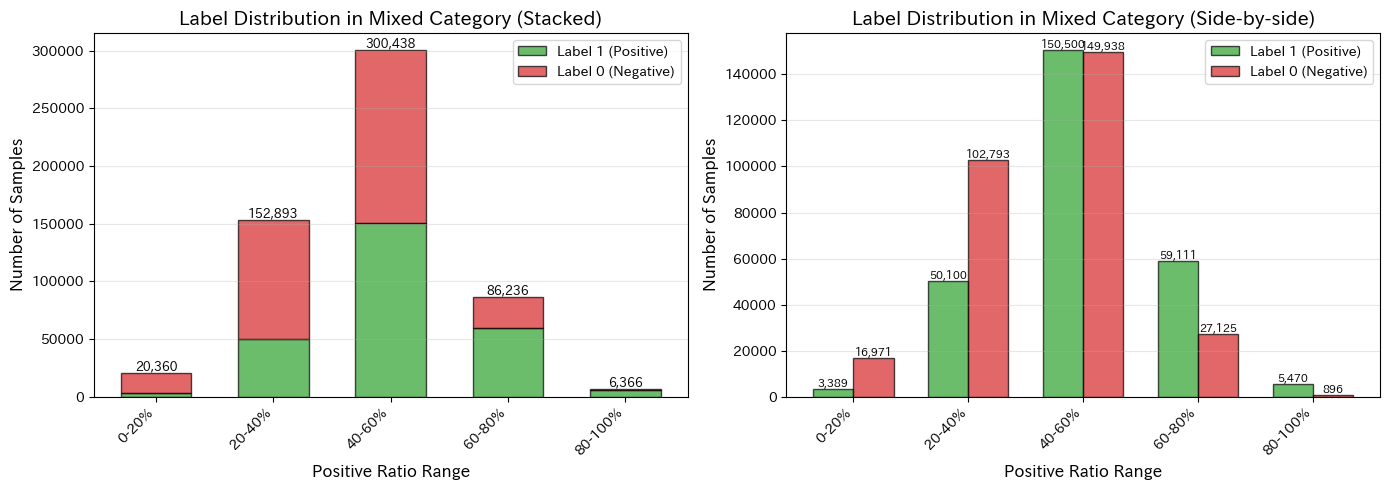


■ Figure: Label 0 vs Label 1 distribution within Mixed category

【Overall summary for Mixed category】
Total samples in Mixed pairs: 566,293
  Label 1 (Positive): 268,570 samples (47.4%)
  Label 0 (Negative): 297,723 samples (52.6%)


In [107]:
# Mixedカテゴリ：positive_ratio区分ごとのLabel 0/1の実際のサンプル数を可視化
if len(mixed_pairs) > 0:
    print("\n■ Label distribution (0 vs 1) within Mixed category by positive ratio range:")
    print("="*80)
    
    # 各positive_ratio区分内でのpositive(label=1)とnegative(label=0)のサンプル数を集計
    positive_samples_by_ratio = []
    negative_samples_by_ratio = []
    
    for category in ratio_labels:
        subset = mixed_pairs[mixed_pairs['ratio_category'] == category]
        pos_samples = subset['positive_count'].sum()
        neg_samples = subset['negative_count'].sum()
        positive_samples_by_ratio.append(pos_samples)
        negative_samples_by_ratio.append(neg_samples)
        
        total = pos_samples + neg_samples
        pos_pct = pos_samples / total * 100 if total > 0 else 0
        neg_pct = neg_samples / total * 100 if total > 0 else 0
        print(f"\nPositive ratio {category:10s}:")
        print(f"  Label 1 (Positive): {pos_samples:7,} samples ({pos_pct:5.1f}%)")
        print(f"  Label 0 (Negative): {neg_samples:7,} samples ({neg_pct:5.1f}%)")
        print(f"  Total:              {total:7,} samples")
    
    # 可視化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. 積み上げ棒グラフ（Label 0とLabel 1）
    x = np.arange(len(ratio_labels))
    width = 0.6
    
    p1 = axes[0].bar(x, positive_samples_by_ratio, width, 
                     label='Label 1 (Positive)', color='#2ca02c', alpha=0.7, edgecolor='black')
    p2 = axes[0].bar(x, negative_samples_by_ratio, width, bottom=positive_samples_by_ratio,
                     label='Label 0 (Negative)', color='#d62728', alpha=0.7, edgecolor='black')
    
    axes[0].set_xlabel('Positive Ratio Range', fontsize=12)
    axes[0].set_ylabel('Number of Samples', fontsize=12)
    axes[0].set_title('Label Distribution in Mixed Category (Stacked)', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(ratio_labels, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # 総数を表示
    for i, (pos, neg) in enumerate(zip(positive_samples_by_ratio, negative_samples_by_ratio)):
        total = pos + neg
        axes[0].text(i, total, f'{total:,}', ha='center', va='bottom', fontsize=9)
    
    # 2. 並列棒グラフ（Label 0とLabel 1）
    width = 0.35
    x = np.arange(len(ratio_labels))
    
    axes[1].bar(x - width/2, positive_samples_by_ratio, width, 
                label='Label 1 (Positive)', color='#2ca02c', alpha=0.7, edgecolor='black')
    axes[1].bar(x + width/2, negative_samples_by_ratio, width, 
                label='Label 0 (Negative)', color='#d62728', alpha=0.7, edgecolor='black')
    
    axes[1].set_xlabel('Positive Ratio Range', fontsize=12)
    axes[1].set_ylabel('Number of Samples', fontsize=12)
    axes[1].set_title('Label Distribution in Mixed Category (Side-by-side)', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(ratio_labels, rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # 各バーの上に数値を表示
    for i, (pos, neg) in enumerate(zip(positive_samples_by_ratio, negative_samples_by_ratio)):
        axes[1].text(i - width/2, pos, f'{pos:,}', ha='center', va='bottom', fontsize=8)
        axes[1].text(i + width/2, neg, f'{neg:,}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("\n■ Figure: Label 0 vs Label 1 distribution within Mixed category")
    print("="*80)
    
    # サマリー統計
    total_positive = sum(positive_samples_by_ratio)
    total_negative = sum(negative_samples_by_ratio)
    total_mixed = total_positive + total_negative
    
    print(f"\n【Overall summary for Mixed category】")
    print(f"Total samples in Mixed pairs: {total_mixed:,}")
    print(f"  Label 1 (Positive): {total_positive:,} samples ({total_positive/total_mixed*100:.1f}%)")
    print(f"  Label 0 (Negative): {total_negative:,} samples ({total_negative/total_mixed*100:.1f}%)")
    print("="*80)

## 6. 置換基ごとの詳細分析

各置換基（REF-FRAGまたはPRB-FRAG）について、その置換基を含む分子ペアをサンプリングし、pos/negの割合を表示します。

In [112]:
# 置換基ごとの分析: 置換基のSMILESを入力として受け取る関数
def analyze_substituent(substituent_smiles, df, max_examples=5, random_seed=42):
    """
    指定された置換基SMILESを含む分子ペアを分析
    
    Parameters:
    -----------
    substituent_smiles : str
        検索する置換基のSMILES
    df : DataFrame
        元データ
    max_examples : int
        表示する最大例数
    random_seed : int
        ランダムサンプリングのシード値
    """
    import re
    from rdkit import Chem
    from rdkit.Chem import Draw
    
    # ダミー原子を正規化する関数
    def normalize_frag(frag_str):
        if pd.isna(frag_str):
            return frag_str
        return re.sub(r'\[\d+\*\]', '[*]', str(frag_str))
    
    # 入力された置換基を正規化
    search_pattern = normalize_frag(substituent_smiles)
    
    # REF-FRAGまたはPRB-FRAGに正規化された置換基が含まれる行を抽出
    df_copy = df.copy()
    df_copy['REF-FRAG_norm'] = df_copy['REF-FRAG'].apply(normalize_frag)
    df_copy['PRB-FRAG_norm'] = df_copy['PRB-FRAG'].apply(normalize_frag)
    
    mask = (df_copy['REF-FRAG_norm'] == search_pattern) | (df_copy['PRB-FRAG_norm'] == search_pattern)
    df_matched = df_copy[mask]
    
    if len(df_matched) == 0:
        print(f"⚠ 置換基 '{substituent_smiles}' を含む分子ペアが見つかりませんでした。")
        return
    
    print(f"■ 置換基分析: {substituent_smiles}")
    print("="*80)
    print(f"\n【全体統計】")
    print(f"  該当する分子ペア数: {len(df_matched):,} 件")
    
    # label_binの分布
    n_positive = (df_matched['label_bin'] == True).sum()
    n_negative = (df_matched['label_bin'] == False).sum()
    total = len(df_matched)
    
    print(f"\n【ラベル分布】")
    print(f"  Positive (label=True):  {n_positive:,} 件 ({n_positive/total*100:.1f}%)")
    print(f"  Negative (label=False): {n_negative:,} 件 ({n_negative/total*100:.1f}%)")
    
    # 統計情報
    print(f"\n【ΔpIC50統計】")
    print(f"  平均: {df_matched['delta_value'].mean():.3f}")
    print(f"  中央値: {df_matched['delta_value'].median():.3f}")
    print(f"  標準偏差: {df_matched['delta_value'].std():.3f}")
    print(f"  範囲: [{df_matched['delta_value'].min():.3f}, {df_matched['delta_value'].max():.3f}]")
    
    # 標的・アッセイ数
    print(f"\n【標的・アッセイ】")
    print(f"  標的数 (TID): {df_matched['TID'].nunique():,}")
    print(f"  アッセイ数 (AID): {df_matched['AID'].nunique():,}")
    
    # ランダムサンプリング
    n_samples = min(max_examples, len(df_matched))
    sampled = df_matched.sample(n=n_samples, random_state=random_seed)
    
    print(f"\n【分子ペアの例（ランダムに{n_samples}件）】")
    print("="*80)
    
    for idx, (_, row) in enumerate(sampled.iterrows(), 1):
        print(f"\n例 {idx}:")
        print(f"  REF-CID: {row['REF-CID']}, PRB-CID: {row['PRB-CID']}")
        print(f"  REF-FRAG: {row['REF-FRAG']}")
        print(f"  PRB-FRAG: {row['PRB-FRAG']}")
        print(f"  REF-SMILES: {row['REF-SMILES'][:60]}...")
        print(f"  PRB-SMILES: {row['PRB-SMILES'][:60]}...")
        print(f"  ΔpIC50: {row['delta_value']:.3f}")
        print(f"  Label: {row['label_bin']}")
        print(f"  TID: {row['TID']}, AID: {row['AID']}")
        
        # 分子構造の可視化
        try:
            ref_mol = Chem.MolFromSmiles(row['REF-SMILES'])
            prb_mol = Chem.MolFromSmiles(row['PRB-SMILES'])
            
            if ref_mol and prb_mol:
                img = Draw.MolsToGridImage(
                    [ref_mol, prb_mol],
                    molsPerRow=2,
                    subImgSize=(350, 250),
                    legends=[f"REF (CID:{row['REF-CID']})", f"PRB (CID:{row['PRB-CID']})"]
                )
                display(img)
        except Exception as e:
            print(f"  ⚠ 構造式の描画エラー: {e}")
        
        print("-" * 80)
    
    print("\n" + "="*80)
    return df_matched

# 使用例を表示
print("■ 使用方法:")
print("  result = analyze_substituent('置換基SMILES', df, max_examples=5)")
print("  例: result = analyze_substituent('[*]c1ccccc1', df)")
print("  ※ ダミー原子は [*] または [数字*] の形式で指定")

■ 使用方法:
  result = analyze_substituent('置換基SMILES', df, max_examples=5)
  例: result = analyze_substituent('[*]c1ccccc1', df)
  ※ ダミー原子は [*] または [数字*] の形式で指定


In [113]:
# 頻度の高い置換基トップ10を取得
import re

def normalize_frag(frag_str):
    if pd.isna(frag_str):
        return frag_str
    return re.sub(r'\[\d+\*\]', '[*]', str(frag_str))

# REFとPRBのフラグメントを正規化して結合
all_frags = pd.concat([
    df['REF-FRAG'].apply(normalize_frag),
    df['PRB-FRAG'].apply(normalize_frag)
])

frag_counts = all_frags.value_counts()

print("■ 頻度の高い置換基 Top 10")
print("="*80)
print(f"{'順位':<5} {'出現回数':<10} {'置換基SMILES'}")
print("-"*80)
for i, (frag, count) in enumerate(frag_counts.head(10).items(), 1):
    print(f"{i:<5} {count:<10,} {frag}")
print("="*80)

■ 頻度の高い置換基 Top 10
順位    出現回数       置換基SMILES
--------------------------------------------------------------------------------
1     40,574     *C
2     23,795     *Cc1ccccc1
3     15,489     *O
4     13,020     *C*
5     12,626     *CC*
6     12,363     *CC
7     11,626     *N
8     10,614     *N1CCOCC1
9     10,406     *C(C)C
10    10,073     *C1CC1


### 実例: 頻度の高い置換基の分析

最も頻度の高い置換基について詳細分析を実行します。

分析対象: 第1位の置換基



■ 置換基分析: *C

【全体統計】
  該当する分子ペア数: 40,574 件

【ラベル分布】
  Positive (label=True):  17,789 件 (43.8%)
  Negative (label=False): 22,785 件 (56.2%)

【ΔpIC50統計】
  平均: -0.003
  中央値: 0.000
  標準偏差: 0.744
  範囲: [-6.645, 4.586]

【標的・アッセイ】
  標的数 (TID): 1,269
  アッセイ数 (AID): 5,550

【分子ペアの例（ランダムに5件）】

例 1:
  REF-CID: CHEMBL2325903, PRB-CID: CHEMBL2325901
  REF-FRAG: *C(C)(C)C
  PRB-FRAG: *C
  REF-SMILES: C[C@H](NC(=O)c1c[nH]c2ncc(C3CC3)nc12)C(C)(C)C...
  PRB-SMILES: CC(C)NC(=O)c1c[nH]c2ncc(C3CC3)nc12...
  ΔpIC50: -0.702
  Label: False
  TID: CHEMBL2835, AID: 939262


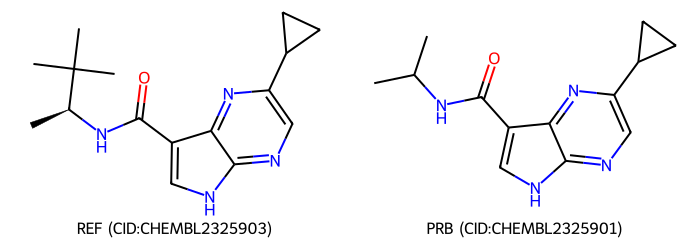

--------------------------------------------------------------------------------

例 2:
  REF-CID: CHEMBL4101316, PRB-CID: CHEMBL4072879
  REF-FRAG: *CCOC
  PRB-FRAG: *C
  REF-SMILES: COCCNCc1ccc2ccc(Cl)c(C3=C(c4cn(C)c5ccccc45)C(=O)NC3=O)c2c1...
  PRB-SMILES: CNCc1ccc2ccc(Cl)c(C3=C(c4cn(C)c5ccccc45)C(=O)NC3=O)c2c1...
  ΔpIC50: 0.564
  Label: False
  TID: CHEMBL3582, AID: 1655177


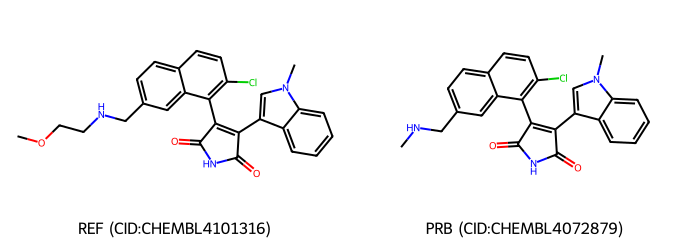

--------------------------------------------------------------------------------

例 3:
  REF-CID: CHEMBL3906894, PRB-CID: CHEMBL3942763
  REF-FRAG: *C
  PRB-FRAG: *CO
  REF-SMILES: COc1cc(OC)cc(N(CCCN2CCC[C@@H]2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)...
  PRB-SMILES: COc1cc(OC)cc(N(CCCN2CCC[C@@H]2CO)c2ccc3ncc(-c4cnn(C)c4)nc3c2...
  ΔpIC50: 0.000
  Label: True
  TID: CHEMBL1974, AID: 1637333


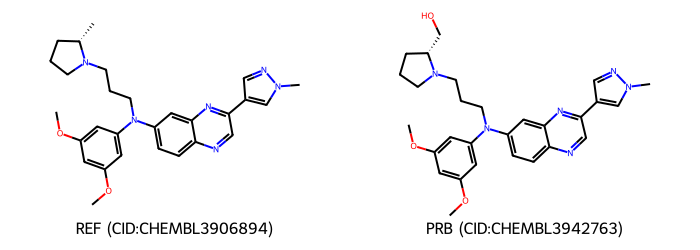

--------------------------------------------------------------------------------

例 4:
  REF-CID: CHEMBL1823677, PRB-CID: CHEMBL1823880
  REF-FRAG: *C
  PRB-FRAG: *C1CCC1
  REF-SMILES: CCOc1ccccc1C(=O)NCC1(N2CCN(C)CC2)CCCCC1...
  PRB-SMILES: CCOc1ccccc1C(=O)NCC1(N2CCN(C3CCC3)CC2)CCCCC1...
  ΔpIC50: 0.200
  Label: True
  TID: CHEMBL1795171, AID: 767270


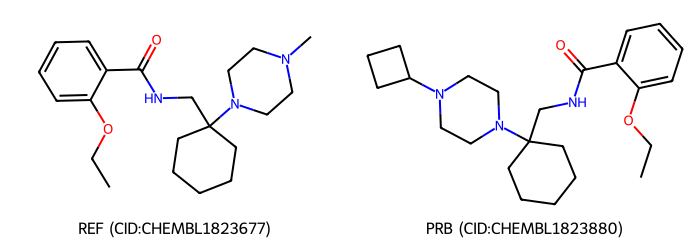

--------------------------------------------------------------------------------

例 5:
  REF-CID: CHEMBL132756, PRB-CID: CHEMBL436376
  REF-FRAG: *C
  PRB-FRAG: *CC
  REF-SMILES: COc1ccc(F)c(CC/N=C(\S)Nc2ccc(Br)cn2)c1C#N...
  PRB-SMILES: CCOc1ccc(F)c(CC/N=C(\S)Nc2ccc(Br)cn2)c1C#N...
  ΔpIC50: -0.301
  Label: False
  TID: CHEMBL247, AID: 195685


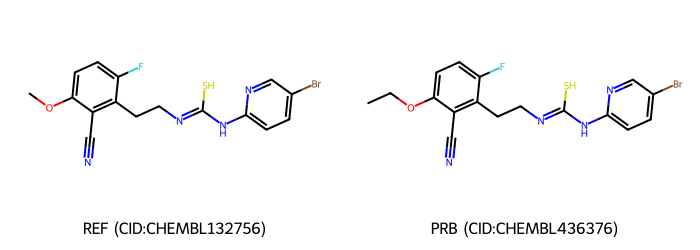

--------------------------------------------------------------------------------



In [114]:
# 例1: 最も頻度の高い置換基を分析
if len(frag_counts) > 0:
    top_frag = frag_counts.index[0]
    print(f"分析対象: 第1位の置換基\n")
    result_1 = analyze_substituent(top_frag, df, max_examples=5, random_seed=42)



分析対象: 第2位の置換基



■ 置換基分析: *Cc1ccccc1

【全体統計】
  該当する分子ペア数: 23,795 件

【ラベル分布】
  Positive (label=True):  9,469 件 (39.8%)
  Negative (label=False): 14,326 件 (60.2%)

【ΔpIC50統計】
  平均: 0.014
  中央値: 0.000
  標準偏差: 0.812
  範囲: [-4.602, 4.586]

【標的・アッセイ】
  標的数 (TID): 824
  アッセイ数 (AID): 2,565

【分子ペアの例（ランダムに5件）】

例 1:
  REF-CID: CHEMBL4104552, PRB-CID: CHEMBL4066908
  REF-FRAG: *Cc1ccccc1
  PRB-FRAG: *Cc1ccccc1OC
  REF-SMILES: CCN(CCCN1C(=O)c2ccccc2C1=O)Cc1ccccc1...
  PRB-SMILES: CCN(CCCN1C(=O)c2ccccc2C1=O)Cc1ccccc1OC...
  ΔpIC50: 0.167
  Label: True
  TID: CHEMBL2039, AID: 1697199


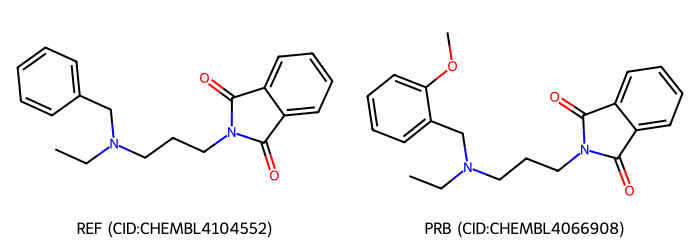

--------------------------------------------------------------------------------

例 2:
  REF-CID: CHEMBL3913893, PRB-CID: CHEMBL3950065
  REF-FRAG: *Cc1ccccc1
  PRB-FRAG: *CC
  REF-SMILES: C[C@H]1c2ccccc2N(Cc2ccccc2)C[C@@H](C)N1C(=O)NCc1ccccc1...
  PRB-SMILES: CCN1C[C@@H](C)N(C(=O)NCc2ccccc2)[C@@H](C)c2ccccc21...
  ΔpIC50: -1.421
  Label: False
  TID: CHEMBL1859, AID: 1622852


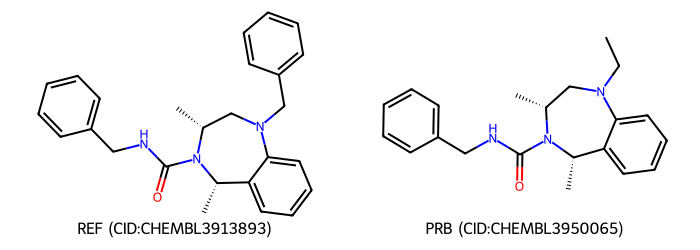

--------------------------------------------------------------------------------

例 3:
  REF-CID: CHEMBL398355, PRB-CID: CHEMBL400895
  REF-FRAG: *Cc1c[nH]cn1
  PRB-FRAG: *Cc1ccccc1
  REF-SMILES: CN1C(=O)[C@H](NC(=O)[C@@H](Cc2c[nH]cn2)NC(=O)OC(C)(C)C)N=C(c...
  PRB-SMILES: CN1C(=O)[C@H](NC(=O)[C@@H](Cc2ccccc2)NC(=O)OC(C)(C)C)N=C(c2c...
  ΔpIC50: 0.903
  Label: False
  TID: CHEMBL4296, AID: 456687


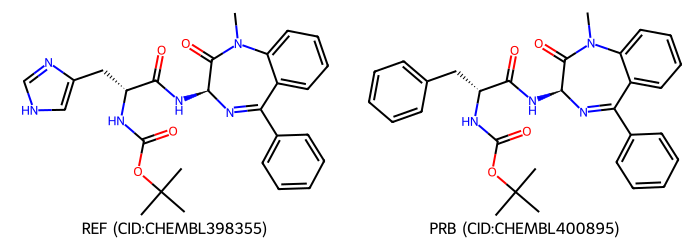

--------------------------------------------------------------------------------

例 4:
  REF-CID: CHEMBL4074011, PRB-CID: CHEMBL4065398
  REF-FRAG: *Cc1ccccc1
  PRB-FRAG: *C(C)C
  REF-SMILES: O=C1CCc2ccc(OCCCCCN3CCN(Cc4ccccc4)CC3)cc2N1...
  PRB-SMILES: CC(C)N1CCN(CCCCCOc2ccc3c(c2)NC(=O)CC3)CC1...
  ΔpIC50: -0.534
  Label: False
  TID: CHEMBL1951, AID: 1684964


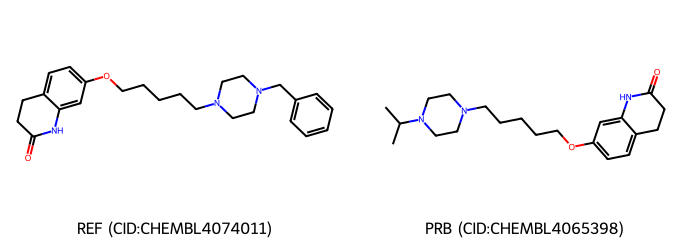

--------------------------------------------------------------------------------

例 5:
  REF-CID: CHEMBL3218005, PRB-CID: CHEMBL3218020
  REF-FRAG: *Cc1ccccc1
  PRB-FRAG: *Cc1cccc(OC(C)C)c1
  REF-SMILES: O=C(NCc1ccccc1)Nc1nc(-c2ccncc2)cs1...
  PRB-SMILES: CC(C)Oc1cccc(CNC(=O)Nc2nc(-c3ccncc3)cs2)c1...
  ΔpIC50: -1.838
  Label: False
  TID: CHEMBL2973, AID: 1330196


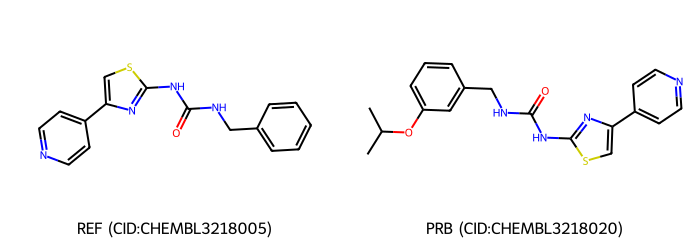

--------------------------------------------------------------------------------



In [115]:
# 例2: 第2位の置換基を分析
if len(frag_counts) > 1:
    second_frag = frag_counts.index[1]
    print(f"\n\n分析対象: 第2位の置換基\n")
    result_2 = analyze_substituent(second_frag, df, max_examples=5, random_seed=42)

### カスタム検索

特定の置換基を検索する場合は、以下のように実行してください：

```python
# 例: ベンゼン環の置換基を検索
result = analyze_substituent('[*]c1ccccc1', df, max_examples=5)

# 例: メチル基を検索
result = analyze_substituent('[*]C', df, max_examples=5)

# 例: フルオロベンゼンを検索
result = analyze_substituent('[*]c1ccc(F)cc1', df, max_examples=5)
```

## 7. 置換基ペアでの検索

REF-FRAGとPRB-FRAGの組み合わせを指定して分子ペアを検索します。

In [116]:
# 置換基ペアで検索する関数
def analyze_substituent_pair(ref_frag_smiles, prb_frag_smiles, df, max_examples=5, random_seed=42, unordered=False):
    """
    指定された置換基ペア（REF-FRAG, PRB-FRAG）を含む分子ペアを分析
    
    Parameters:
    -----------
    ref_frag_smiles : str
        REF-FRAGの置換基SMILES
    prb_frag_smiles : str
        PRB-FRAGの置換基SMILES
    df : DataFrame
        元データ
    max_examples : int
        表示する最大例数
    random_seed : int
        ランダムサンプリングのシード値
    unordered : bool
        Trueの場合、順不同で検索（REF↔PRBを入れ替えても同じとみなす）
    """
    import re
    from rdkit import Chem
    from rdkit.Chem import Draw
    
    # ダミー原子を正規化する関数
    def normalize_frag(frag_str):
        if pd.isna(frag_str):
            return frag_str
        return re.sub(r'\[\d+\*\]', '[*]', str(frag_str))
    
    # 入力された置換基を正規化
    ref_pattern = normalize_frag(ref_frag_smiles)
    prb_pattern = normalize_frag(prb_frag_smiles)
    
    # REF-FRAGとPRB-FRAGを正規化
    df_copy = df.copy()
    df_copy['REF-FRAG_norm'] = df_copy['REF-FRAG'].apply(normalize_frag)
    df_copy['PRB-FRAG_norm'] = df_copy['PRB-FRAG'].apply(normalize_frag)
    
    # 検索条件
    if unordered:
        # 順不同: (REF, PRB) または (PRB, REF) のどちらでもマッチ
        mask = (
            ((df_copy['REF-FRAG_norm'] == ref_pattern) & (df_copy['PRB-FRAG_norm'] == prb_pattern)) |
            ((df_copy['REF-FRAG_norm'] == prb_pattern) & (df_copy['PRB-FRAG_norm'] == ref_pattern))
        )
    else:
        # 順序を考慮: (REF, PRB) のみマッチ
        mask = (df_copy['REF-FRAG_norm'] == ref_pattern) & (df_copy['PRB-FRAG_norm'] == prb_pattern)
    
    df_matched = df_copy[mask]
    
    if len(df_matched) == 0:
        search_type = "順不同" if unordered else "順序考慮"
        print(f"⚠ 置換基ペア ({search_type})")
        print(f"   REF-FRAG: '{ref_frag_smiles}'")
        print(f"   PRB-FRAG: '{prb_frag_smiles}'")
        print(f"   を含む分子ペアが見つかりませんでした。")
        return None
    
    print(f"■ 置換基ペア分析 ({'順不同' if unordered else '順序考慮'})")
    print("="*80)
    print(f"  REF-FRAG: {ref_frag_smiles}")
    print(f"  PRB-FRAG: {prb_frag_smiles}")
    print("="*80)
    
    print(f"\n【全体統計】")
    print(f"  該当する分子ペア数: {len(df_matched):,} 件")
    
    # label_binの分布
    n_positive = (df_matched['label_bin'] == True).sum()
    n_negative = (df_matched['label_bin'] == False).sum()
    total = len(df_matched)
    
    print(f"\n【ラベル分布】")
    print(f"  Positive (label=True):  {n_positive:,} 件 ({n_positive/total*100:.1f}%)")
    print(f"  Negative (label=False): {n_negative:,} 件 ({n_negative/total*100:.1f}%)")
    
    # 統計情報
    print(f"\n【ΔpIC50統計】")
    print(f"  平均: {df_matched['delta_value'].mean():.3f}")
    print(f"  中央値: {df_matched['delta_value'].median():.3f}")
    print(f"  標準偏差: {df_matched['delta_value'].std():.3f}")
    print(f"  範囲: [{df_matched['delta_value'].min():.3f}, {df_matched['delta_value'].max():.3f}]")
    
    # 標的・アッセイ数
    print(f"\n【標的・アッセイ】")
    print(f"  標的数 (TID): {df_matched['TID'].nunique():,}")
    print(f"  アッセイ数 (AID): {df_matched['AID'].nunique():,}")
    
    # SMIRKSの分布
    if 'SMIRKS' in df_matched.columns:
        smirks_counts = df_matched['SMIRKS'].value_counts()
        print(f"\n【SMIRKS変換パターン】")
        print(f"  ユニークなSMIRKS数: {len(smirks_counts)}")
        if len(smirks_counts) <= 5:
            for smirks, count in smirks_counts.items():
                print(f"    {smirks}: {count:,} 件")
        else:
            print(f"  （上位5つ）")
            for smirks, count in smirks_counts.head(5).items():
                print(f"    {smirks}: {count:,} 件")
    
    # ランダムサンプリング
    n_samples = min(max_examples, len(df_matched))
    sampled = df_matched.sample(n=n_samples, random_state=random_seed)
    
    print(f"\n【分子ペアの例（ランダムに{n_samples}件）】")
    print("="*80)
    
    for idx, (_, row) in enumerate(sampled.iterrows(), 1):
        print(f"\n例 {idx}:")
        print(f"  REF-CID: {row['REF-CID']}, PRB-CID: {row['PRB-CID']}")
        print(f"  REF-FRAG: {row['REF-FRAG']}")
        print(f"  PRB-FRAG: {row['PRB-FRAG']}")
        print(f"  SMIRKS: {row.get('SMIRKS', 'N/A')}")
        print(f"  REF-SMILES: {row['REF-SMILES'][:60]}...")
        print(f"  PRB-SMILES: {row['PRB-SMILES'][:60]}...")
        print(f"  ΔpIC50: {row['delta_value']:.3f}")
        print(f"  Label: {row['label_bin']}")
        print(f"  TID: {row['TID']}, AID: {row['AID']}")
        
        # 分子構造の可視化
        try:
            ref_mol = Chem.MolFromSmiles(row['REF-SMILES'])
            prb_mol = Chem.MolFromSmiles(row['PRB-SMILES'])
            
            if ref_mol and prb_mol:
                img = Draw.MolsToGridImage(
                    [ref_mol, prb_mol],
                    molsPerRow=2,
                    subImgSize=(350, 250),
                    legends=[f"REF (CID:{row['REF-CID']})", f"PRB (CID:{row['PRB-CID']})"]
                )
                display(img)
        except Exception as e:
            print(f"  ⚠ 構造式の描画エラー: {e}")
        
        print("-" * 80)
    
    print("\n" + "="*80)
    return df_matched

# 使用例を表示
print("■ 使用方法:")
print("  # 順序を考慮した検索（REF → PRB の変換のみ）")
print("  result = analyze_substituent_pair('[*]c1ccccc1', '[*]c1ccc(F)cc1', df, unordered=False)")
print()
print("  # 順不同の検索（REF ↔ PRB の両方向を検索）")
print("  result = analyze_substituent_pair('[*]c1ccccc1', '[*]c1ccc(F)cc1', df, unordered=True)")
print()
print("  ※ ダミー原子は [*] または [数字*] の形式で指定")

■ 使用方法:
  # 順序を考慮した検索（REF → PRB の変換のみ）
  result = analyze_substituent_pair('[*]c1ccccc1', '[*]c1ccc(F)cc1', df, unordered=False)

  # 順不同の検索（REF ↔ PRB の両方向を検索）
  result = analyze_substituent_pair('[*]c1ccccc1', '[*]c1ccc(F)cc1', df, unordered=True)

  ※ ダミー原子は [*] または [数字*] の形式で指定


In [ ]:
# 頻度の高い置換基ペア（順不同）のトップ10を取得
import re

def normalize_frag(frag_str):
    if pd.isna(frag_str):
        return frag_str
    return re.sub(r'\[\d+\*\]', '[*]', str(frag_str))

# 置換基ペアを作成（順不同: 常にアルファベット順にソート）
df_temp = df.copy()
df_temp['REF-FRAG_norm'] = df_temp['REF-FRAG'].apply(normalize_frag)
df_temp['PRB-FRAG_norm'] = df_temp['PRB-FRAG'].apply(normalize_frag)

# 順不同のペアを作成（ソートして統一）
df_temp['FRAG_PAIR_unordered'] = df_temp.apply(
    lambda row: tuple(sorted([row['REF-FRAG_norm'], row['PRB-FRAG_norm']])),
    axis=1
)

# ペアごとにカウントとラベル統計
frag_pair_stats_grouped = df_temp.groupby('FRAG_PAIR_unordered').agg(
    count=('label_bin', 'size'),
    n_positive=('label_bin', lambda x: (x == True).sum()),
    n_negative=('label_bin', lambda x: (x == False).sum())
).reset_index()
frag_pair_stats = frag_pair_stats_grouped.rename(columns={'FRAG_PAIR_unordered': 'FRAG_PAIR'})
frag_pair_stats['pos_ratio'] = (frag_pair_stats['n_positive'] / frag_pair_stats['count'] * 100).round(1)
frag_pair_stats['neg_ratio'] = (frag_pair_stats['n_negative'] / frag_pair_stats['count'] * 100).round(1)
frag_pair_stats = frag_pair_stats.sort_values('count', ascending=False)



■ 頻度の高い置換基ペア Top 10（順不同）with Pos/Neg割合
順位    出現回数       Pos      Neg      REF-FRAG                                      PRB-FRAG                                     
--------------------------------------------------------------------------------------------------------------------------------------------
1     5,131      55.0%    45.0%    *C                                            *CC                                          
2     2,669      46.3%    53.7%    *C                                            *C(C)C                                       
3     2,411      55.7%    44.3%    *CC*                                          *CCC*                                        
4     2,336      54.0%    46.0%    *C*                                           *CC*                                         
5     2,195      52.5%    47.5%    *C(*)C                                        *C*                                          
6     1,889      45.6%    54.4%    *O                     

In [123]:
print("■ 頻度の高い置換基ペア Top 10（順不同）with Pos/Neg割合")
print("="*140)
print(f"{'順位':<5} {'出現回数':<10} {'Pos':<8} {'Neg':<8} {'REF-FRAG':<45} {'PRB-FRAG':<45}")
print("-"*140)
for i, (_, row) in enumerate(frag_pair_stats.head(100).iterrows(), 1):
    ref_frag, prb_frag = row['FRAG_PAIR']
    count = row['count']
    pos_ratio = row['pos_ratio']
    neg_ratio = row['neg_ratio']
    pos_str = f"{pos_ratio:.1f}%"
    neg_str = f"{neg_ratio:.1f}%"
    print(f"{i:<5} {count:<10,} {pos_str:<8} {neg_str:<8} {ref_frag:<45} {prb_frag:<45}")
print("="*140)

■ 頻度の高い置換基ペア Top 10（順不同）with Pos/Neg割合
順位    出現回数       Pos      Neg      REF-FRAG                                      PRB-FRAG                                     
--------------------------------------------------------------------------------------------------------------------------------------------
1     5,131      55.0%    45.0%    *C                                            *CC                                          
2     2,669      46.3%    53.7%    *C                                            *C(C)C                                       
3     2,411      55.7%    44.3%    *CC*                                          *CCC*                                        
4     2,336      54.0%    46.0%    *C*                                           *CC*                                         
5     2,195      52.5%    47.5%    *C(*)C                                        *C*                                          
6     1,889      45.6%    54.4%    *O                     

### 実例: 頻度の高い置換基ペアの分析

分析対象: 第1位の置換基ペア
  出現回数: 5,131 件
  Positive: 55.0%, Negative: 45.0%

■ 置換基ペア分析 (順不同)
  REF-FRAG: *C
  PRB-FRAG: *CC

【全体統計】
  該当する分子ペア数: 5,131 件

【ラベル分布】
  Positive (label=True):  2,822 件 (55.0%)
  Negative (label=False): 2,309 件 (45.0%)

【ΔpIC50統計】
  平均: 0.007
  中央値: 0.000
  標準偏差: 0.570
  範囲: [-3.753, 3.450]

【標的・アッセイ】
  標的数 (TID): 753
  アッセイ数 (AID): 2,277

【SMIRKS変換パターン】
  ユニークなSMIRKS数: 4243
  （上位5つ）
    [*N1CCN(c2ccc(-c3nn(Cc4cn(Cc5ccccc5)nn4)c4nc(NC)ncc34)cn2)CC1]>>[*CC]|[*C]: 8 件
    [*CC(*)*.*N1CCCC1.*Oc1ccc([C@@H]2Oc3ccc(O)cc3S[C@@H]2c2ccc(O)cc2)cc1]>>[*C]|[*CC]: 7 件
    [*C(*)c1ccc(Cl)cc1.*NC(=O)C1(N)CCN(c2ncnc3[nH]ccc23)CC1]>>[*CC]|[*C]: 7 件
    [*N1CCN(c2ccc(-c3nn(CC4CCCC4)c4nc(NC)ncc34)cn2)CC1]>>[*CC]|[*C]: 7 件
    [*Oc1ccc2c(c1)nc(C(=O)O)c1c3cccc(Cl)c3[nH]c21]>>[*C]|[*CC]: 7 件

【分子ペアの例（ランダムに5件）】

例 1:
  REF-CID: CHEMBL398206, PRB-CID: CHEMBL3190453
  REF-FRAG: *C
  PRB-FRAG: *CC
  SMIRKS: [*Oc1ccc(/C=N/NC(N)=S)cc1]>>[*C]|[*CC]
  REF-SMILES: COc1ccc(/C=N/NC(N)=S)cc1...
  PRB-

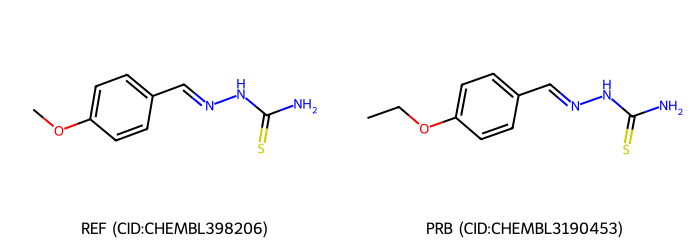

--------------------------------------------------------------------------------

例 2:
  REF-CID: CHEMBL2335152, PRB-CID: CHEMBL2331593
  REF-FRAG: *CC
  PRB-FRAG: *C
  SMIRKS: [*Oc1cc(-c2c(C)noc2C)cc(C(O)c2ccccc2)c1]>>[*CC]|[*C]
  REF-SMILES: CCOc1cc(-c2c(C)noc2C)cc(C(O)c2ccccc2)c1...
  PRB-SMILES: COc1cc(-c2c(C)noc2C)cc(C(O)c2ccccc2)c1...
  ΔpIC50: 0.015
  Label: True
  TID: CHEMBL5747, AID: 944373


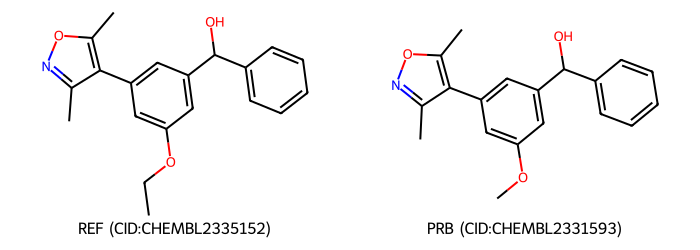

--------------------------------------------------------------------------------

例 3:
  REF-CID: CHEMBL3335251, PRB-CID: CHEMBL3335254
  REF-FRAG: *C
  PRB-FRAG: *CC
  SMIRKS: [*Oc1cc(Br)c(Br)c(/C=N/c2ccc3scnc3c2)c1O]>>[*C]|[*CC]
  REF-SMILES: COc1cc(Br)c(Br)c(/C=N/c2ccc3scnc3c2)c1O...
  PRB-SMILES: CCOc1cc(Br)c(Br)c(/C=N/c2ccc3scnc3c2)c1O...
  ΔpIC50: 0.046
  Label: True
  TID: CHEMBL4601, AID: 1438913


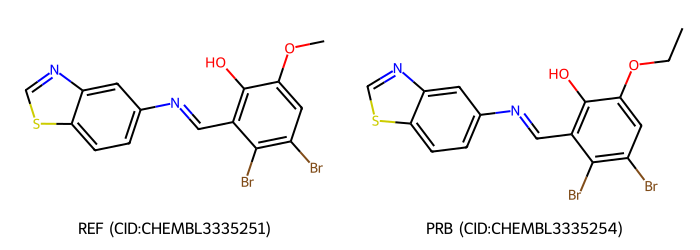

--------------------------------------------------------------------------------

例 4:
  REF-CID: CHEMBL245444, PRB-CID: CHEMBL241685
  REF-FRAG: *C
  PRB-FRAG: *CC
  SMIRKS: [*OC(=O)c1cccc2nc(CCCC)n(Cc3ccc(-n4cccc4-c4nnn[nH]4)cc3)c12]>>[*C]|[*CC]
  REF-SMILES: CCCCc1nc2cccc(C(=O)OC)c2n1Cc1ccc(-n2cccc2-c2nnn[nH]2)cc1...
  PRB-SMILES: CCCCc1nc2cccc(C(=O)OCC)c2n1Cc1ccc(-n2cccc2-c2nnn[nH]2)cc1...
  ΔpIC50: -0.288
  Label: True
  TID: CHEMBL3374, AID: 455320


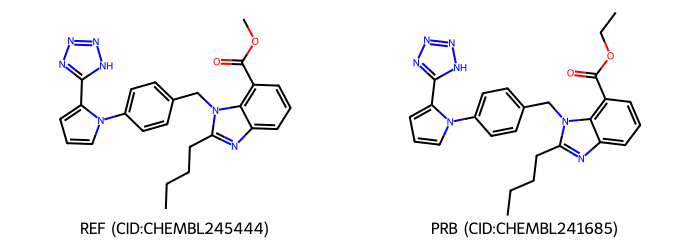

--------------------------------------------------------------------------------

例 5:
  REF-CID: CHEMBL1086441, PRB-CID: CHEMBL1085771
  REF-FRAG: *CC
  PRB-FRAG: *C
  SMIRKS: [*Sc1ccc(Cc2cc([C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)ccc2Cl)nn1]>>[*CC]|[*C]
  REF-SMILES: CCSc1ccc(Cc2cc([C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)ccc...
  PRB-SMILES: CSc1ccc(Cc2cc([C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)ccc2...
  ΔpIC50: 0.726
  Label: False
  TID: CHEMBL3884, AID: 635509


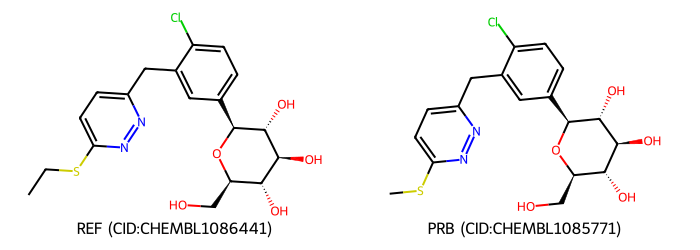

--------------------------------------------------------------------------------



In [121]:
# 例: 最も頻度の高い置換基ペアを分析（順不同）
if len(frag_pair_stats) > 0:
    top_row = frag_pair_stats.iloc[0]
    ref_frag, prb_frag = top_row['FRAG_PAIR']
    print(f"分析対象: 第1位の置換基ペア")
    print(f"  出現回数: {top_row['count']:,} 件")
    print(f"  Positive: {top_row['pos_ratio']:.1f}%, Negative: {top_row['neg_ratio']:.1f}%\n")
    result_pair_1 = analyze_substituent_pair(ref_frag, prb_frag, df, max_examples=5, unordered=True, random_seed=42)

### カスタム置換基ペア検索

特定の置換基ペアを検索する場合の例：

```python
# 例1: ベンゼン → フルオロベンゼンの変換（順序考慮）
result = analyze_substituent_pair('[*]c1ccccc1', '[*]c1ccc(F)cc1', df, unordered=False, max_examples=5)

# 例2: ベンゼン ↔ フルオロベンゼンの変換（順不同）
result = analyze_substituent_pair('[*]c1ccccc1', '[*]c1ccc(F)cc1', df, unordered=True, max_examples=5)

# 例3: メチル → エチルの変換
result = analyze_substituent_pair('[*]C', '[*]CC', df, unordered=False, max_examples=5)

# 例4: Cl ↔ Brの変換（ハロゲン交換、順不同）
result = analyze_substituent_pair('[*]Cl', '[*]Br', df, unordered=True, max_examples=5)
```